### Étude de l'intégration des données météorologique et des jours fériés et vacances sur les series temporelles de la Demande

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os 
os.environ["ENV"]="LOCAL"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../store_order_service_account"
#print(os.environ) 
os.chdir("/Users/gnabeyeuemmanuel/Desktop/demandEstimate/demand-service")

#### Useful Library

In [4]:
import os
import sys
import sys; 
sys.path.insert(0, '..')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Data processing
import pandas as pd
import numpy as np
# Model performance evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from sklearn import metrics

from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
from sklearn.cluster import KMeans
#import pandasgui

%matplotlib inline
import google.cloud.secretmanager as secretmanager

#from utils.utility_fct import get_table_sql,cross_product


from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

import time
import datetime
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
#from french_holidays import get_french_holiday_calendar


from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from datetime import datetime, timedelta

### Load and Plot the time series dataset

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#path = '/content/drive/MyDrive/Data/demande.csv'
#series1 = pd.read_csv(path)
#series2 = pd.read_csv('/content/drive/MyDrive/Data/product_movements.csv', header=0) 
#series1.head()

In [81]:
series1 = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/Data/demandes.csv', header=0) #index_col=0 
series2 = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/Data/products_movements.csv', header=0) #.iloc[20:,:] 
series1['product_count']=series1['product_count']
series1=series1[['store_id','product_id','product_count','time']]
series2=series2[['store_id','product_id','start_date', 'end_date']]
series1.head() 

,store_id,product_id,product_count,time
0,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-03
1,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-05
2,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,2.0,2022-02-09
3,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-10
4,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,2.0,2022-02-13


In [8]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df1=pd.DataFrame() 
    #début à partir du 1er janvier 2022   .strftime('%Y-%m-%d')
    ref=datetime(2022,1,1)
    indexNames = df[df['end_date'] < ref].index
    df.drop(indexNames , inplace=True)
    for i in df.index:
        if df['start_date'][i] < ref:
            df['start_date'][i] = ref
            
    #Dates intermédiaires sur la présence des produits dans le magassin
    df["date"] = df.apply(lambda x: pd.date_range(x.start_date, x.end_date), axis=1)
    df = df.explode('date').reset_index(drop=True)
    df['date']=df['date'].dt.date
        
    return df
    

In [9]:
series2['start_date']= pd.to_datetime(series2['start_date'],utc=True).dt.tz_localize(None)
series2['end_date']= pd.to_datetime(series2['end_date'],utc=True).dt.tz_localize(None)

df_pro=preprocess(series2)
df_pro

,store_id,product_id,start_date,end_date,date
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-08-04 12:31:12.774,2022-01-01
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-08-04 12:31:12.774,2022-01-02
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-08-04 12:31:12.774,2022-01-03
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-08-04 12:31:12.774,2022-01-04
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-08-04 12:31:12.774,2022-01-05
...,...,...,...,...,...
1415214,627e47501f5ac0001658172d,62c713101310330011e6bc44,2022-07-27 22:20:08.131,2022-08-04 12:31:12.774,2022-07-31
1415215,627e47501f5ac0001658172d,62c713101310330011e6bc44,2022-07-27 22:20:08.131,2022-08-04 12:31:12.774,2022-08-01
1415216,627e47501f5ac0001658172d,62c713101310330011e6bc44,2022-07-27 22:20:08.131,2022-08-04 12:31:12.774,2022-08-02
1415217,627e47501f5ac0001658172d,62c713101310330011e6bc44,2022-07-27 22:20:08.131,2022-08-04 12:31:12.774,2022-08-03


In [10]:
series1['date'] = pd.to_datetime(series1.time).dt.date
series3=series1.merge(df_pro, how='right', on=['date','store_id','product_id']).fillna({'product_count':0})
series3

,product_id,store_id,time,product_count,date,start_date,end_date
0,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,NaN,0.0,2022-01-01,2022-01-01 00:00:00.000,2022-08-04 12:31:12.774
1,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,NaN,0.0,2022-01-02,2022-01-01 00:00:00.000,2022-08-04 12:31:12.774
2,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,NaN,0.0,2022-01-03,2022-01-01 00:00:00.000,2022-08-04 12:31:12.774
3,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,NaN,0.0,2022-01-04,2022-01-01 00:00:00.000,2022-08-04 12:31:12.774
4,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,NaN,0.0,2022-01-05,2022-01-01 00:00:00.000,2022-08-04 12:31:12.774
...,...,...,...,...,...,...,...
1415214,62c713101310330011e6bc44,627e47501f5ac0001658172d,NaN,0.0,2022-07-31,2022-07-27 22:20:08.131,2022-08-04 12:31:12.774
1415215,62c713101310330011e6bc44,627e47501f5ac0001658172d,NaN,0.0,2022-08-01,2022-07-27 22:20:08.131,2022-08-04 12:31:12.774
1415216,62c713101310330011e6bc44,627e47501f5ac0001658172d,NaN,0.0,2022-08-02,2022-07-27 22:20:08.131,2022-08-04 12:31:12.774
1415217,62c713101310330011e6bc44,627e47501f5ac0001658172d,2022-08-03,1.0,2022-08-03,2022-07-27 22:20:08.131,2022-08-04 12:31:12.774


In [11]:
df=series3.dropna()
df.drop(df.columns[[4, 5]], axis = 1, inplace = True) #df.drop(df.loc[:, 'start_date ':'end_date '].columns, axis = 1) 
df

,product_id,store_id,time,product_count,end_date
41826,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-03,1.0,2022-08-04 12:31:12.774
41828,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-05,1.0,2022-08-04 12:31:12.774
41832,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-09,2.0,2022-08-04 12:31:12.774
41833,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-10,1.0,2022-08-04 12:31:12.774
41836,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-13,2.0,2022-08-04 12:31:12.774
...,...,...,...,...,...
1415159,62b9c615605ef300169554dc,627e47501f5ac0001658172d,2022-07-10,3.0,2022-08-04 12:31:12.774
1415187,62c55485764df20011c5e180,627e47501f5ac0001658172d,2022-07-20,3.0,2022-08-04 12:31:12.774
1415199,62c55485764df20011c5e180,627e47501f5ac0001658172d,2022-08-01,2.0,2022-08-04 12:31:12.774
1415207,62c6ecdd00fdf50011e3bb4b,627e47501f5ac0001658172d,2022-08-01,1.0,2022-08-04 12:31:12.774


#### création d'une matrice avec une ligne par pas de temps et une colonne par produit/magasin

In [12]:
timestep_product_store =pd.pivot_table(df, values='product_count', index=['time'],
            columns=['product_id', 'store_id'], 
            aggfunc=np.sum) #, fill_value=0) # nan ou fillna= moyenne de la colonne

In [13]:
# fillna() On = 'average quantity of each product over the all data' ie Matrix completion
        # tab = df[['product_id', 'store_id', 'product_count']].groupby(['product_id', 'store_id']).mean()
tab = timestep_product_store.mean()
timestep_product_store = timestep_product_store.fillna(tab)

# df_air['CO_GT']=df_air['CO_GT'].fillna(df_air.groupby(['DATE','HOUR'])['CO_GT'].transform('mean'))

#### Feature ingeneering

À partir des dates calendaires, nous avons pu extraire de nombreuses caractéristiques, qui 
La météo a une influence sur notre vie de tous les jours : ventes, visites, consommation, etc. Les saisons dictent nos comportements d’achat. Mais, est-ce qu’il s’agit d’une simple saisonnalité ou d’une météo-sensibilité ? Pour savoir si l’intégration de la météo au sein de nos modèles était pertinente, nous avons fait un comparatif.

Le comparatif des modèles s’est fait dans des conditions d’expériences égales

Nos métriques d’évaluation des modèles sont un score global RMSE entre les semaines et un vecteur de scores RMSE pour chaque jour de la semaine.


étapes:
Apprentissage sur l’historique + données calendaires
Apprentissage sur l’historique + données météo
Apprentissage sur l’historique + données calendaires + données météo

In [13]:
scaler=StandardScaler()
table_scaled=scaler.fit_transform(timestep_product_store)

In [14]:
mypca = PCA(n_components = 0.85)
mypca.fit(table_scaled)
print("Cumulative Variances (Percentage):")
print(np.cumsum(mypca.explained_variance_ratio_ * 100))
components = len(mypca.explained_variance_ratio_)
print(f'Number of components: {components}')

Cumulative Variances (Percentage):
[ 1.31997626  2.34321747  3.34521458  4.3206148   5.24720535  6.1679772
  7.07725376  7.93612419  8.78566956  9.61687329 10.43932087 11.24826067
 12.04717629 12.83340577 13.60955157 14.38056853 15.14160449 15.90020688
 16.65841476 17.4100206  18.15167932 18.88675561 19.61465926 20.32595314
 21.03516616 21.73743286 22.43263873 23.12075643 23.8046441  24.47211333
 25.13715763 25.79863234 26.45565773 27.10756339 27.7536564  28.39515835
 29.03452068 29.66727422 30.29486668 30.91917492 31.54019494 32.156489
 32.76403916 33.37026145 33.9717888  34.57142036 35.16887429 35.76248402
 36.3503474  36.93578766 37.51897931 38.09699999 38.67336615 39.24605569
 39.81397986 40.37724993 40.93343388 41.48894179 42.04144389 42.59322019
 43.13868837 43.6815205  44.22188785 44.75771931 45.29112803 45.82305357
 46.35124451 46.87723571 47.40109195 47.92276389 48.44111507 48.95834762
 49.4718852  49.98160784 50.48692727 50.98951035 51.48546526 51.97905839
 52.46997094 52.957

Text(0, 0.5, 'Explained variance (%)')

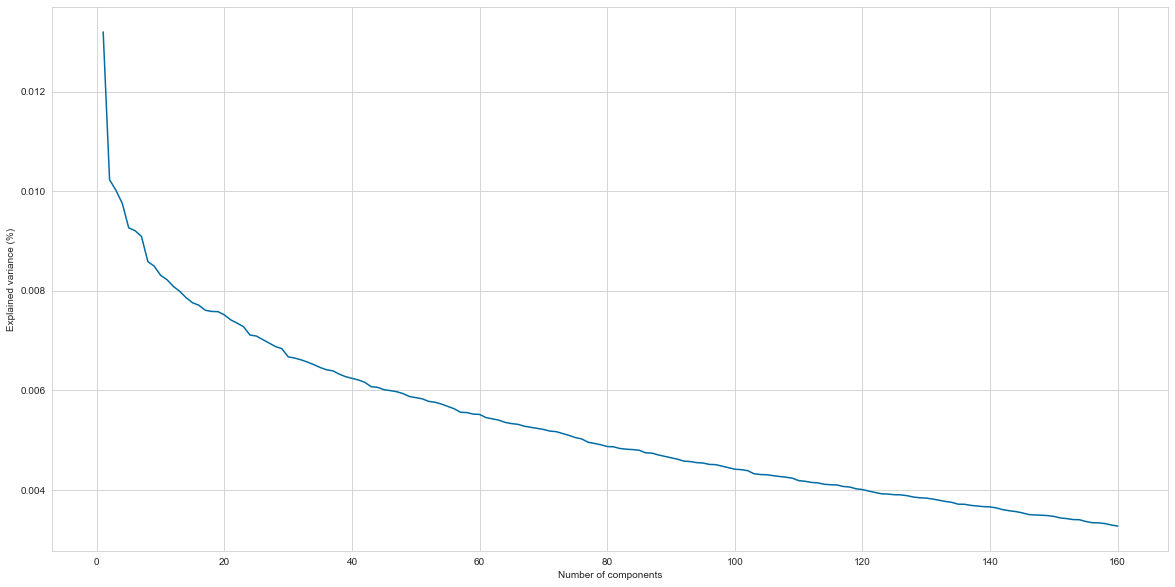

In [15]:
# Make the scree plot
plt.plot(range(1, components + 1), mypca.explained_variance_ratio_ )
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

Text(0, 0.5, 'Explained variance (%)')

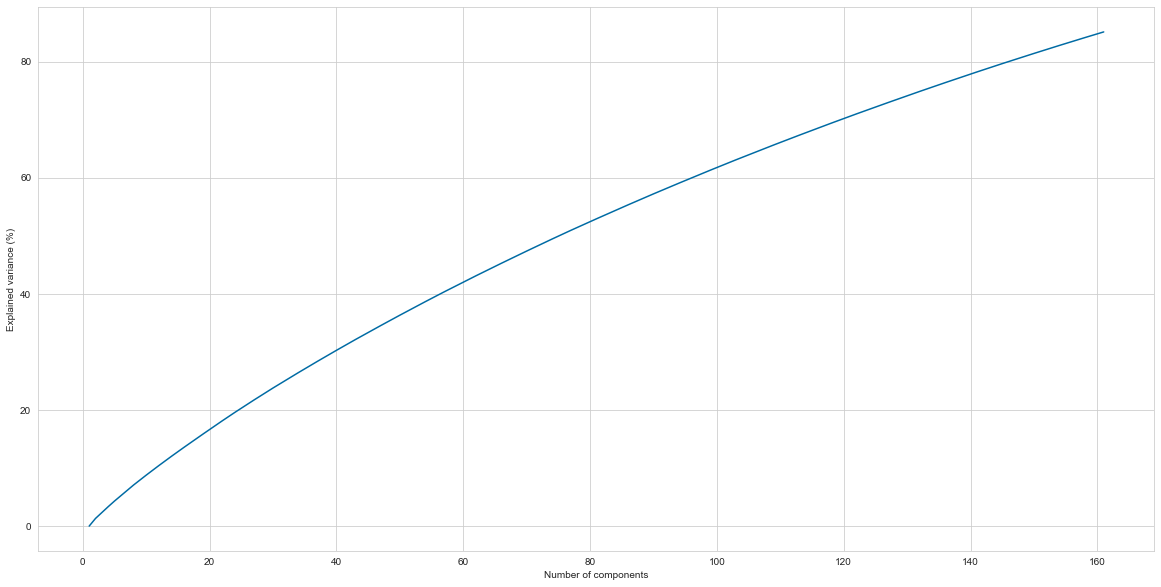

In [16]:
# Make the scree plot
y_h=np.cumsum(mypca.explained_variance_ratio_ * 100)
y_h = np.insert(y_h,0, 0)
plt.plot(range(1, components + 2), y_h)
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

In [17]:
Composantes_principales=mypca.fit_transform(timestep_product_store)
Composantes_principales
columns=['PC'+str(i) for i in range(3)]
nouv_y=pd.DataFrame(data=Composantes_principales,columns=columns)

In [18]:
nouv_y

,PC0,PC1,PC2
0,0.013921,0.047604,-0.256939
1,0.026316,0.264844,-2.503960
2,-0.002735,0.040016,-1.686531
3,-0.035125,0.272349,-2.065946
4,-0.018572,0.253422,-1.938485
...,...,...,...
210,-0.057889,-0.290129,4.218052
211,-0.125827,-1.440201,1.348773
212,-0.517580,-0.507766,4.065898
213,-0.069422,-0.353070,1.506039


#### Data Pre-processing for Machine Learning

In [14]:
def generate_input(df: pd.DataFrame) -> pd.DataFrame:
    df['time'] = pd.to_datetime(df.time, format='%Y-%m-%d')
    input_data = pd.concat([
            df['time'].dt.day,
            # df['time'].dt.month,
            df['time'].dt.weekday,
            df['time'].dt.isocalendar().week,
        ], axis=1).drop_duplicates()
    input_data.columns = ['day', 'weekday', 'weekofyear']
    return input_data.reset_index()[['day','weekday','weekofyear']]

In [15]:
def metrics_(orig, prediction):
    mse = mean_squared_error(y_true=orig,
                                 y_pred=prediction)
    mae = mean_absolute_error(y_true=orig,
                                  y_pred=prediction)
    ms_le = mean_squared_log_error(y_true=np.abs(orig),
                                       y_pred=np.abs(prediction))
    metric = dict()
    metric['MSE'] = mse
    metric['MAE'] = mae
    metric['MSLE'] = ms_le
    return metric

In [16]:
#table=timestep_product_store
import math
def normalize(y_train):  
    # Choose between standardization and MinMAx normalization
    scaler=StandardScaler()
    # Storing the fit object for later reference
    scaler=scaler.fit(y_train)
    # Generating the standardized values of X
    yhat=scaler.transform(y_train)
    return yhat, scaler

def split(X,y,test_size=0.2,n_pca=20):
    n=X.shape[0]
    m=y.shape[0]
    X_train=X[0:math.floor((1-test_size)*n)]
    X_test=X[math.floor((1-test_size)*n):n+1]
    
    y_train=y[0:math.floor((1-test_size)*m)]
    y_test=y[math.floor((1-test_size)*m):m+1]
    
    ## Normalisation 
    yhat, scaler= normalize(y_train)
    ##pca sur les données les sorties d'entrainements.
    mypca=PCA(n_components= n_pca)
    Composantes_principales=mypca.fit_transform(yhat)
    columns=['PC'+str(i) for i in range(n_pca)]
    y_train=pd.DataFrame(data=Composantes_principales,columns=columns)
    
    return X_train,X_test,y_train,y_test,scaler,mypca

### Modèles à utiliser

###### Regression Linéaire

In [17]:
def lin_reg(X,y,n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,y,test_size=0.2,n_pca=n_pca)
    # Multiple Linear Regression 
    RegModel = LinearRegression()

    # Printing all the parameters of Linear regression
    # print(RegModel)

    # Creating the model on Training Data
    LREG=RegModel.fit(X_train,y_train)
    prediction=LREG.predict(X_test)
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    # Measuring Goodness of fit in Training data
    coef_determ=metrics.r2_score(y_train, LREG.predict(X_train))
    print('LinReg R2 Valuefor n_pca=: %i' % n_pca ,coef_determ)

    metrics_hist=metrics_(y_test,preds)
    metrics_hist['R2']=coef_determ
    return preds,metrics_hist #,LREG

###### SVM

In [18]:
# Support Vector Machines(SVM)
def Multi_svm(X,y,n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,y,test_size=0.2,n_pca=n_pca)
    
    svregressor= svm.SVR(C=50, kernel='rbf', gamma=0.01) # LinearSVR() #
    
    mulregressor = MultiOutputRegressor(svregressor)
    # Printing all the parameters
    #print(mulregressor)

    # Creating the model on Training Data
    SVM=mulregressor.fit(X_train,y_train)
    prediction=SVM.predict(X_test)
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    coef_determ=metrics.r2_score(y_train, SVM.predict(X_train))
    print('SVM R2 Value for n_pca=: %i' % n_pca,coef_determ)
    
    metrics_hist=metrics_(y_test,preds)
    metrics_hist['R2']=coef_determ
    return preds,metrics_hist #,SVM

###### Randon Forest

In [19]:
def RandForest_Regressor(X,y,n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,y,test_size=0.2,n_pca=n_pca) 
    
    param = {
        'max_depth': 8,
        'min_impurity_decrease': 0.072,
        'min_samples_split': 31,
        'n_estimators': 100,
    }
    
    rf = RandomForestRegressor() #(**param)
    # Creating the model on Training Data
    rf_b=rf.fit(X_train,y_train)
    
    prediction=rf_b.predict(X_test)
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Training data
    coef_determ=r2_score(y_train, rf_b.predict(X_train))
    print('RFRegressor R2 Value over the train set', coef_determ)
    
    metrics_hist=metrics_(y_test,preds)
    metrics_hist['R2']=coef_determ
    return preds,metrics_hist 

###### Xtreme Grandient Boosting

In [20]:
def xtremegb(X,y,n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,y,test_size=0.2,n_pca=n_pca)
    RegModel=XGBRegressor(max_depth=3, 
                          learning_rate=0.1, 
                          n_estimators=1000, 
                          objective='reg:squarederror',
                          booster='gbtree')

    # Creating the model on Training Data
    XGB=RegModel.fit(X_train,y_train)
    prediction=XGB.predict(X_test) 
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    coef_determ=metrics.r2_score(y_train, XGB.predict(X_train))
    print('XgBoost R2 Value for n_pca=:%i' % n_pca,coef_determ)
    
    metrics_hist=metrics_(y_test,preds)
    metrics_hist['R2']=coef_determ
    return preds,metrics_hist #,XGB

###### FbProphet

In [21]:
#!pip install pystan~=2.14
#!pip install fbprophet

In [22]:
# importing Prophet model
# importing prophet library
import fbprophet
from fbprophet import Prophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


Prophet automatically fits daily, weekly, and yearly seasonalities if the time series is more than two cycles long.
1. The daily seasonality is disabled because we do not have sub-daily time series.
2. The yearly seasonality is disabled because we do not have two full years of data in the training dataset.
Besides seasonalities and additional predictors, we can also incorporate holidays and special events in a prophet time series model.

In [75]:
# FaceBook Model Prophet()
# importing prophet library
def FBprophet(X,y,n_pca,events=None):
    X_train, X_test, y_train, y_test, myscaler, mypca = split(X,y, test_size=0.2, n_pca=n_pca)
    y_preds = pd.DataFrame(y.index)
    for i in range(n_pca):
        # Creating the model
        # set the uncertainty interval to 95% (the Prophet default is 80%)
        # Add seasonality
        model_baseline = Prophet(interval_width=0.95, daily_seasonality=True,
                                     weekly_seasonality=True, holidays=events)
        # Add regressor  # holidays_envents(special event) and Meteo data ?
        # model_baseline.add_regressor(['bank_holiday','holiday'], standardize=False)
        # Add built-in country-specific holidays  # that is really bank_holiday ?
        model_baseline.add_country_holidays(country_name='FR')

        sales = y_train.loc[:, ['PC' + str(i)]]
        sales['time'] = X_train['time']
        train = X_train.merge(sales, on='time', how='left')
        # sales=sales.reset_index()
        train = train.rename(columns={'time': 'ds',
                                          'PC' + str(i): 'y'})

        # Fit the model on the training dataset
        model_baseline.fit(train)

        # dataframe that extends into future 5 weeks
        future_multivariate = model_baseline.make_future_dataframe(periods=len(y_test), freq='D')
        # Append the regressor values if previously consider
        #data1 = data.rename(columns={'time': 'ds',
        #                             'PC' + str(i): 'y'})
        #data1['ds'] = pd.to_datetime(data1['ds'], format='%Y-%m-%d')
        #future_multivariate = pd.merge(future_multivariate, data1[['ds', 'bank_holiday', 'holiday']], on='ds',
        #                               how='inner')
        # Fill the missing values with the previous value
        # future_multivariate = future_multivariate.fillna(method='ffill')
        # Make prediction
        forecast_multivariate = model_baseline.predict(future_multivariate)
        # predictions
        # forecast = my_model.predict(future_dates) #the forecast is over the whole training set + the test set
        y_preds['Forecast' + str(i)] = forecast_multivariate.yhat.values

    prediction = y_preds.set_index('time')
    preds = myscaler.inverse_transform(mypca.inverse_transform(prediction))
    

    # Measuring Goodness of fit in Testing data 'MSE: %.3f' % MSE
    metrics_hist = metrics_(y_test, preds[-len(y_test):])

    
    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    coef_determ='null' #metrics.r2_score(y_train, preds[:len(y_test)])
    
    
    metrics_hist['R2']=coef_determ
    
    preds_Total=pd.DataFrame(preds,index=y.index)
    print(model_baseline.train_holiday_names)
    return preds_Total,metrics_hist 

In [76]:
# FaceBook Model Prophet()
# importing prophet library
def fbprophet_addPredictor_covariable(X,y,n_pca,regressor_values,events=None):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,y,test_size=0.2,n_pca=n_pca)
    y_preds = pd.DataFrame(y.index)

    for i in range(n_pca):
        # Creating the model
        # set the uncertainty interval to 95% (the Prophet default is 80%)

        # Add seasonality 
        model_multivariate = Prophet(interval_width=0.95, daily_seasonality=True,
                                     weekly_seasonality=True, holidays=events)
        # Add regressor  # holidays_envents(special event) and Meteo data ?
        for regresor in regressor_values:
            model_multivariate.add_regressor(regresor, standardize=False)
        # Add built-in country-specific holidays  # that is really bank_holiday and not holidays in France
        model_multivariate.add_country_holidays(country_name='FR')

        sales = y_train.loc[:, ['PC' + str(i)]]
        sales['time'] = X_train['time']
        train = X_train.merge(sales, on='time', how='left')
        # sales=sales.reset_index()
        train = train.rename(columns={'time': 'ds',
                                      'PC' + str(i): 'y'})

        # Fit the model on the training dataset
        model_multivariate.fit(train)

        # dataframe that extends into future 5 weeks
        future_multivariate = model_multivariate.make_future_dataframe(periods=len(y_test), freq='D')
        # Append the regressor values if previously consider
        data = X.rename(columns={'time': 'ds'})
        data['ds'] = pd.to_datetime(data['ds'], format='%Y-%m-%d')
        future_multivariate = pd.merge(future_multivariate, data[['ds'] + regressor_values], on='ds',
                                       how='inner')
        # Fill the missing values with the previous value
        future_multivariate = future_multivariate.fillna(method='ffill')

        # Make prediction
        forecast_multivariate = model_multivariate.predict(future_multivariate)
        # predictions
        # forecast = my_model.predict(future_dates) #the forecast is over the whole training set + the test set
        y_preds['Forecast' + str(i)] = forecast_multivariate.yhat.values

    prediction = y_preds.set_index('time')
    preds = myscaler.inverse_transform(mypca.inverse_transform(prediction))

    # Measuring Goodness of fit in Testing data 'MSE: %.3f' % MSE
    metrics_hist = metrics_(y_test, preds[-len(y_test):])

    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    coef_determ = 'null'  # metrics.r2_score(y_train, preds[:len(y_test)])

    metrics_hist['R2'] = coef_determ

    preds_Total = pd.DataFrame(preds, index=y.index, columns=y.columns)   
    return preds_Total,metrics_hist 

###### DeepAR d'Amazon

In [25]:
#!pip3 install mxnet
#!pip install gluonts

In [26]:
import gluonts
from gluonts.model.deepar import DeepAREstimator
#from gluonts.trainer import Trainer
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm 
from datetime import datetime

In [32]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}
# estimator.set_hyperparameters(**hyperparameters)

NameError: name 'freq' is not defined

In [27]:
# constants
start_train_date = pd.to_datetime(datetime(2022,1,1), format='%Y-%m-%d') 
end_train_date = pd.to_datetime(datetime(2022,6,21), format='%Y-%m-%d') 

data_freq='D' 
nb_days_pred = 43 #14

# Possibility to set learning rate and its decay factor
# For now we set them to default values from https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html
lr_decay_factor = 0.5
learning_rate = 0.001
# For the nb of epochs, default is 100 but we set it to less to reduce training time.
# We will train with 100 epochs in the stability study, see variable DEEPAR_MAX_EPOCH_LIST_STR below.
max_epochs = 30
num_eval_samples=100

In [28]:
def DeepAR_Amazon(X,y,n_pca,feat_dynamic_cols = None):
    components = ['PC' + str(i) for i in range(n_pca)]
    X_train, X_test, y_train, y_test, myscaler, mypca = split(X, y, test_size=0.2, n_pca=n_pca)
    y_train['time'] = X_train['time']
    y_train = y_train.set_index('time')
    # data for evaluation prediction
    Composantes_principales = mypca.transform(y_test)
    columns = ['PC' + str(i) for i in range(n_pca)]
    testy = pd.DataFrame(data=Composantes_principales, columns=columns)
    testy['time'] = X_test['time'].values
    testy = testy.set_index('time')

    estimator = DeepAREstimator(freq=data_freq,
                                prediction_length=nb_days_pred,
                                trainer=Trainer(epochs=max_epochs, learning_rate=learning_rate,
                                                learning_rate_decay_factor=lr_decay_factor),
                                use_feat_dynamic_real=feat_dynamic_cols is not None)
    # estimator.set_hyperparameters(**hyperparameters)
    # the DeepAR model determines the input in the dict (.json, .json.gz, or .parquet) format
    if feat_dynamic_cols is not None:

        training_data = ListDataset(
            [{"item_id": component,
              "start": str(start_train_date),
              "target": y_train[component][:end_train_date],
              "feat_dynamic_real": [X_train[feat_dynamic_col]   #[:end_train_date]
                                    for feat_dynamic_col in feat_dynamic_cols]
              }
             for component in components],
            freq=data_freq
        )
        test_data = ListDataset(
            [{"item_id": component,
              "start": str(end_train_date),
              "target": testy[component],  # [:test_date + timedelta(hours=nb_days_pred)],
              "feat_dynamic_real": [
                  X_test[feat_dynamic_col]  # [:test_date + timedelta(hours=nb_days_pred)]
                  for feat_dynamic_col in feat_dynamic_cols]
              }
             for component in components],
            freq=data_freq
        )
    else:
        training_data = ListDataset(
            [{"item_id": component,
              "start": str(start_train_date),
              "target": y_train[component][:end_train_date]
              }
             for component in components],
            freq=data_freq
        )
        test_data = ListDataset(
            [{"item_id": component,
              "start": str(end_train_date),
              "target": testy[component],  # [:test_date + timedelta(hours=nb_days_pred)],
              }
             for component in components],
            freq=data_freq
        )

    predictor = estimator.train(training_data=training_data)
    forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=num_eval_samples)

    forecasts = list(tqdm(forecast_it, total=len(testy)))
    tss = list(tqdm(ts_it, total=len(testy)))

    results_mean = {}
    for i in range(n_pca):
        forecast = forecasts[i]
        results_mean[forecast.item_id] = forecast.mean
    prediction = pd.DataFrame(results_mean, index=testy.index)
    preds = myscaler.inverse_transform(mypca.inverse_transform(prediction))
    # Measuring Goodness of fit in Testing data 'MSE: %.3f' % MSE
    metrics_hist = metrics_(y_test, preds)

    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    coef_determ = 'null'  # metrics.r2_score(y_train, preds[:len(y_test)])
    metrics_hist['R2'] = coef_determ
    preds_Total=pd.DataFrame(preds,index=y_test.index)    
    return preds_Total,metrics_hist

In [35]:
### LSTM for multivariate Times series forecasting

In [ ]:
''' Helper to create time frames with look backs '''
# TimeSteps=look_back=10 # next few day's quantity Prediction is based on last how many past day's quantities
# FutureTimeSteps=3 # How many days in future you want to predict the quantities

def create_dataset(dataset, look_back=1,FutureTimeSteps=3):
    dataX, dataY = [], []  # or = list()
    NumerOfRows = len(dataset)
    for i in range(look_back , NumerOfRows-FutureTimeSteps , 1):
        x_sample = dataset[i-look_back:i]
        y_sample = dataset[i:i+FutureTimeSteps,]
        dataX.append(x_sample)
        dataY.append(y_sample)  # (dataset[i + look_back, 0]) if FutureTimeSteps=1
    print(len(dataY))
    
    ################################################
 
    # Reshape the Input as a 3D (samples, Time Steps, Features)
    X_data=np.array(dataX)
    X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
    print('### Input Data Shape ###') 
    print(X_data.shape)

    # We do not reshape y as a 3D data  as it is supposed to be a single column only
    y_data=np.array(dataY)
    y_data=y_data.reshape(y_data.shape[0],y_data.shape[1])
    
    return X_data, y_data

''' Creating time frames with look backs '''
look_back = 8
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# Choosing the number of testing data records
TestingRecords=15

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

In [ ]:
# Multi step data preparation
 
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next few day's quantity Prediction is based on last how many past day's quantities
FutureTimeSteps=3 # How many days in future you want to predict the quantities
 
# Iterate through the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
 
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0],y_data.shape[1])
print('### Output Data Shape ###') 
print(y_data.shape)

In [ ]:

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

###################################################################

import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')




In [ ]:
def lstm_ann(n_pca,regressor):
    y_train,y_test,myscaler,mypca=split_temporelMethod(test_size=0.2,n_pca=n_pca)
    y_preds=pd.DataFrame(table.index)
    for i in range (n_pca):
        # set the uncertainty interval to 95% (the Prophet default is 80%)
        my_model = Prophet(interval_width = 0.95)
        sales=y_train.loc[:,['PC'+str(i)]]
        sales=sales.reset_index()
        sales = sales.rename(columns = {'date': 'ds',
                                'PC'+str(i): 'y'})
        
        # Creating the model on Training Data
        my_model.fit(sales)

        # dataframe that extends into future 5 weeks
        future_dates = my_model.make_future_dataframe(periods=len(y_test), freq='D')
        # predictions 
        forecast = my_model.predict(future_dates) #the forecast is over the whole training set + the test set
        y_preds['Forecast'+str(i)]=forecast.yhat.values


    prediction=y_preds.set_index('date')
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Testing data 'MSE: %.3f' % MSE
    metrics_hist=metrics_(y_test,preds[-len(y_test):])

    preds_Total=pd.DataFrame(preds,index=table.index)    
    return preds_Total,metrics_hist #,my_model

### Étude de l'intégration des données météorologique 

In [30]:
# from url='https://www.visualcrossing.com'
df_meteo=pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/Data/DonnéesMéteorologiques.csv', header=0)
df_meteo.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Paris,2022-01-01,57.1,46.0,50.8,57.1,44.2,49.9,47.3,88.2,...,2.9,2,NaN,2022-01-01T08:44:12,2022-01-01T17:04:25,0.99,Clear,Clear conditions throughout the day.,clear-day,"07149099999,07156099999,07146099999,E3042,0715..."
1,Paris,2022-01-02,57.2,49.2,53.3,57.2,47.1,53.0,46.8,78.5,...,1.5,1,NaN,2022-01-02T08:44:09,2022-01-02T17:05:25,1.00,"Rain, Partially cloudy",Partly cloudy throughout the day with afternoo...,rain,"07149099999,07156099999,07146099999,E3042,0715..."
2,Paris,2022-01-03,54.8,51.4,52.6,54.8,51.4,52.6,48.3,85.5,...,1.7,1,NaN,2022-01-03T08:44:02,2022-01-03T17:06:28,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"07149099999,07156099999,07146099999,E3042,0714..."
3,Paris,2022-01-04,52.6,40.3,47.8,52.6,32.1,44.3,44.6,89.0,...,1.1,1,NaN,2022-01-04T08:43:53,2022-01-04T17:07:33,0.02,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"07149099999,07156099999,07146099999,0714509999..."
4,Paris,2022-01-05,43.7,35.5,39.4,38.1,28.7,34.1,32.2,75.3,...,2.3,2,NaN,2022-01-05T08:43:40,2022-01-05T17:08:40,0.05,Clear,Clear conditions throughout the day.,clear-day,"07149099999,07156099999,07146099999,E3042,0714..."


In [31]:
df_meteo.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [32]:
dataset_meteo=df_meteo[['datetime', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed', 'winddir',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk',
       'moonphase']].sort_values(by=['datetime']).drop_duplicates(subset=['datetime'])
dataset_meteo

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windgust,windspeed,winddir,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
0,2022-01-01,57.1,46.0,50.8,57.1,44.2,49.9,47.3,88.2,0.00,...,15.7,8.1,178.3,11.9,9.0,33.6,2.9,2,NaN,0.99
1,2022-01-02,57.2,49.2,53.3,57.2,47.1,53.0,46.8,78.5,0.01,...,33.3,15.2,214.8,24.1,15.1,18.2,1.5,1,NaN,1.00
2,2022-01-03,54.8,51.4,52.6,54.8,51.4,52.6,48.3,85.5,0.34,...,32.5,14.2,223.5,27.0,10.5,18.8,1.7,1,NaN,0.00
3,2022-01-04,52.6,40.3,47.8,52.6,32.1,44.3,44.6,89.0,0.83,...,36.9,16.5,234.9,27.6,11.0,13.3,1.1,1,NaN,0.02
4,2022-01-05,43.7,35.5,39.4,38.1,28.7,34.1,32.2,75.3,0.00,...,29.8,11.5,291.8,4.0,14.4,27.2,2.3,2,NaN,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,2022-07-30,85.2,64.7,76.2,83.5,64.7,75.7,52.8,45.3,0.00,...,21.7,9.0,197.5,7.4,16.3,131.9,11.5,8,10.0,0.01
211,2022-07-31,82.8,65.5,73.4,83.1,65.5,73.5,59.1,61.9,0.00,...,20.8,10.5,280.8,7.3,15.5,163.3,14.0,8,10.0,0.04
212,2022-08-01,80.0,68.1,73.0,80.5,68.1,73.0,59.1,63.0,0.00,...,15.5,7.1,307.8,21.1,16.4,75.8,6.4,4,10.0,0.07
213,2022-08-02,87.7,62.5,75.5,86.4,62.5,75.2,57.4,56.1,0.00,...,10.7,5.8,287.3,49.5,6.2,131.5,11.4,7,10.0,0.10


##### Statistical correlation analysis (Feature Selection)
###### Visual exploration of relationship between variables
1. Continuous Vs Continuous ---- Scatter Plot
2. Categorical Vs Continuous---- Box Plot
3. Categorical Vs Categorical---- Grouped Bar Plots
###### Statistical measurement of relationship strength between variables
1. Continuous Vs Continuous ---- Correlation matrix
2. Categorical Vs Continuous---- ANOVA test
3. Categorical Vs Categorical--- Chi-Square test

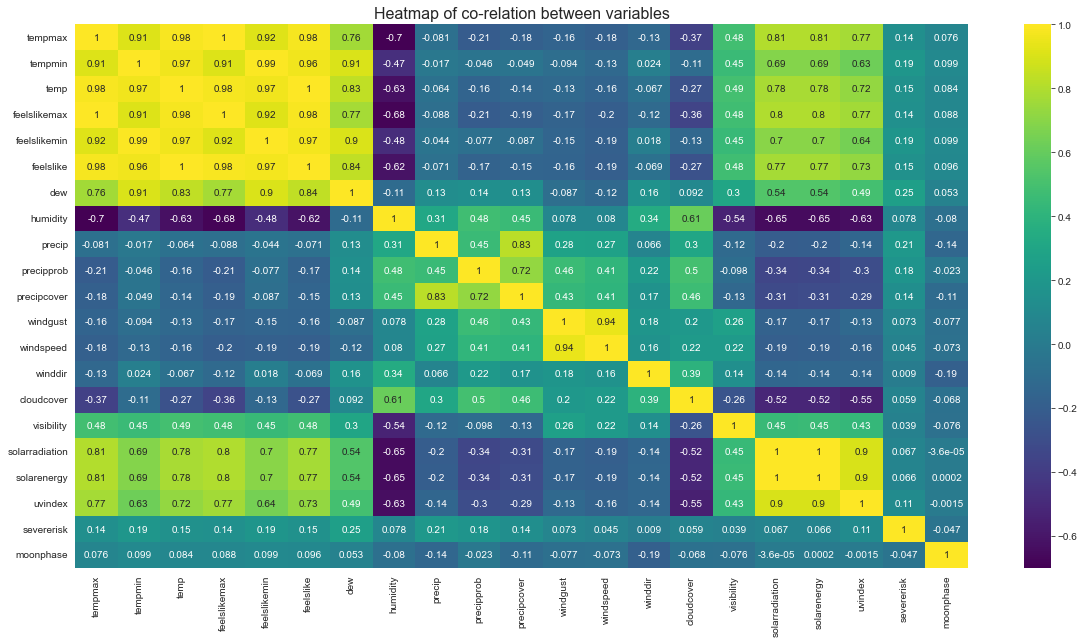

In [33]:
#Use heatmap to see corelation between variables
sns.heatmap(dataset_meteo.corr(),annot=True,cmap='viridis')
plt.title('Heatmap of co-relation between variables',fontsize=16)
plt.show()

By this analysis, we can figures out some importants variables for prediction such as temperature, humidity and solarisation(or solarenergy).

###### Relationship exploration: Continuous Vs Continuous -- Scatter Charts and Interpretation
1. Increasing Trend: This means both variables are positively correlated. In simpler terms, they are directly proportional to each other, if one value increases, other also increases. This is good for ML!
2. Decreasing Trend: This means both variables are negatively correlated. In simpler terms, they are inversely proportional to each other, if one value increases, other decreases. This is also good for ML!
3. No Trend: You cannot see any clear increasing or decreasing trend. This means there is no correlation between the variables. Hence the predictor cannot be used for ML.


In [34]:
df1=dataset_meteo.set_index('datetime').loc[:'2022-08-14']
df1

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windgust,windspeed,winddir,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01,57.1,46.0,50.8,57.1,44.2,49.9,47.3,88.2,0.00,0,...,15.7,8.1,178.3,11.9,9.0,33.6,2.9,2,NaN,0.99
2022-01-02,57.2,49.2,53.3,57.2,47.1,53.0,46.8,78.5,0.01,100,...,33.3,15.2,214.8,24.1,15.1,18.2,1.5,1,NaN,1.00
2022-01-03,54.8,51.4,52.6,54.8,51.4,52.6,48.3,85.5,0.34,100,...,32.5,14.2,223.5,27.0,10.5,18.8,1.7,1,NaN,0.00
2022-01-04,52.6,40.3,47.8,52.6,32.1,44.3,44.6,89.0,0.83,100,...,36.9,16.5,234.9,27.6,11.0,13.3,1.1,1,NaN,0.02
2022-01-05,43.7,35.5,39.4,38.1,28.7,34.1,32.2,75.3,0.00,0,...,29.8,11.5,291.8,4.0,14.4,27.2,2.3,2,NaN,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-30,85.2,64.7,76.2,83.5,64.7,75.7,52.8,45.3,0.00,0,...,21.7,9.0,197.5,7.4,16.3,131.9,11.5,8,10.0,0.01
2022-07-31,82.8,65.5,73.4,83.1,65.5,73.5,59.1,61.9,0.00,0,...,20.8,10.5,280.8,7.3,15.5,163.3,14.0,8,10.0,0.04
2022-08-01,80.0,68.1,73.0,80.5,68.1,73.0,59.1,63.0,0.00,0,...,15.5,7.1,307.8,21.1,16.4,75.8,6.4,4,10.0,0.07


In [43]:
timestep_product_store.shape

(215, 10150)

In [35]:
sums=pd.DataFrame(timestep_product_store.sum(axis=1)) #.set_index('time') #.loc[datetime(2022,6,19) :]
sums.columns=['quantity']
df2=sums #.loc['2022-06-13':]
df2

,quantity
time,
2022-01-01,13439.772866
2022-01-02,13335.149464
2022-01-03,13342.359191
2022-01-04,13307.646600
2022-01-05,13269.082001
...,...
2022-07-30,13482.716900
2022-07-31,13567.771225
2022-08-01,13455.614972


In [36]:
df2.shape

(215, 1)

In [37]:
df1.shape

(215, 21)

In [38]:
QuantityData=df1
QuantityData['quantity']=df2['quantity'].values
QuantityData=QuantityData[['tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed', 'winddir',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk',
       'moonphase','quantity']] #.apply(lambda x: (x-x.mean())/ x.std(), axis=0) # normalize if wanted but not mandatory
QuantityData[['quantity']]

,quantity
datetime,
2022-01-01,13439.772866
2022-01-02,13335.149464
2022-01-03,13342.359191
2022-01-04,13307.646600
2022-01-05,13269.082001
...,...
2022-07-30,13482.716900
2022-07-31,13567.771225
2022-08-01,13455.614972


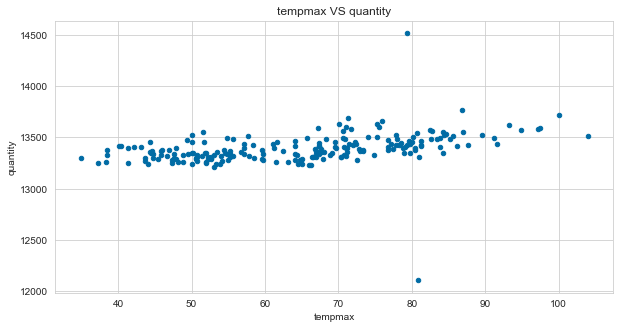

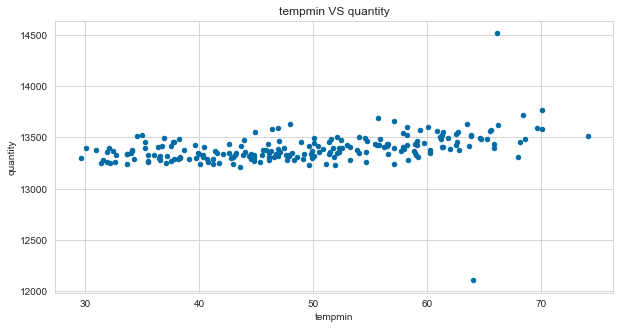

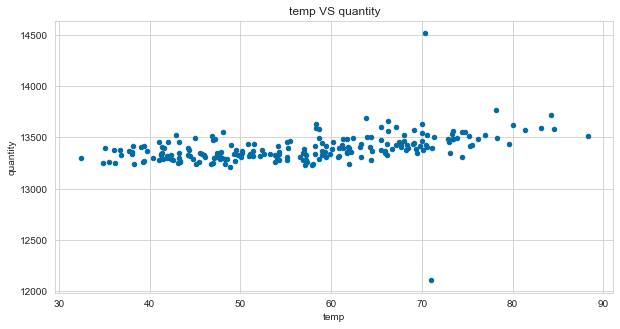

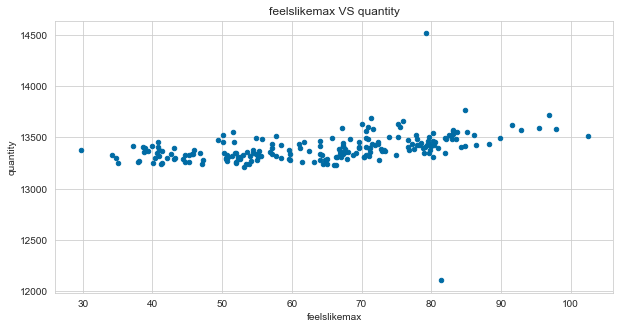

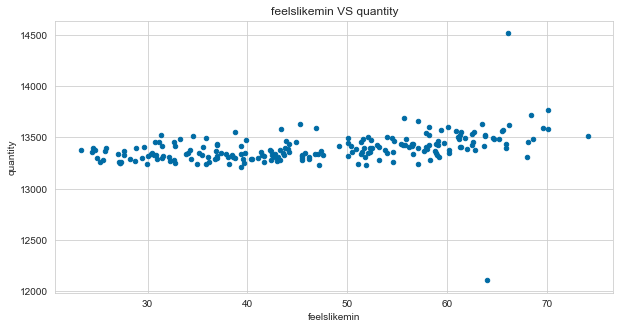

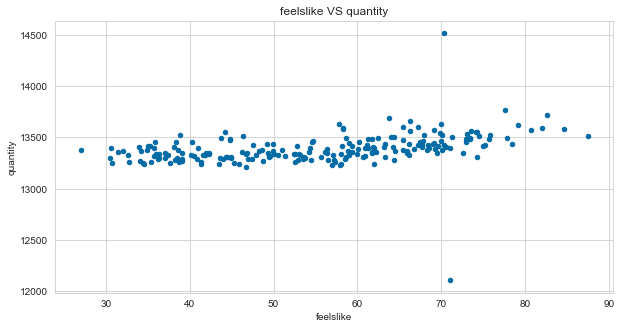

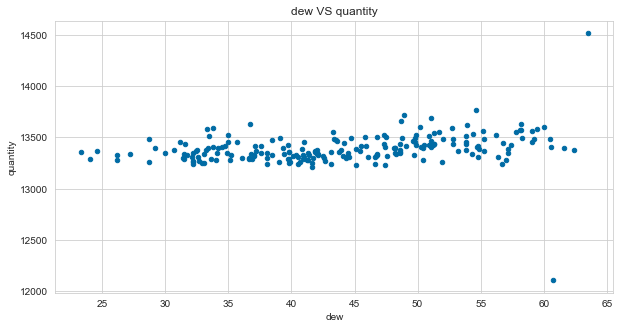

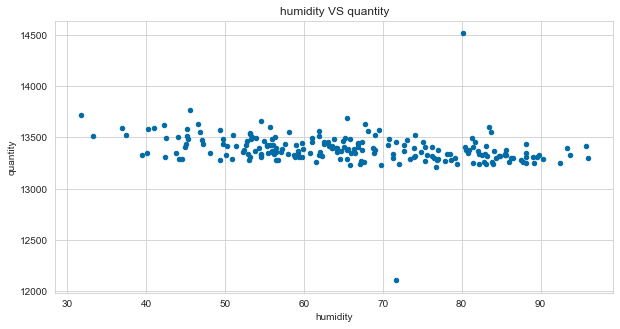

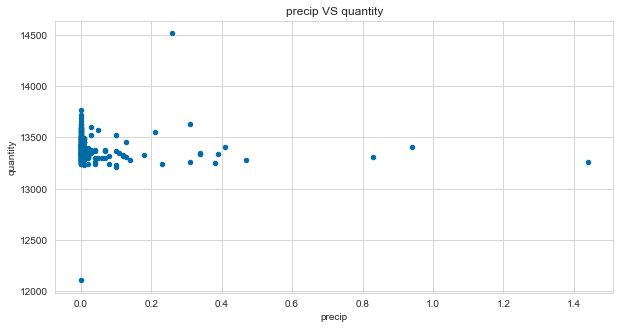

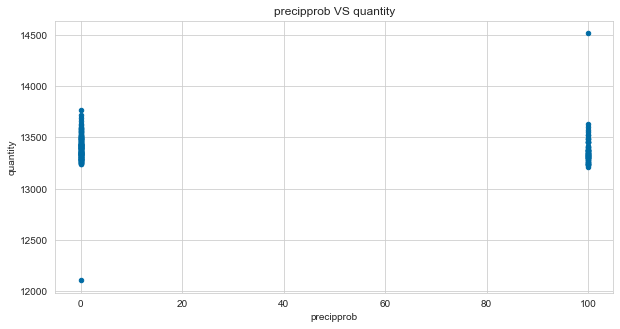

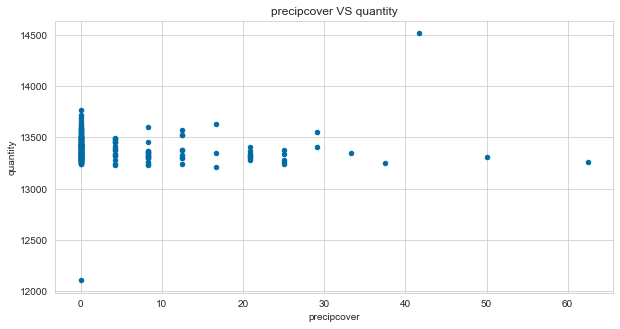

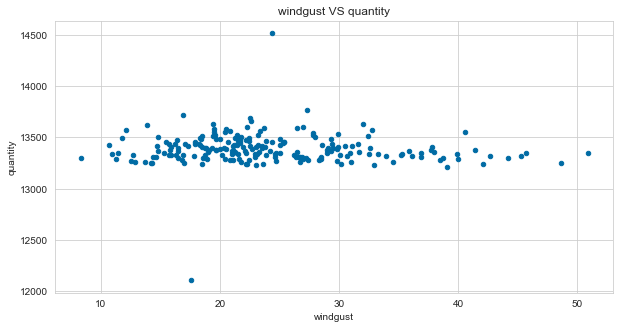

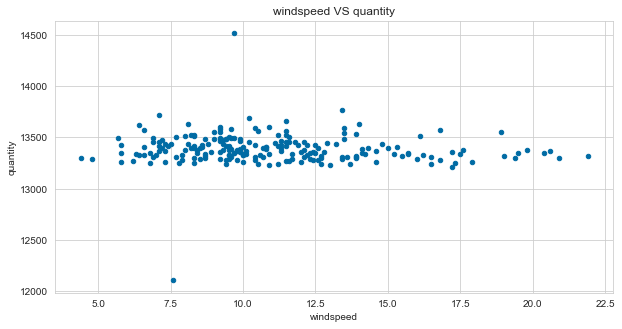

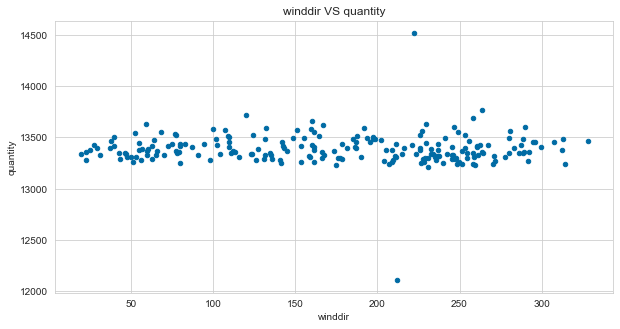

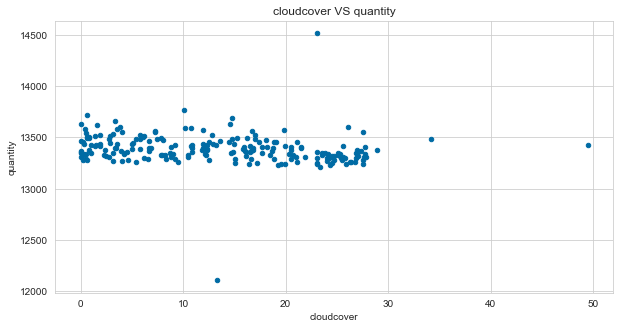

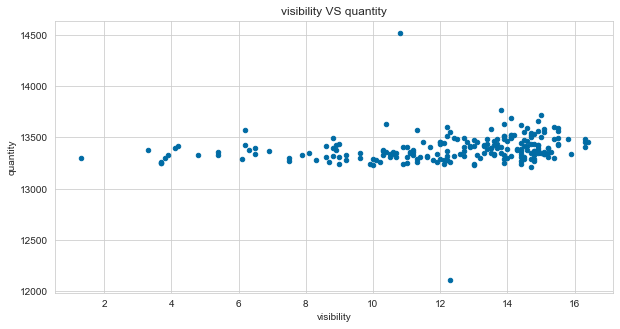

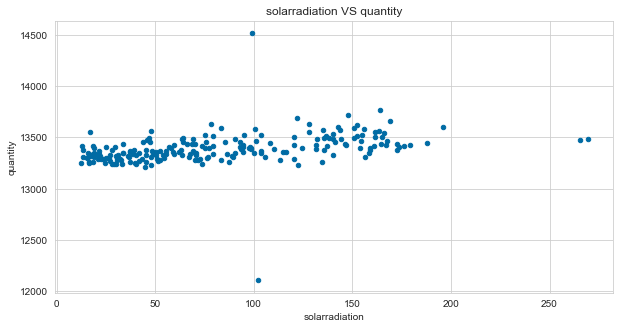

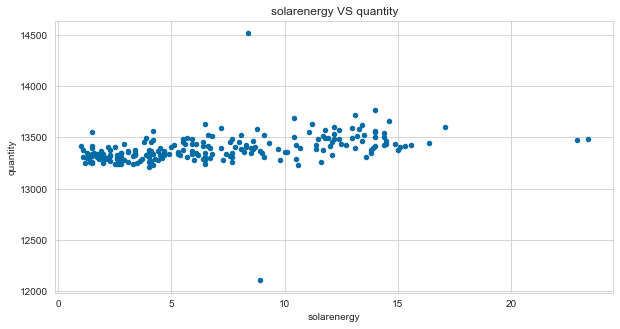

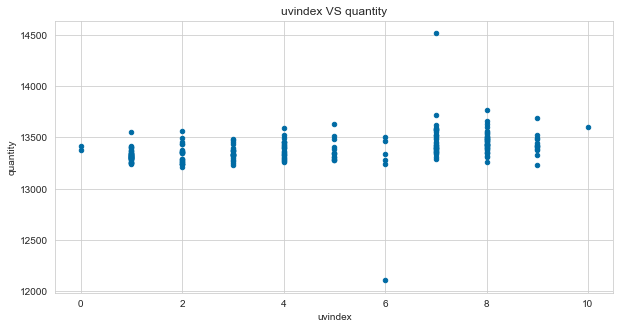

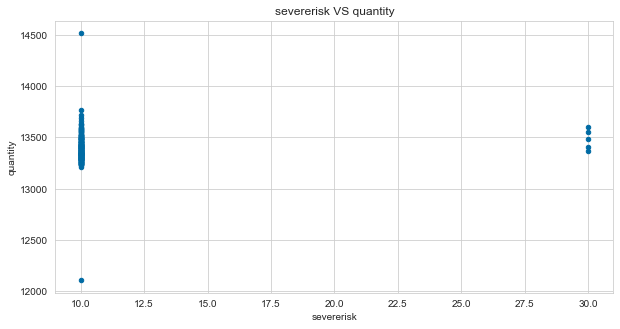

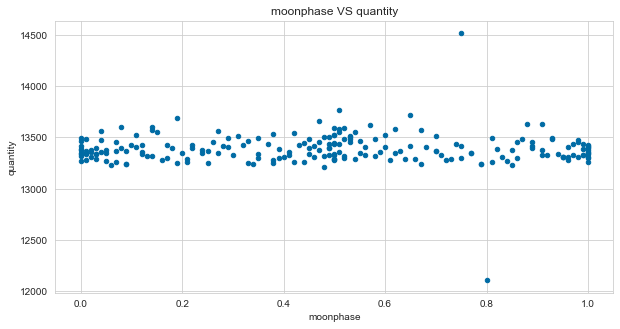

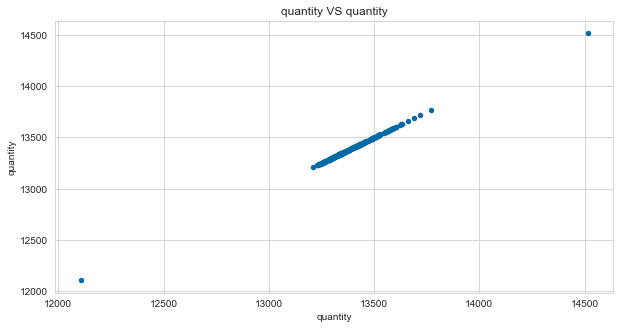

In [48]:
ContinuousCols= ['tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed', 'winddir',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk',
       'moonphase','quantity']

# Plotting scatter chart for each predictor vs the target variable
for predictor in ContinuousCols:
    QuantityData.plot.scatter(x=predictor, y='quantity', figsize=(10,5), title=predictor+" VS "+ 'quantity')

Here we can select, temperature, humidity,solarradiation 

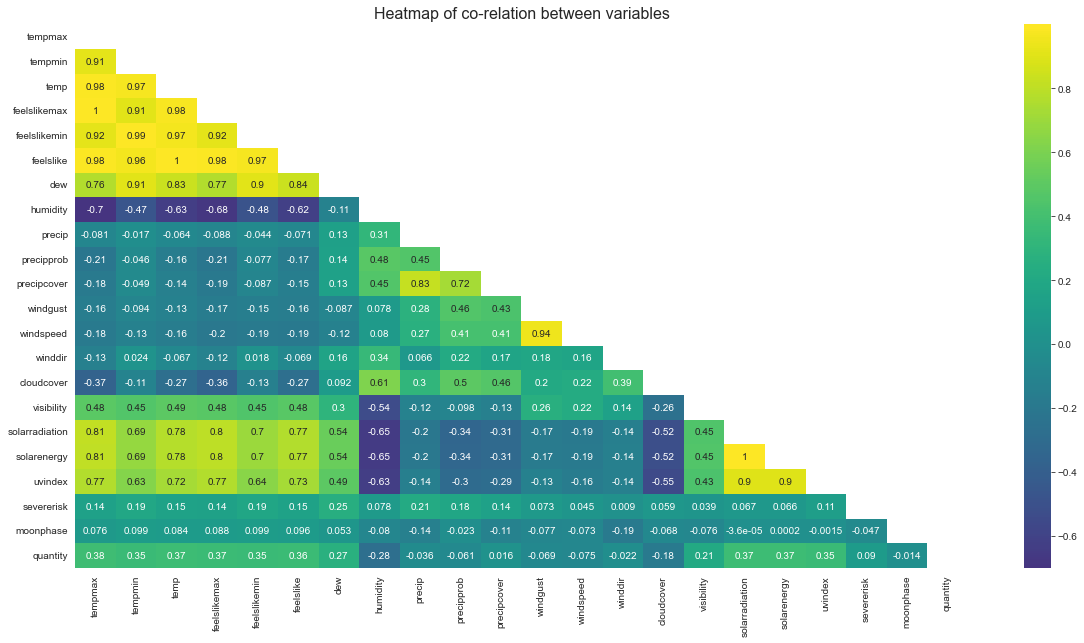

In [49]:
#Use heatmap to see corelation between variables
mask = np.triu(np.ones_like(QuantityData.corr(), dtype=bool))

sns.heatmap(QuantityData.corr(),mask=mask, center=0, annot=True,cmap='viridis') #  cmap='RdBu', linewidths=1, 
plt.title('Heatmap of co-relation between variables',fontsize=16)
plt.show()


temperature,solarradiation(similar to solarenergy),humidity, (the precipitation is not interesting)

In [39]:
DataMeteo=QuantityData[['temp','solarradiation','humidity']].apply(lambda x: (x-x.mean())/ x.std(), axis=0).reset_index() #Normalization as choice
DataMeteo['datetime'] = pd.to_datetime(DataMeteo.datetime, format='%Y-%m-%d')
DataMeteo.columns=['time','temp','solarradiation','humidity']
#DataMeteo=DataMeteo.set_index('time')
DataMeteo

,time,temp,solarradiation,humidity
0,2022-01-01,-0.484950,-0.936615,1.543396
1,2022-01-02,-0.281832,-1.229197,0.872557
2,2022-01-03,-0.338705,-1.217798,1.356668
3,2022-01-04,-0.728690,-1.322291,1.598723
4,2022-01-05,-1.411165,-1.058208,0.651249
...,...,...,...,...
210,2022-07-30,1.578722,0.930969,-1.423510
211,2022-07-31,1.351231,1.527532,-0.275477
212,2022-08-01,1.318732,-0.134865,-0.199402
213,2022-08-02,1.521849,0.923369,-0.676597


In [40]:
def generate_input_meteo(df: pd.DataFrame) -> pd.DataFrame:
    #DataMeteo=DataMeteo.reset_index()
    DataMeteo['time']=pd.to_datetime(DataMeteo['time'], format='%Y-%m-%d')
    
    df['date'] = pd.to_datetime(df.time, format='%Y-%m-%d')
    
    start=DataMeteo['time'].min().date()
    end=df['date'].max()
    
    X= pd.concat([
        df['date'].dt.date,
        df['date'].dt.day,
        #df['date'].dt.month,
        df['date'].dt.weekday,
        df['date'].dt.weekofyear
                 ],axis=1).drop_duplicates()
    X.columns=['time','day','weekday','weekofyear']
    X=X.sort_values(by='time')
    X['time']=pd.to_datetime(X['time'], format='%Y-%m-%d')
    X=X.set_index('time').loc[start:].reset_index()
   
    return X.merge(DataMeteo.set_index('time').loc[:end+timedelta(1)].reset_index(),on='time',how='left')

In [41]:
input_data_m=generate_input_meteo(df)
input_data_m_dar=generate_input_meteo(df)

input_data_m=input_data_m.set_index('time')

input_data_m_dar['time']=pd.to_datetime(input_data_m_dar['time'],format='%Y-%m-%d')

input_data_m

,day,weekday,weekofyear,temp,solarradiation,humidity
time,,,,,,
2022-01-01,1,5,52,-0.484950,-0.936615,1.543396
2022-01-02,2,6,52,-0.281832,-1.229197,0.872557
2022-01-03,3,0,1,-0.338705,-1.217798,1.356668
2022-01-04,4,1,1,-0.728690,-1.322291,1.598723
2022-01-05,5,2,1,-1.411165,-1.058208,0.651249
...,...,...,...,...,...,...
2022-07-30,30,5,30,1.578722,0.930969,-1.423510
2022-07-31,31,6,30,1.351231,1.527532,-0.275477
2022-08-01,1,0,31,1.318732,-0.134865,-0.199402


In [42]:
input_data_m_dar

,time,day,weekday,weekofyear,temp,solarradiation,humidity
0,2022-01-01,1,5,52,-0.484950,-0.936615,1.543396
1,2022-01-02,2,6,52,-0.281832,-1.229197,0.872557
2,2022-01-03,3,0,1,-0.338705,-1.217798,1.356668
3,2022-01-04,4,1,1,-0.728690,-1.322291,1.598723
4,2022-01-05,5,2,1,-1.411165,-1.058208,0.651249
...,...,...,...,...,...,...,...
210,2022-07-30,30,5,30,1.578722,0.930969,-1.423510
211,2022-07-31,31,6,30,1.351231,1.527532,-0.275477
212,2022-08-01,1,0,31,1.318732,-0.134865,-0.199402
213,2022-08-02,2,1,31,1.521849,0.923369,-0.676597


In [43]:
# constants
start_train_date = pd.to_datetime("2022-01-01", format='%Y-%m-%d') 
end_train_date = pd.to_datetime("2022-06-21", format='%Y-%m-%d') 

data_freq='D' 
nb_days_pred = 43 #14

# Possibility to set learning rate and its decay factor
# For now we set them to default values from https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html
lr_decay_factor = 0.5
learning_rate = 0.001
# For the nb of epochs, default is 100 but we set it to less to reduce training time.
# We will train with 100 epochs in the stability study, see variable DEEPAR_MAX_EPOCH_LIST_STR below.
max_epochs = 30
num_eval_samples=100

In [86]:
from collections import defaultdict
feat_dynamic_cols = ['temp','solarradiation','humidity']
# events = holiday.rename(columns={'time': 'ds'})
range_n_pca = [5,10,20]
mon_dico1 = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor','XgBoost','FbProphet','DeepAR']
for n_pca in range_n_pca:
    preds1,metriq1=lin_reg(input_data_m,timestep_product_store,n_pca)
    preds2,metriq2=Multi_svm(input_data_m,timestep_product_store,n_pca)
    preds3,metriq3=RandForest_Regressor(input_data_m,timestep_product_store,n_pca)
    preds4,metriq4=xtremegb(input_data_m,timestep_product_store,n_pca)
    preds5,metriq5=fbprophet_addPredictor_covariable(input_data_m_dar, timestep_product_store,n_pca,feat_dynamic_cols)
    preds6,metriq6=DeepAR_Amazon(input_data_m_dar,timestep_product_store,n_pca,feat_dynamic_cols)
    
    dicts = (metriq1, metriq2,metriq3,metriq4,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico1[key].append(value)
    mon_dico1['Model'].extend(model)
    for j in range(len(model)):
        mon_dico1['n_pca'].append(n_pca)

m1=pd.DataFrame(mon_dico1)
m1

LinReg R2 Valuefor n_pca=: 5 0.07929509318758676
SVM R2 Value for n_pca=: 5 0.1545856146701453
RFRegressor R2 Value over the train set 0.8559846492095609
XgBoost R2 Value for n_pca=:5 0.9999976487258102


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.80807
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       361.675   3.51405e-05       77.0586   4.187e-07       0.001      176  LS failed, Hessian reset 
      99       361.676   9.24778e-06       81.2379      0.7662      0.7662      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       361.678   7.51341e-09       68.5195      0.2504      0.2504      224   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.09295
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.149   7.32177e-06       76.8477           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       351.153   2.45629e-05       87.0499    2.97e-07       0.001      214  LS failed, Hessian reset 
     149       351.154   1.10056e-08       78.4507       0.506       0.506      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.61262
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.269   0.000282995       101.697      0.3743      0.3743      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       349.327   1.21117e-08        95.516      0.7949      0.7949      172   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.85253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       511.616   5.42499e-05       94.2804      0.2124      0.2124      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       512.362   2.57642e-08       67.1257      0.3096      0.3096      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       512.362   7.82985e-09       69.1957      0.1084      0.5228      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.6202
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       337.535    0.00310334        81.698           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       338.923      0.004227       77.5869   4.399e-05       0.001      183  LS failed, Hessian reset 
     169       339.102   0.000124157       81.6618    1.76e-06       0.001      297  LS failed, Hessian reset 
     199       339.109   2.72455e-08         66.66      0.3247      0.3247      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       339.109    1.8094e-08       67.3679      0.2957           1      357   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.57it/s, epoch=1/30, avg_epoch_loss=1.68]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.688 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.678106
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.33it/s, epoch=2/30, avg_epoch_loss=1.53]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.063 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.525539
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.37it/s, epoch=3/30, avg_epoch_loss=1.41]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.055 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.408033
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.96it/s, epoch=4/30, avg_epoch_loss=1.35]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 10 0.0780591003505747
SVM R2 Value for n_pca=: 10 0.16953537047438086
RFRegressor R2 Value over the train set 0.8456108792205642
XgBoost R2 Value for n_pca=:10 0.9999964118533302


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.72257
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.929   0.000783597       88.5391       0.793       0.793      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       362.102   3.11638e-08        70.665           1           1      235   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.76238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       351.637   7.42327e-09       74.2748      0.1997      0.1997      121   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.63977
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.649   1.10037e-05       95.1513      0.9918      0.9918      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       349.649   7.77007e-09       92.6783      0.4002      0.4002      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.72499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       503.155   0.000743749       123.975           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       504.303   0.000465322       115.729     4.5e-06       0.001      243  LS failed, Hessian reset 
     199       504.339   1.37922e-07        77.751      0.3658           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240        504.34    3.6297e-06       89.0617   4.001e-08       0.001      370  LS failed, Hessian reset 
     265        504.34   7.81166e-09        83.638      0.3629           1      407   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.7249
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94        349.84    0.00597845       210.619   5.799e-05       0.001      146  LS failed, Hessian reset 
      99       350.315    0.00246371       112.868           1           1      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       353.937    3.3463e-07        75.692      0.5881      0.5881      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       353.937   1.57541e-06       58.3312   2.724e-08       0.001      345  LS failed, Hessian reset 
     238       353.937    1.2298e-08       65.2297      0.2867           1      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.14073
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       305.361   8.41647e-07       69.3381      0.4283      0.8579      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       305.376   4.34861e-05       82.1543   5.571e-07       0.001      261  LS failed, Hessian reset 
     199       305.382   5.17288e-06        77.735           1           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       305.382   1.91486e-06       81.5819    2.85e-08       0.001      350  LS failed, Hessian reset 
     222       305.382   6.77811e-09       67.5223      0.4109      0.4109      375   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.26996
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       277.182   0.000671371       93.5604           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       277.881   1.11374e-05         82.99      0.5932      0.5932      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       277.892   0.000120168       87.4525    1.39e-06       0.001      310  LS failed, Hessian reset 
     255       277.897   4.13229e-09       84.1055   0.0004882     0.04114      373   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.0777
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       309.855   1.29762e-05       82.8707      0.5798      0.5798      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       310.393   4.99077e-06       82.6151      0.6753      0.6753      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       310.393   8.29835e-09       80.9136      0.4111      0.4111      293   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.65463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       267.865    0.00259727        103.56   2.401e-05       0.001       95  LS failed, Hessian reset 
      99       268.044   1.65854e-07        99.717           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       268.969   3.53127e-05       100.546      0.6095      0.6095      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       268.977   7.13772e-09       99.6046      0.4176      0.4176      348   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.89625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       258.275   0.000238276        102.73   2.351e-06       0.001      148  LS failed, Hessian reset 
      99       258.301   1.35179e-05       95.3258      0.2771      0.2771      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       258.308   1.01605e-05       101.755   1.007e-07       0.001      238  LS failed, Hessian reset 
     173       258.309    1.1126e-08       97.8024           1           1      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.34it/s, epoch=1/30, avg_epoch_loss=1.85]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.487 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.846342
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|███████████| 50/50 [00:03<00:00, 15.85it/s, epoch=2/30, avg_epoch_loss=1.7]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.156 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.704211
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.99it/s, epoch=3/30, avg_epoch_loss=1.62]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.337 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.623905
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.33it/s, epoch=4/30, avg_epoch_loss=1.57]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 20 0.06333293278810968
SVM R2 Value for n_pca=: 20 0.1833650061258327
RFRegressor R2 Value over the train set 0.8426148853962255
XgBoost R2 Value for n_pca=:20 0.9999935320691886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.76613
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.039   2.46407e-05       68.2634           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       361.043   5.23273e-08       64.4681      0.2223      0.9797      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.8046
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.626   2.00937e-06       75.2454      0.5357      0.5357      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       349.629   1.74462e-05       76.1319   2.234e-07       0.001      164  LS failed, Hessian reset 
     136       349.631   1.92539e-08       72.9842       0.769       0.769      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.67843
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.175   3.77036e-07        94.403           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109        350.18   3.07571e-05       105.261   2.965e-07       0.001      173  LS failed, Hessian reset 
     138       350.183   7.36785e-09       99.6034      0.4774      0.4774      210   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.74992
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       500.132    0.00116294       124.977           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       500.571   2.62594e-08       95.3468      0.1782       0.879      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.6542
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       350.012    0.00116321       109.528   1.253e-05       0.001      145  LS failed, Hessian reset 
      99       350.475    0.00353374       89.5959      0.3113           1      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       352.098   9.02249e-09       71.1928      0.3601      0.3601      270   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.56797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       322.737    0.00279787       74.0438       0.998       0.998      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       322.784   2.04918e-08       67.6771      0.4435      0.4435      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       322.784   5.05256e-09       71.4268     0.05445           1      274   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.90304
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       255.894   0.000164616       64.6597           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       256.087   9.82743e-05        83.082      0.1462           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       256.107   8.70689e-05       88.9863   1.017e-06       0.001      349  LS failed, Hessian reset 
     299       256.114    2.1632e-06       87.3439           1           1      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       256.116   1.81002e-05       91.9849   1.624e-07       0.001      487  LS failed, Hessian reset 
     358       256.116   8.54626e-09       67.1196      0.5455      0.5455      524   
Optimization terminat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.14173
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       316.337    0.00135788       72.8037           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       316.383   3.50567e-05       82.1252   3.931e-07       0.001      192  LS failed, Hessian reset 
     199       316.403   4.34095e-05       82.7707           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       316.409   2.79659e-05       81.7687   3.414e-07       0.001      374  LS failed, Hessian reset 
     271        316.41   8.63371e-09       79.5151      0.4218      0.4218      420   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.44532
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       275.727   1.13121e-07        99.477      0.2932           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       275.727   7.81695e-09       104.789      0.2978      0.2978      141   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.68109
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       282.795   1.62849e-07       100.282      0.3684           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       282.795   9.64553e-09       96.7537      0.6062      0.6062      155   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.96558
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       257.717   0.000745468       99.7376      0.7231      0.7231      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       258.038   7.15463e-07       113.158     7.4e-09       0.001      248  LS failed, Hessian reset 
     199       258.038   2.76476e-08       109.084           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       258.405   1.56796e-06       92.1252      0.2027      0.2027      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       258.406   6.76196e-09       87.1536      0.3863      0.3863      429   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.93724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       248.448    1.2811e-07       102.163      0.3826      0.3826      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       248.448   4.29582e-09       86.2464     0.09929     0.09929      140   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.22901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        259.19   2.69599e-06       101.489      0.4291           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       259.243   8.10033e-06       75.3584           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       259.244   8.48285e-09       97.5261      0.7207      0.7207      311   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.06585
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       200.286    0.00119548       92.9574       0.898       0.898      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       200.755   1.20256e-08       102.921      0.2683           1      227   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.0336
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       188.582    0.00478626       97.2019      0.8478      0.8478      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       192.243   3.51679e-08       102.517      0.1887           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       192.243   3.37273e-09        99.666      0.2846      0.2846      245   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.25703
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       205.476   7.31986e-06       109.505           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       207.462   2.19182e-05       100.492      0.5611      0.5611      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       207.531   1.31379e-07       101.065   1.298e-09       0.001      342  LS failed, Hessian reset 
     259       207.531   7.35347e-09       103.183      0.4532      0.4532      352   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.48181
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       213.499   6.23401e-05       96.3188      0.1807      0.6251      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       213.502   2.18649e-07       97.6927   2.377e-09       0.001      236  LS failed, Hessian reset 
     171       213.502   8.07934e-09       94.5223      0.2947      0.2947      242   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.16426
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       217.258   0.000782678       101.716   8.439e-06       0.001      117  LS failed, Hessian reset 
      99       217.368   7.14345e-07       99.0018       0.435       0.435      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       217.368   6.99658e-09       91.8242      0.3495           1      188   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.99085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       259.226   3.44402e-07       95.5411      0.3742           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       259.318   9.57392e-08       88.4137      0.3585           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       259.318   5.67581e-09       85.7079       0.351       0.351      258   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.7681
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       186.043   5.10735e-05       104.345      0.3002      0.3002      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       186.053   6.65726e-09       96.0102      0.3414      0.3414      173   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.67it/s, epoch=1/30, avg_epoch_loss=2.23]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.410 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=2.233431
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.20it/s, epoch=2/30, avg_epoch_loss=2.09]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.088 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.091166
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.39it/s, epoch=3/30, avg_epoch_loss=1.99]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.052 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.993674
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.41it/s, epoch=4/30, avg_epoch_loss=1.98]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

,MSE,MAE,MSLE,R2,Model,n_pca
0,3.515345,0.117921,0.013098,0.079295,LinRegressor,5
1,3.517071,0.122878,0.013339,0.154586,Multi_svm,5
2,3.528431,0.138421,0.014730,0.855985,RFRegressor,5
3,3.563739,0.158639,0.018503,0.999998,XgBoost,5
4,3.515409,0.121692,0.013230,null,FbProphet,5
5,3.517372,0.113714,0.013065,null,DeepAR,5
6,3.513641,0.121377,0.013131,0.078059,LinRegressor,10
7,3.516180,0.128908,0.013539,0.169535,Multi_svm,10
8,3.528417,0.142055,0.014927,0.845611,RFRegressor,10
9,3.588477,0.175396,0.020941,0.999996,XgBoost,10


In [87]:
m1=m1.sort_values(by=['MSE','MAE','MSLE'], ascending=True)
m1

,MSE,MAE,MSLE,R2,Model,n_pca
6,3.513641,0.121377,0.013131,0.078059,LinRegressor,10
12,3.513720,0.123404,0.013186,0.063333,LinRegressor,20
10,3.514873,0.128693,0.013459,null,FbProphet,10
16,3.515081,0.130497,0.013504,null,FbProphet,20
0,3.515345,0.117921,0.013098,0.079295,LinRegressor,5
4,3.515409,0.121692,0.013230,null,FbProphet,5
7,3.516180,0.128908,0.013539,0.169535,Multi_svm,10
1,3.517071,0.122878,0.013339,0.154586,Multi_svm,5
17,3.517372,0.113714,0.013065,null,DeepAR,20
5,3.517372,0.113714,0.013065,null,DeepAR,5


In [88]:
m1.to_latex()

'\\begin{tabular}{lrrrllr}\n\\toprule\n{} &       MSE &       MAE &      MSLE &        R2 &         Model &  n\\_pca \\\\\n\\midrule\n6  &  3.513641 &  0.121377 &  0.013131 &  0.078059 &  LinRegressor &     10 \\\\\n12 &  3.513720 &  0.123404 &  0.013186 &  0.063333 &  LinRegressor &     20 \\\\\n10 &  3.514873 &  0.128693 &  0.013459 &      null &     FbProphet &     10 \\\\\n16 &  3.515081 &  0.130497 &  0.013504 &      null &     FbProphet &     20 \\\\\n0  &  3.515345 &  0.117921 &  0.013098 &  0.079295 &  LinRegressor &      5 \\\\\n4  &  3.515409 &  0.121692 &  0.013230 &      null &     FbProphet &      5 \\\\\n7  &  3.516180 &  0.128908 &  0.013539 &  0.169535 &     Multi\\_svm &     10 \\\\\n1  &  3.517071 &  0.122878 &  0.013339 &  0.154586 &     Multi\\_svm &      5 \\\\\n17 &  3.517372 &  0.113714 &  0.013065 &      null &        DeepAR &     20 \\\\\n5  &  3.517372 &  0.113714 &  0.013065 &      null &        DeepAR &      5 \\\\\n11 &  3.517372 &  0.113714 &  0.013065 &  

### Modification des covariables Météo

In [46]:
from sklearn import svm
from collections import defaultdict
feat_dynamic_cols = ['temp'] # ,'solarradiation','humidity']
# events = holiday.rename(columns={'time': 'ds'})
range_n_pca = [5,10,20]
mon_dico11 = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor','XgBoost','FbProphet','DeepAR']
for n_pca in range_n_pca:
    preds1,metriq1=lin_reg(input_data_m,timestep_product_store,n_pca)
    preds2,metriq2=Multi_svm(input_data_m,timestep_product_store,n_pca)
    preds3,metriq3=RandForest_Regressor(input_data_m,timestep_product_store,n_pca)
    preds4,metriq4=xtremegb(input_data_m,timestep_product_store,n_pca)
    preds5,metriq5=fbprophet_addPredictor_covariable(input_data_m_dar, timestep_product_store,n_pca,feat_dynamic_cols)
    preds6,metriq6=DeepAR_Amazon(input_data_m_dar,timestep_product_store,n_pca,feat_dynamic_cols)
    
    dicts = (metriq1, metriq2,metriq3,metriq4,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico11[key].append(value)
    mon_dico11['Model'].extend(model)
    for j in range(len(model)):
        mon_dico11['n_pca'].append(n_pca)

m11=pd.DataFrame(mon_dico11)
m11

LinReg R2 Valuefor n_pca=: 5 0.07193688118293813
SVM R2 Value for n_pca=: 5 0.14468891663837324
RFRegressor R2 Value over the train set 0.8491065215518013
XgBoost R2 Value for n_pca=:5 0.9999982747902758


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.72434
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       360.032   8.30663e-05         58.12           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       360.039   2.78883e-05       64.8147   4.268e-07       0.001      208  LS failed, Hessian reset 
     159       360.041   5.54368e-07       62.5572   7.483e-09       0.001      297  LS failed, Hessian reset 
     163       360.041   2.36567e-08       44.6511      0.2258           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.74454
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.269   5.56819e-08       79.7819       0.834       0.834      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       350.269   9.85465e-09       80.0356      0.4665      0.4665      140   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.72971
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       343.216   7.51016e-06       77.4233           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       343.232   0.000229497       92.1789           1           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       343.235   6.34164e-05       88.1189    6.55e-07       0.001      298  LS failed, Hessian reset 
     238       343.242   7.60884e-09       70.4072     0.03269     0.03269      347   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.74017
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       508.528   0.000994133       62.5811      0.2806           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       509.108   0.000227403       84.6023    3.16e-06       0.001      207  LS failed, Hessian reset 
     178       509.121   2.67249e-05       44.0165   3.518e-07       0.001      301  LS failed, Hessian reset 
     199       509.122   1.65607e-07       53.1592        1.72      0.5146      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       509.122   7.31103e-08       58.3419      0.3322           1      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.6284
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       346.722      0.017909       117.314      0.2789           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       350.095     0.0048908       78.6101   5.267e-05       0.001      187  LS failed, Hessian reset 
     199       350.373   4.77567e-07       62.5895           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       350.373   8.47267e-08        59.775           1           1      335   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.66it/s, epoch=1/30, avg_epoch_loss=1.64]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.484 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.642134
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.79it/s, epoch=2/30, avg_epoch_loss=1.49]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.169 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.492304
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.98it/s, epoch=3/30, avg_epoch_loss=1.37]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.129 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.370847
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.41it/s, epoch=4/30, avg_epoch_loss=1.28]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 10 0.07643789300658431
SVM R2 Value for n_pca=: 10 0.17566725980879705
RFRegressor R2 Value over the train set 0.839298977852869
XgBoost R2 Value for n_pca=:10 0.9999967436198325


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.71433
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91        359.43   4.49456e-05       73.5393   5.675e-07       0.001      158  LS failed, Hessian reset 
      99       359.437   2.98853e-05       76.4371      0.2269           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       359.444   1.38675e-08       60.7064      0.2989      0.9433      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.75271
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.474   8.78415e-07       69.5614           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       349.503   0.000108481        73.401   1.486e-06       0.001      237  LS failed, Hessian reset 
     199       349.513   6.11711e-08       74.5288           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       349.513   2.05755e-08       69.6484      0.1808           1      310   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.65276
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       344.491   0.000480056       77.7045     0.03222           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       344.498   0.000311136        70.647   4.004e-06       0.001      157  LS failed, Hessian reset 
     148       344.519   3.50611e-05       62.4794   4.127e-07       0.001      267  LS failed, Hessian reset 
     180       344.522   8.76531e-07       67.7872   1.175e-08       0.001      353  LS failed, Hessian reset 
     199       344.523   3.09498e-08        68.412      0.2922           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       344.523   2.98816e-08       81.1536      0.2489           1      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.72181
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        478.27    0.00729631       178.993           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       478.551    0.00107136       110.132   1.061e-05       0.001      186  LS failed, Hessian reset 
     153       478.643    0.00026952       113.579   2.586e-06       0.001      259  LS failed, Hessian reset 
     199       478.679   4.39306e-08       100.475      0.1898           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       478.679   5.19849e-09       99.5668      0.2555      0.2555      326   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.871
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       348.533    0.00147477       89.1979      0.6568      0.6568      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       351.874   7.09992e-06        74.471           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       351.877   1.32716e-05       84.9613   1.422e-07       0.001      369  LS failed, Hessian reset 
     295       351.878   4.93374e-09       83.6509       0.216       0.216      413   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.97144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       329.151   4.95477e-05       76.3233      0.6356      0.6356      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169        329.21   1.49813e-08       67.7542     0.03419           1      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.22453
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63        255.12   0.000330625       94.6708   3.608e-06       0.001      127  LS failed, Hessian reset 
      99       255.143   7.45659e-05       89.4545           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       256.125   8.31884e-05       77.2235   1.118e-06       0.001      322  LS failed, Hessian reset 
     199       256.129   1.91015e-05       68.1087           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       256.132   2.60358e-08       72.8592    3.38e-10       0.001      464  LS failed, Hessian reset 
     270       256.132   9.85608e-09        54.283           1           1      465   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.50631
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       308.421    0.00206127       67.6757           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132        308.59   0.000202924        74.352   2.582e-06       0.001      209  LS failed, Hessian reset 
     175       308.606   4.02764e-05       73.5273   4.832e-07       0.001      296  LS failed, Hessian reset 
     199       308.608   1.93584e-06       76.5226      0.1468           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       308.608   9.63329e-07       73.0683   1.259e-08       0.001      368  LS failed, Hessian reset 
     211       308.608   9.20772e-09       67.7689      0.2004           1      386   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5879
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       275.424   1.22891e-05        67.951       0.597       0.597      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       275.431    8.8862e-05       85.7988   9.754e-07       0.001      182  LS failed, Hessian reset 
     150       275.434   1.42016e-06       78.7343   2.178e-08       0.001      262  LS failed, Hessian reset 
     165       275.434   7.90136e-09       80.0421      0.2083      0.2083      282   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.74266
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       267.803   0.000111696       91.0807      0.6865      0.6865      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       267.829    5.9085e-09       93.0219      0.2413      0.2413      243   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|███████████| 50/50 [00:03<00:00, 15.54it/s, epoch=1/30, avg_epoch_loss=1.9]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.219 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.896289
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 16.73it/s, epoch=2/30, avg_epoch_loss=1.76]
INFO:gluonts.trainer:Epoch[1] Elapsed time 2.989 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.755471
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.19it/s, epoch=3/30, avg_epoch_loss=1.66]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.090 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.655545
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.61it/s, epoch=4/30, avg_epoch_loss=1.58]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 20 0.06283453340941228
SVM R2 Value for n_pca=: 20 0.15746609567933456
RFRegressor R2 Value over the train set 0.843489492757579
XgBoost R2 Value for n_pca=:20 0.9999927081169663


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.64174
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        360.04    4.7936e-05       75.4926      0.4776      0.4776      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       360.118   6.49546e-08        62.892   1.147e-09       0.001      255  LS failed, Hessian reset 
     181       360.118   1.44732e-08       65.2231      0.2599           1      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.8977
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       348.626   1.92628e-08       70.0247      0.1619      0.1619      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       348.626   8.58308e-09        55.327      0.1283      0.1283      144   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.69208
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       342.651    0.00442936       92.7954    4.14e-05       0.001      112  LS failed, Hessian reset 
      99       342.869   3.14803e-06       65.8997           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       342.878   4.25949e-06       77.3274   5.647e-08       0.001      329  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       342.878   2.93272e-08       61.6975   4.535e-10       0.001      413  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.8135
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.607   0.000138666       78.8917      0.3861           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       502.151    0.00015139       97.9653   1.596e-06       0.001      250  LS failed, Hessian reset 
     199       502.175   1.55408e-07       81.3309      0.3179      0.3179      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       502.176   2.40596e-08       95.4757      0.4694      0.4694      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.4664
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       331.119    0.00572269        100.01      0.1921      0.7568      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       332.121   0.000988211       76.8642   1.098e-05       0.001      176  LS failed, Hessian reset 
     172       332.218   2.11782e-07       78.4914   3.021e-09       0.001      289  LS failed, Hessian reset 
     184       332.218   1.77309e-08       63.7296      0.2703           1      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.73781
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       290.392   3.49759e-05       69.0417       0.375           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        290.42   0.000194534       85.3549   2.596e-06       0.001      168  LS failed, Hessian reset 
     174       290.433   2.79704e-05       83.5054   3.265e-07       0.001      288  LS failed, Hessian reset 
     199       290.435   5.00234e-07       75.6304      0.8003      0.8003      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       290.435   9.50137e-09       81.5933      0.3774      0.3774      350   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       288.251   1.70652e-06       96.3854      0.4348      0.4348      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       288.293   0.000339881       76.6299   3.844e-06       0.001      184  LS failed, Hessian reset 
     199       288.326   7.89229e-06       71.4815      0.5043      0.5043      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       288.418    0.00013089       76.9892   1.489e-06       0.001      373  LS failed, Hessian reset 
     299        288.44   9.61896e-06       57.9486      0.8002      0.8002      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327        288.44   3.24459e-09       59.4114     0.07684     0.07684      503   
Optimization terminate

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.93683
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       285.149    0.00280085       77.2913           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       285.489   0.000216266       72.0399   3.083e-06       0.001      255  LS failed, Hessian reset 
     199       285.519   5.32689e-05        81.511           1           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     298       285.527   9.32323e-09       62.1107      0.5815      0.5815      444   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.36704
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        257.74   1.52297e-06       102.281           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       257.743   2.57274e-05       100.267   2.863e-07       0.001      166  LS failed, Hessian reset 
     143       257.744   6.62403e-09       105.406     0.05099     0.05099      214   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.07842
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       286.202   9.01785e-07       101.453   9.214e-09       0.001      160  LS failed, Hessian reset 
      99       286.203   1.07577e-07       103.187      0.4575      0.4575      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       286.204   4.82046e-06       102.675   4.774e-08       0.001      228  LS failed, Hessian reset 
     139       286.204   5.61052e-09       99.1886      0.2848      0.2848      249   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.26308
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       252.848    0.00141258       93.0237       4.022           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       252.899   5.88574e-08       101.314      0.6418      0.6418      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       252.899   4.02118e-09       95.8189     0.05191     0.05191      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.18062
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       223.291    0.00121707       100.343           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       223.347   0.000475476       106.747   4.587e-06       0.001      170  LS failed, Hessian reset 
     199        223.44    0.00237108       99.3092           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       223.708    0.00154551       113.226   1.063e-05       0.001      351  LS failed, Hessian reset 
     299       223.859   0.000365127       99.2919   3.663e-06       0.001      530  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     348       223.878   1.20559e-07       98.9917   1.242e-09       0.001      622 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.63937
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       227.197   0.000135238       94.1057       0.224           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       227.213    6.2848e-09       85.8152      0.2352      0.2352      182   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.94735
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       239.758   0.000359438       92.7786           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       239.779    9.8759e-09       91.3627      0.6231      0.6231      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.03183
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       209.337   7.05285e-06       106.675      0.4948      0.4948      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116        209.36   9.72171e-05        99.942   9.635e-07       0.001      187  LS failed, Hessian reset 
     169       209.372    7.6915e-09       93.4061      0.4654      0.4654      250   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.51698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       240.791   0.000479948       104.867   5.034e-06       0.001      137  LS failed, Hessian reset 
      99       240.834   2.03606e-05        99.956      0.4982      0.4982      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       240.885   0.000305689       104.327   2.932e-06       0.001      257  LS failed, Hessian reset 
     193       240.933   8.52066e-09       91.9283      0.4548      0.4548      315   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.35055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       199.077   1.20435e-07       100.426      0.4601           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       199.077   7.66774e-09       102.402      0.5102      0.5102      136   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.06546
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       251.192   4.90345e-05       100.272           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       251.228   0.000109905       103.655   1.138e-06       0.001      177  LS failed, Hessian reset 
     165       251.268   7.61893e-09       87.0856      0.6464      0.6464      247   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.84626
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       186.036   2.46866e-07       92.9126   2.514e-09       0.001      131  LS failed, Hessian reset 
      88       186.036   5.20321e-09       95.5811        0.65        0.65      157   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.96882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       225.906   6.36157e-07       81.4623      0.1928           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       226.695   1.64027e-05       93.6896      0.5724      0.5724      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       226.696   7.61181e-09       98.9163      0.3853      0.3853      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.38it/s, epoch=1/30, avg_epoch_loss=2.26]
INFO:gluonts.trainer:Epoch[0] Elapsed time 5.335 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=2.256285
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.33it/s, epoch=2/30, avg_epoch_loss=2.16]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.491 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.163133
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.73it/s, epoch=3/30, avg_epoch_loss=2.02]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.652 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=2.023568
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|█████████████| 50/50 [00:03<00:00, 15.03it/s, epoch=4/30, avg_epoch_loss=2]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

,MSE,MAE,MSLE,R2,Model,n_pca
0,3.515480,0.117481,0.013091,0.071937,LinRegressor,5
1,3.517002,0.122318,0.013316,0.144689,Multi_svm,5
2,3.526314,0.137596,0.014475,0.849107,RFRegressor,5
3,3.564076,0.155529,0.018316,0.999998,XgBoost,5
4,3.515575,0.122722,0.013293,null,FbProphet,5
5,3.517372,0.113714,0.013065,null,DeepAR,5
6,3.513781,0.121107,0.013120,0.076438,LinRegressor,10
7,3.515973,0.129793,0.013545,0.175667,Multi_svm,10
8,3.529753,0.143420,0.015055,0.839299,RFRegressor,10
9,3.588551,0.175591,0.021282,0.999997,XgBoost,10


In [50]:
m11=m11.sort_values(by=['MSE','MAE','MSLE'], ascending=True)
m11

,MSE,MAE,MSLE,R2,Model,n_pca
6,3.513781,0.121107,0.013120,0.076438,LinRegressor,10
12,3.513791,0.123416,0.013192,0.062835,LinRegressor,20
16,3.514844,0.129490,0.013479,null,FbProphet,20
10,3.514901,0.129098,0.013503,null,FbProphet,10
0,3.515480,0.117481,0.013091,0.071937,LinRegressor,5
4,3.515575,0.122722,0.013293,null,FbProphet,5
7,3.515973,0.129793,0.013545,0.175667,Multi_svm,10
1,3.517002,0.122318,0.013316,0.144689,Multi_svm,5
11,3.517372,0.113714,0.013065,null,DeepAR,10
17,3.517372,0.113714,0.013065,null,DeepAR,20


In [47]:
from collections import defaultdict
feat_dynamic_cols = ['temp','solarradiation'] #,'humidity']
# events = holiday.rename(columns={'time': 'ds'})
range_n_pca = [5,10,20]
mon_dico12 = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor','XgBoost','FbProphet','DeepAR']
for n_pca in range_n_pca:
    preds1,metriq1=lin_reg(input_data_m,timestep_product_store,n_pca)
    preds2,metriq2=Multi_svm(input_data_m,timestep_product_store,n_pca)
    preds3,metriq3=RandForest_Regressor(input_data_m,timestep_product_store,n_pca)
    preds4,metriq4=xtremegb(input_data_m,timestep_product_store,n_pca)
    preds5,metriq5=fbprophet_addPredictor_covariable(input_data_m_dar, timestep_product_store,n_pca,feat_dynamic_cols)
    preds6,metriq6=DeepAR_Amazon(input_data_m_dar,timestep_product_store,n_pca,feat_dynamic_cols)
    
    dicts = (metriq1, metriq2,metriq3,metriq4,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico12[key].append(value)
    mon_dico12['Model'].extend(model)
    for j in range(len(model)):
        mon_dico12['n_pca'].append(n_pca)

m12=pd.DataFrame(mon_dico12)
m12

LinReg R2 Valuefor n_pca=: 5 0.07410573772176218
SVM R2 Value for n_pca=: 5 0.18061276080793187
RFRegressor R2 Value over the train set 0.844352322098312
XgBoost R2 Value for n_pca=:5 0.9999980246529189


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.72811
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       360.864    2.3609e-05       74.1245           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       360.866    1.7175e-05       100.005   2.178e-07       0.001      189  LS failed, Hessian reset 
     162       360.873   2.69855e-05        71.323   3.218e-07       0.001      289  LS failed, Hessian reset 
     199       360.876   7.82124e-08       64.7581      0.4897      0.4897      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       360.876   1.39182e-07       85.3003   1.671e-09       0.001      406  LS failed, Hessian reset 
     230       360.876   3.12125e-08       69.0039           1           1      415   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.77255
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       348.759   8.50671e-06       70.1964   1.044e-07       0.001      154  LS failed, Hessian reset 
      99       348.759   5.62065e-08       68.2084      0.2622      0.2622      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       348.759   1.37036e-07       68.1914   2.058e-09       0.001      236  LS failed, Hessian reset 
     124       348.759   3.09475e-08       65.6789           1           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.65512
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       342.593   3.03816e-05       76.7438      0.2614           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       342.597   1.10518e-05       69.8304   1.279e-07       0.001      202  LS failed, Hessian reset 
     177       342.598   3.52623e-06       78.4077   3.803e-08       0.001      292  LS failed, Hessian reset 
     199       342.598   6.79616e-09       80.2281     0.05465      0.6464      323   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.80854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       514.475   0.000694523       94.6964           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       514.711   0.000449359       119.329   5.602e-06       0.001      223  LS failed, Hessian reset 
     192       514.741   3.07604e-06       89.6312   3.799e-08       0.001      318  LS failed, Hessian reset 
     199       514.741   3.02945e-07       65.5042      0.3372           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       514.741   7.36173e-09       77.8638     0.07158           1      354   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.7755
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       355.292    0.00139787       107.924      0.2933      0.2933      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       356.073    0.00156112       71.5441   1.509e-05       0.001      172  LS failed, Hessian reset 
     199       356.249     1.152e-05       92.7026      0.3213     0.03213      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       356.274   0.000149193        83.731   1.804e-06       0.001      344  LS failed, Hessian reset 
     299       356.288   2.07255e-07       75.8985      0.5944      0.5944      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       356.288   2.61059e-08       65.8323      0.2207           1      504   
Optimization terminat

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.70it/s, epoch=1/30, avg_epoch_loss=1.67]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.652 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.672070
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.33it/s, epoch=2/30, avg_epoch_loss=1.46]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.492 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.462588
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.31it/s, epoch=3/30, avg_epoch_loss=1.34]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.267 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.343964
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.28it/s, epoch=4/30, avg_epoch_loss=1.27]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 10 0.07483566820941381
SVM R2 Value for n_pca=: 10 0.1900848469933316
RFRegressor R2 Value over the train set 0.8494340247437486
XgBoost R2 Value for n_pca=:10 0.9999973902896041


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.72595
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.169   1.37945e-08       71.7659     0.07976           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       361.213   2.07639e-05       76.5198   2.603e-07       0.001      216  LS failed, Hessian reset 
     163       361.214   6.76563e-09       70.0715       0.203       0.203      257   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.77182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.268   1.86192e-05       76.4997    2.33e-07       0.001      185  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       349.269   1.27502e-08       69.6638      0.2343           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.65784
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.879   2.52833e-05       72.6739     0.04868           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        345.88   4.43701e-06       72.8979   5.579e-08       0.001      194  LS failed, Hessian reset 
     155        345.88   2.96743e-08       76.9962      0.3362           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.7247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       495.343   0.000626311       130.922           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       496.252   0.000262552       146.238   2.208e-06       0.001      165  LS failed, Hessian reset 
     193       496.639   6.80677e-06       82.2448   8.196e-08       0.001      320  LS failed, Hessian reset 
     199       496.639   1.16548e-06       57.9993      0.3095           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       496.639   2.74087e-08       69.5742       1.207      0.2913      369   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.6314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.401     0.0241504       164.553      0.5999           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       353.109   0.000301959        78.416           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       353.191   8.30851e-06       46.4954           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       353.192    7.3077e-06       67.2614   1.157e-07       0.001      412  LS failed, Hessian reset 
     399       353.195   2.67545e-08       57.4603      0.5167      0.5167      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       353.195   7.59746e-09    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.98151
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       329.487   1.76759e-05       72.7647      0.2487      0.2487      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       329.551   5.39034e-06        73.514           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       329.585   3.66194e-06       76.8826      0.6025      0.6025      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       329.588   3.44497e-07       77.7198   4.587e-09       0.001      511  LS failed, Hessian reset 
     383       329.588   5.57145e-09        64.844      0.3597      0.3597      532   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.79596
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63        243.72   0.000174565       85.2438   1.604e-06       0.001      118  LS failed, Hessian reset 
      99       243.746   6.86582e-06        83.427      0.9934      0.9934      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       245.048   0.000169612       59.0947      0.9114      0.9114      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       245.108   7.59648e-05       91.1514   9.802e-07       0.001      360  LS failed, Hessian reset 
     281       245.113   1.94601e-06       66.2164   2.964e-08       0.001      458  LS failed, Hessian reset 
     299       245.114   1.10992e-07       75.0846           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.60454
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       302.028   6.23035e-06       101.971      0.7203      0.7203      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       302.116    0.00040771       93.3466   3.983e-06       0.001      175  LS failed, Hessian reset 
     165       302.153   4.50955e-09       97.9441      0.5001      0.5001      241   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.29592
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       233.848   7.57965e-05       68.7514        0.34        0.34      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       233.969   5.78197e-09       77.9656      0.1664      0.1664      214   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.84775
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       227.187   1.60203e-05       102.952      0.8735      0.8735      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       228.206     0.0105946       99.1446           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       228.699   1.07298e-07        99.096           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       228.699   4.28319e-09       99.6876      0.5115      0.5115      378   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.16it/s, epoch=1/30, avg_epoch_loss=1.86]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.533 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.860199
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.40it/s, epoch=2/30, avg_epoch_loss=1.71]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.249 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.711295
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.20it/s, epoch=3/30, avg_epoch_loss=1.63]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.290 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.627718
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.27it/s, epoch=4/30, avg_epoch_loss=1.56]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 20 0.0636450852604468
SVM R2 Value for n_pca=: 20 0.17614937712521622
RFRegressor R2 Value over the train set 0.834251720205704
XgBoost R2 Value for n_pca=:20 0.9999933130471984


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.74677
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        361.22   0.000524828       69.3661      0.8785      0.8785      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       361.246   2.80527e-05       67.4514    3.76e-07       0.001      230  LS failed, Hessian reset 
     199       361.273   6.52175e-05       81.2193      0.8262      0.8262      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       361.323   1.40491e-05        81.325           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       361.325   6.59309e-09       69.2223     0.02823     0.02823      497   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.69561
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       350.674   3.81988e-05       67.9032   5.859e-07       0.001      130  LS failed, Hessian reset 
      97       350.676   2.78632e-08       66.9524      0.1693           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.64807
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.712   8.86524e-05       62.5181           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       345.774    3.4752e-05       89.5681           1           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       345.776   1.65876e-05       81.6211   2.417e-07       0.001      310  LS failed, Hessian reset 
     229       345.776   2.24617e-08       58.1611      0.9988      0.9988      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.75816
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       487.249   0.000178252       86.5007           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       487.631    0.00057951       131.421    5.96e-06       0.001      196  LS failed, Hessian reset 
     199       488.045   3.43894e-05       71.4883      0.1288           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       488.053     4.489e-07       87.9596    4.59e-09       0.001      416  LS failed, Hessian reset 
     283       488.053   3.94038e-09       97.5242      0.0731      0.0731      434   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.1264
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        349.18    0.00278238       85.6483      0.6636      0.6636      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       350.348   1.29682e-06       77.3958   1.542e-08       0.001      290  LS failed, Hessian reset 
     198       350.348   7.43985e-09       72.3365     0.06442      0.9933      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.55596
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       321.026   2.99812e-06       84.5771           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       321.035   7.22105e-05       89.7805   7.925e-07       0.001      186  LS failed, Hessian reset 
     199       321.046   9.54148e-07       94.6612      0.1521           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       321.086   0.000156043       100.451   1.348e-06       0.001      357  LS failed, Hessian reset 
     299       321.107   8.59493e-06       88.5199      0.0541           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       321.112   7.65253e-09        83.254      0.2065      0.2065      543   
Optimization terminat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.12301
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        244.48   1.05762e-06       82.4849      0.2783           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       244.801    0.00292085       79.6918      0.3645           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       244.991   4.99285e-06       97.6835   6.259e-08       0.001      431  LS failed, Hessian reset 
     299       244.992   9.54497e-08       67.9008      0.6969      0.6969      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       244.992   1.43664e-07       89.6328   1.641e-09       0.001      510  LS failed, Hessian reset 
     318       244.992   8.93871e-09        63.143      0.5057      0.5057      513   
Optimization terminat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.88197
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       297.243   0.000124688       97.2474      0.2775           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       297.407   0.000665266       88.0808           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       297.415   2.21082e-06       77.7965      0.4229           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       297.417   3.25465e-07       93.6338           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       297.417   5.81753e-08       97.3785   6.824e-10       0.001      597  LS failed, Hessian reset 
     461       297.417   8.41547e-09    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.18871
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       296.381   0.000382769       71.6482      0.1562           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       296.523   0.000109446       69.1544   1.282e-06       0.001      234  LS failed, Hessian reset 
     199       296.548   4.93761e-06        75.325      0.9291      0.9291      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       296.573   5.99906e-06       52.2661      0.5718      0.1666      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       296.573   7.61979e-09       54.7703      0.6283      0.6283      454   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.12732
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        247.02   1.32885e-08       94.1558      0.5967      0.5967      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100        247.02    8.5017e-09       95.3529      0.6419      0.6419      132   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.11816
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       251.031   8.18798e-09       94.2675      0.5915      0.5915      114   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.01355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       251.988    0.00203255       102.067           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       252.206   3.33322e-06       100.951           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       252.207   1.23234e-06       109.373   1.224e-08       0.001      276  LS failed, Hessian reset 
     235       252.207   6.89562e-09       104.613      0.5535      0.5535      318   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.96323
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       274.321   7.52141e-06       92.0173      0.3981           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       274.322    9.1935e-09       97.6056     0.06412     0.06412      149   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       233.181   9.78229e-09       102.643      0.2929      0.2929      114   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.97399
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       215.348       1.1e-07        85.315       0.238           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       215.348   8.22139e-09       92.5116      0.5382      0.5382      137   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.65414
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       193.168   3.93745e-06       99.5489           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       193.168   7.61375e-09       104.053       1.519      0.3625      159   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.75257
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       262.393   5.37581e-06       101.127      0.4396           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       262.393   1.39759e-08       93.7674      0.1539           1      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.77526
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       215.278   9.74274e-09        101.14      0.3866      0.3866       82   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.03229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       230.679     0.0083717       101.276           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       230.767   5.90952e-09       97.2587      0.1701      0.1701      169   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.43826
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       218.815   0.000111507       101.204      0.2914           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       218.853    9.0592e-09       91.7934      0.2864      0.2864      188   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.98it/s, epoch=1/30, avg_epoch_loss=2.22]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.578 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=2.223448
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.07it/s, epoch=2/30, avg_epoch_loss=2.11]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.319 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.112110
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.22it/s, epoch=3/30, avg_epoch_loss=2.06]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.286 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=2.058609
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.29it/s, epoch=4/30, avg_epoch_loss=1.98]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

,MSE,MAE,MSLE,R2,Model,n_pca
0,3.515490,0.117758,0.013103,0.074106,LinRegressor,5
1,3.516526,0.122588,0.013309,0.180613,Multi_svm,5
2,3.526893,0.141954,0.014786,0.844352,RFRegressor,5
3,3.564782,0.157815,0.018706,0.999998,XgBoost,5
4,3.515658,0.122489,0.013272,null,FbProphet,5
5,3.517372,0.113714,0.013065,null,DeepAR,5
6,3.513531,0.121077,0.013110,0.074836,LinRegressor,10
7,3.516885,0.130294,0.013586,0.190085,Multi_svm,10
8,3.529740,0.142870,0.015030,0.849434,RFRegressor,10
9,3.584518,0.171784,0.020471,0.999997,XgBoost,10


In [51]:
m12=m12.sort_values(by=['MSE','MAE','MSLE'], ascending=True)
m12

,MSE,MAE,MSLE,R2,Model,n_pca
6,3.513531,0.121077,0.013110,0.074836,LinRegressor,10
12,3.513791,0.123113,0.013176,0.063645,LinRegressor,20
10,3.514642,0.128028,0.013444,null,FbProphet,10
16,3.514865,0.129988,0.013484,null,FbProphet,20
0,3.515490,0.117758,0.013103,0.074106,LinRegressor,5
4,3.515658,0.122489,0.013272,null,FbProphet,5
1,3.516526,0.122588,0.013309,0.180613,Multi_svm,5
7,3.516885,0.130294,0.013586,0.190085,Multi_svm,10
11,3.517372,0.113714,0.013065,null,DeepAR,10
17,3.517372,0.113714,0.013065,null,DeepAR,20


In [48]:
from collections import defaultdict
feat_dynamic_cols = ['solarradiation','humidity']
# events = holiday.rename(columns={'time': 'ds'})
range_n_pca = [5,10,20]
mon_dico13 = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor','XgBoost','FbProphet','DeepAR']
for n_pca in range_n_pca:
    preds1,metriq1=lin_reg(input_data_m,timestep_product_store,n_pca)
    preds2,metriq2=Multi_svm(input_data_m,timestep_product_store,n_pca)
    preds3,metriq3=RandForest_Regressor(input_data_m,timestep_product_store,n_pca)
    preds4,metriq4=xtremegb(input_data_m,timestep_product_store,n_pca)
    preds5,metriq5=fbprophet_addPredictor_covariable(input_data_m_dar, timestep_product_store,n_pca,feat_dynamic_cols)
    preds6,metriq6=DeepAR_Amazon(input_data_m_dar,timestep_product_store,n_pca,feat_dynamic_cols)
    
    dicts = (metriq1, metriq2,metriq3,metriq4,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico13[key].append(value)
    mon_dico13['Model'].extend(model)
    for j in range(len(model)):
        mon_dico13['n_pca'].append(n_pca)

m13=pd.DataFrame(mon_dico13)
m13

LinReg R2 Valuefor n_pca=: 5 0.07342496903840443
SVM R2 Value for n_pca=: 5 0.1659585282841078
RFRegressor R2 Value over the train set 0.837268570025486
XgBoost R2 Value for n_pca=:5 0.9999982497087727


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.69974
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.454   0.000356121       87.5432      0.2766      0.2766      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       362.549   0.000273082       74.9382   3.266e-06       0.001      180  LS failed, Hessian reset 
     177       362.562   4.73161e-07       64.9053   6.477e-09       0.001      311  LS failed, Hessian reset 
     187       362.562    8.7682e-09       68.7859     0.02316           1      327   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.79723
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83        352.12   9.92146e-09       70.9033      0.2087      0.2087      115   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.6323
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.787   1.55735e-07       101.355      0.3041           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        352.31   5.46444e-08       96.7962      0.6582      0.6582      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211        352.31   2.14744e-08       104.912           1           1      266   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.75352
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       487.078    0.00138493       192.705           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       488.066   8.91006e-06       64.5456       0.237           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246        488.07   5.24237e-07       71.2804   6.779e-09       0.001      334  LS failed, Hessian reset 
     254        488.07   1.37948e-08       54.1798      0.4541      0.4541      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.8698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.789      0.010597       107.981           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       352.901   0.000131599       77.2278       0.277           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       352.949   0.000265558        63.138   3.282e-06       0.001      338  LS failed, Hessian reset 
     289       352.968   4.08103e-06       56.0797   5.583e-08       0.001      452  LS failed, Hessian reset 
     299       352.968   5.35139e-07        69.019      0.2852           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       352.968   1.37815e-08       68.1107       0.307       0.307      506   
Optimization terminat

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|███████████| 50/50 [00:03<00:00, 13.90it/s, epoch=1/30, avg_epoch_loss=1.7]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.599 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.697941
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.47it/s, epoch=2/30, avg_epoch_loss=1.57]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.458 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.565158
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.23it/s, epoch=3/30, avg_epoch_loss=1.44]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.514 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.440699
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.44it/s, epoch=4/30, avg_epoch_loss=1.33]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 10 0.08114240295929546
SVM R2 Value for n_pca=: 10 0.18573212232662467
RFRegressor R2 Value over the train set 0.8397180449716855
XgBoost R2 Value for n_pca=:10 0.9999964126517265


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.72525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.738   0.000234051       78.4516      0.8421      0.8421      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       361.747   1.48452e-06       74.1854   1.882e-08       0.001      230  LS failed, Hessian reset 
     157       361.747   7.84818e-09       65.5954      0.5495      0.5495      256   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.77027
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.604   1.05213e-05       63.2911           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       351.773   2.67351e-06       68.4128   2.783e-08       0.001      288  LS failed, Hessian reset 
     199       351.774   3.30601e-07       72.1869       0.365           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       351.774   6.41675e-07       58.0647   6.566e-09       0.001      386  LS failed, Hessian reset 
     243       351.774    6.0506e-09       65.1889     0.03998           1      399   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.66002
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.054    0.00414065       97.3261           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       350.119   4.04631e-05       100.518   4.465e-07       0.001      189  LS failed, Hessian reset 
     156       350.122   8.01203e-09       101.058      0.1595      0.1595      224   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.85032
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.522   5.13483e-05       86.5677      0.6012      0.6012      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       492.544   1.94465e-05       86.0628   2.115e-07       0.001      201  LS failed, Hessian reset 
     199       492.549   5.28993e-08       94.6157      0.6703      0.6703      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       492.673   1.30996e-05       65.2202      0.0168           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        492.69   6.31421e-05       78.8801           1           1      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       492.697    6.2026e-06    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.6738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        350.56   0.000721973       83.6456       0.405       0.405      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       351.388    0.00364818       201.015   3.969e-05       0.001      172  LS failed, Hessian reset 
     160       351.607   2.10731e-06       53.0368   3.224e-08       0.001      283  LS failed, Hessian reset 
     173       351.607   3.06625e-08       46.2055     0.08164           1      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.19543
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       318.534   4.85129e-06       64.1626      0.9754      0.9754      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       318.534    1.0703e-08       43.9277      0.3195           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.9564
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       263.389   0.000115212       92.4579   1.248e-06       0.001      142  LS failed, Hessian reset 
      99       263.395   2.25024e-05       77.8386           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       263.397   2.08229e-06       87.0772   2.662e-08       0.001      242  LS failed, Hessian reset 
     165       263.397   1.44383e-08        83.165     0.05967           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.66669
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       321.448   1.39465e-06       81.6077      0.5298      0.5298      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       321.449   4.56842e-09       74.3326      0.1804      0.1804      189   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5052
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       237.521    5.9664e-06       111.642           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       237.521   6.32909e-06       104.384   5.895e-08       0.001      157  LS failed, Hessian reset 
     129       237.522   5.55595e-07       103.195   6.106e-09       0.001      226  LS failed, Hessian reset 
     150       237.522   1.79207e-08       94.9071      0.3643           1      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.97044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63        277.31     0.0001771       100.043    1.64e-06       0.001      123  LS failed, Hessian reset 
      99       277.335   4.37394e-06       97.7821      0.1426           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       277.335   1.00715e-06       99.4392    1.03e-08       0.001      206  LS failed, Hessian reset 
     113       277.335   5.63902e-09       100.124      0.1418      0.1418      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.57it/s, epoch=1/30, avg_epoch_loss=1.86]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.686 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.861111
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.54it/s, epoch=2/30, avg_epoch_loss=1.74]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.442 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.738619
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.75it/s, epoch=3/30, avg_epoch_loss=1.66]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.394 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.657619
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|███████████| 50/50 [00:03<00:00, 14.42it/s, epoch=4/30, avg_epoch_loss=1.6]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 20 0.060752398737735955
SVM R2 Value for n_pca=: 20 0.18482127211759078
RFRegressor R2 Value over the train set 0.8372928045594727
XgBoost R2 Value for n_pca=:20 0.999993321728385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.71779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.268   2.17249e-05       54.5009      0.4791      0.4791      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       361.326    8.0514e-09        77.404      0.4465      0.4465      242   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.77357
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.723    0.00034309       65.7149      0.8565      0.8565      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       350.776   0.000142292       70.5769           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       350.797   0.000201224       88.2637   2.606e-06       0.001      308  LS failed, Hessian reset 
     265       350.819   2.95937e-08       70.7393           1           1      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.60239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       352.721   1.04166e-06       97.0587           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       352.721   2.17943e-08       97.7646           1           1      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.62923
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.398    0.00292661       77.9188           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       489.641   0.000529457       173.467   5.283e-06       0.001      261  LS failed, Hessian reset 
     199       489.698   0.000316691       100.954           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262        489.77   3.77474e-08        53.943     0.01414           1      391   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.9971
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.548    0.00235847        87.277      0.8581      0.8581      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       351.062   9.35187e-07       72.3517      0.5386      0.5386      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282        351.09    2.2864e-05       77.4348    3.61e-07       0.001      397  LS failed, Hessian reset 
     299       351.095   6.94102e-07       57.8637      0.5113      0.5113      420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       351.098   7.90823e-06       68.4569   1.021e-07       0.001      497  LS failed, Hessian reset 
     399       351.099   7.91362e-07       58.0649      0.3797           1      584   
    Iter      log pro

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.4258
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        327.63   0.000227303       59.6538     0.07291           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       327.698   6.80949e-09       53.6498       0.014           1      216   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.51574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       238.465    0.00179101       98.0861      0.7954      0.7954      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       238.684   2.65193e-06       91.1101           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       238.709   1.25249e-07       81.1164       0.758       0.758      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       238.709   1.05684e-06        96.408   1.196e-08       0.001      474  LS failed, Hessian reset 
     367       238.709   1.97387e-08        78.784       0.103      0.5045      492   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.21399
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       318.062   1.68541e-05       86.7396      0.2572      0.2572      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       318.132   0.000594944       95.9093   6.266e-06       0.001      198  LS failed, Hessian reset 
     199       318.182   7.22917e-06       101.657           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       318.182   3.03275e-06       90.4278    3.03e-08       0.001      333  LS failed, Hessian reset 
     236       318.182   8.91205e-09       73.2438      0.2842           1      374   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.19318
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       263.476   4.73649e-06       96.3161           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       263.483   5.77088e-05       97.5971    5.65e-07       0.001      182  LS failed, Hessian reset 
     166       263.491   6.82363e-09       98.9426      0.4625      0.4625      258   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.7319
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       240.645   7.82592e-05       102.577      0.3145           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       240.646   2.68385e-05       100.004   2.647e-07       0.001      169  LS failed, Hessian reset 
     131       240.649   7.80046e-09       102.208      0.3906      0.3906      210   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.51716
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       202.283   4.14748e-07       107.075           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        202.38   0.000478624       105.889   4.349e-06       0.001      166  LS failed, Hessian reset 
     145       202.416   4.04871e-09       100.107      0.1992      0.1992      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.50463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        263.13   0.000148822        84.169           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       263.171   3.42607e-07        101.97      0.5775      0.5775      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       263.171   4.85333e-09       102.783      0.4743      0.4743      263   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.95734
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       271.773   4.92918e-05       95.2258      0.2197           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       272.297   1.50842e-07       97.6985      0.2656           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       272.297    6.6303e-09       100.121      0.6203      0.6203      256   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.68668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       231.213   0.000249334       103.611           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       231.935   1.95498e-05       100.617      0.9354      0.9354      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251        231.95   6.49681e-09       100.735      0.5368      0.5368      302   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.48285
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       207.839    0.00212083       97.6517           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       208.691   3.84351e-07        104.09           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       208.691   6.48215e-09       94.3375      0.3669      0.3669      249   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.37642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       201.664   1.16495e-06       100.999      0.4771      0.4771      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       201.664   6.01511e-09       98.1567      0.1118      0.1118      167   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.46067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       184.992   3.38455e-08       96.1926      0.2223      0.2223      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        185.56    0.00223674       100.408      0.2703           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       185.629      5.87e-09       100.375      0.2222      0.2222      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.53959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       213.436   0.000859295       105.272   8.196e-06       0.001      142  LS failed, Hessian reset 
      99       213.536   2.32879e-06       95.8601           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       213.537   8.99532e-09       98.8677      0.3193      0.3193      207   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.76648
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       209.743   0.000223143       106.083      0.4433      0.4433      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.085   2.27994e-06       100.821      0.7184      0.7184      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       211.182   0.000390802       109.474   3.716e-06       0.001      332  LS failed, Hessian reset 
     299       211.212   1.39257e-07       103.371      0.7055      0.7055      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       211.212   3.48376e-09       88.3134      0.1958      0.1958      393   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.74668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       201.026    4.1975e-05       95.5208        0.17      0.4044      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       201.057   8.76378e-09       87.2387      0.4382      0.4382      220   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|███████████| 50/50 [00:03<00:00, 13.82it/s, epoch=1/30, avg_epoch_loss=2.2]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.620 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=2.202000
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.96it/s, epoch=2/30, avg_epoch_loss=2.04]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.585 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.043663
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|█████████████| 50/50 [00:03<00:00, 15.23it/s, epoch=3/30, avg_epoch_loss=2]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.285 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=2.004861
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.05it/s, epoch=4/30, avg_epoch_loss=1.95]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

,MSE,MAE,MSLE,R2,Model,n_pca
0,3.515554,0.117715,0.013098,0.073425,LinRegressor,5
1,3.516412,0.121283,0.013246,0.165959,Multi_svm,5
2,3.527579,0.141405,0.014764,0.837269,RFRegressor,5
3,3.560169,0.154678,0.017917,0.999998,XgBoost,5
4,3.515578,0.120878,0.013214,null,FbProphet,5
5,3.517372,0.113714,0.013065,null,DeepAR,5
6,3.513578,0.121729,0.013134,0.081142,LinRegressor,10
7,3.516947,0.131425,0.013651,0.185732,Multi_svm,10
8,3.530347,0.142487,0.015074,0.839718,RFRegressor,10
9,3.577440,0.169359,0.019849,0.999996,XgBoost,10


In [52]:
m13=m13.sort_values(by=['MSE','MAE','MSLE'], ascending=True)
m13

,MSE,MAE,MSLE,R2,Model,n_pca
6,3.513578,0.121729,0.013134,0.081142,LinRegressor,10
12,3.513884,0.122934,0.013170,0.060752,LinRegressor,20
10,3.515147,0.129139,0.013482,null,FbProphet,10
16,3.515256,0.130639,0.013551,null,FbProphet,20
0,3.515554,0.117715,0.013098,0.073425,LinRegressor,5
4,3.515578,0.120878,0.013214,null,FbProphet,5
1,3.516412,0.121283,0.013246,0.165959,Multi_svm,5
7,3.516947,0.131425,0.013651,0.185732,Multi_svm,10
11,3.517372,0.113714,0.013065,null,DeepAR,10
5,3.517372,0.113714,0.013065,null,DeepAR,5


In [49]:
from collections import defaultdict
feat_dynamic_cols = ['solarradiation'] #,'humidity']
# events = holiday.rename(columns={'time': 'ds'})
range_n_pca = [5,10,20]
mon_dico14 = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor','XgBoost','FbProphet','DeepAR']
for n_pca in range_n_pca:
    preds1,metriq1=lin_reg(input_data_m,timestep_product_store,n_pca)
    preds2,metriq2=Multi_svm(input_data_m,timestep_product_store,n_pca)
    preds3,metriq3=RandForest_Regressor(input_data_m,timestep_product_store,n_pca)
    preds4,metriq4=xtremegb(input_data_m,timestep_product_store,n_pca)
    preds5,metriq5=fbprophet_addPredictor_covariable(input_data_m_dar, timestep_product_store,n_pca,feat_dynamic_cols)
    preds6,metriq6=DeepAR_Amazon(input_data_m_dar,timestep_product_store,n_pca,feat_dynamic_cols)
    
    dicts = (metriq1, metriq2,metriq3,metriq4,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico14[key].append(value)
    mon_dico14['Model'].extend(model)
    for j in range(len(model)):
        mon_dico14['n_pca'].append(n_pca)

m14=pd.DataFrame(mon_dico14)
m14

LinReg R2 Valuefor n_pca=: 5 0.07426969166237418
SVM R2 Value for n_pca=: 5 0.15902502605789598
RFRegressor R2 Value over the train set 0.8250567940049904
XgBoost R2 Value for n_pca=:5 0.9999983092742337


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.66189
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       361.277   1.15454e-08       79.1269      0.3331           1      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.89558
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       348.321   0.000370203       71.4563       0.751       0.751      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       348.339   8.31118e-07       56.3842           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221        348.34   7.98894e-07       66.9316   1.077e-08       0.001      335  LS failed, Hessian reset 
     230        348.34    5.0868e-09         62.43      0.1265      0.1265      349   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.83298
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       342.314   0.000244695       59.9149       0.328       0.328      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       342.334   1.00156e-06       78.4594   1.121e-08       0.001      288  LS failed, Hessian reset 
     198       342.334   9.96427e-09       65.6864     0.03838           1      303   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.7932
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       488.549   0.000674854       74.1407      0.2659           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       488.712   1.06245e-06       83.5168   1.086e-08       0.001      256  LS failed, Hessian reset 
     192       488.712   1.71471e-08       84.2546      0.2792           1      277   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.1568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       306.894    0.00152758       61.0143      0.3302           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       307.035   3.67515e-05       65.3463   5.775e-07       0.001      211  LS failed, Hessian reset 
     171       307.036   1.44573e-08       54.6682      0.2463           1      263   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.57it/s, epoch=1/30, avg_epoch_loss=1.69]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.980 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.689487
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.06it/s, epoch=2/30, avg_epoch_loss=1.49]
INFO:gluonts.trainer:Epoch[1] Elapsed time 4.974 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.488929
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.53it/s, epoch=3/30, avg_epoch_loss=1.38]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.446 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.381555
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|███████████| 50/50 [00:03<00:00, 15.22it/s, epoch=4/30, avg_epoch_loss=1.3]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 10 0.07683254651878882
SVM R2 Value for n_pca=: 10 0.15599894858110055
RFRegressor R2 Value over the train set 0.8249977552158047
XgBoost R2 Value for n_pca=:10 0.9999965513377488


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.7011
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       360.746   0.000434293       86.1715   5.385e-06       0.001      130  LS failed, Hessian reset 
      99       360.775   2.44124e-06       79.8997     0.08139           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       360.775   9.19508e-07       83.3689   1.148e-08       0.001      247  LS failed, Hessian reset 
     144       360.775   7.91377e-09       69.1648      0.1033           1      269   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.79139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       348.571   8.78392e-05       80.5534   1.218e-06       0.001      172  LS failed, Hessian reset 
      99       348.577   5.17519e-06       66.7464       1.122      0.1122      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       348.583   2.51663e-05       81.4106    2.95e-07       0.001      306  LS failed, Hessian reset 
     199       348.586   7.26632e-07       74.0439      0.2833           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       348.587   3.83771e-07       68.8013   7.019e-09       0.001      406  LS failed, Hessian reset 
     231       348.587   3.89214e-09       56.3008     0.09151           1      422   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.64335
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       344.682    0.00142114       57.2286   1.827e-05       0.001      131  LS failed, Hessian reset 
      99       344.811    0.00028418        68.469           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       344.918   5.07007e-06       89.9289      0.7523      0.7523      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       344.919   3.00988e-06       80.7713    4.06e-08       0.001      372  LS failed, Hessian reset 
     281        344.92   3.81728e-06        82.725   3.955e-08       0.001      474  LS failed, Hessian reset 
     299        344.92   1.10983e-07       77.8888       0.726       0.277      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.67896
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       504.553    0.00194325         114.7           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       504.803   2.41662e-08       62.7608      0.4888      0.4888      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.6128
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        350.34     0.0024374       94.1194      0.6265      0.6265      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116        351.21   0.000878882       89.5882    1.24e-05       0.001      189  LS failed, Hessian reset 
     173        351.37    2.1432e-08       65.3867      0.6067           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.2529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40       319.495    0.00166923       86.0251   2.059e-05       0.001      107  LS failed, Hessian reset 
      99        319.62   1.97523e-05       79.3463       0.813       0.813      194   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       319.995   0.000199049       66.8319      0.2188           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       320.169   1.51259e-06       64.8998           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       320.171   2.06946e-07       65.8044   2.492e-09       0.001      552  LS failed, Hessian reset 
     369       320.171   3.86479e-08       77.1566           1           1      563   
Optimization terminate

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.33527
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       249.379   9.17738e-05       66.9933      0.6338      0.6338      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       249.397   1.62689e-05       79.6872   2.339e-07       0.001      225  LS failed, Hessian reset 
     175       249.398   1.42277e-08       71.1836      0.0481           1      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.2817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       322.443   0.000618836       74.4648      0.2667           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       322.458   1.60013e-05       86.4689   2.191e-07       0.001      225  LS failed, Hessian reset 
     154       322.459   4.70402e-09       73.4752      0.2624     0.02624      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.03374
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       262.034   7.24038e-07       98.7914      0.2961      0.2961      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       262.287   0.000166974       77.9014   2.899e-06       0.001      293  LS failed, Hessian reset 
     199       262.312   3.65644e-05       66.5775      0.3735      0.3735      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270        262.33   5.89154e-09       78.2448      0.1964      0.1964      401   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.16376
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       257.697   2.18163e-05       96.4038   2.217e-07       0.001      151  LS failed, Hessian reset 
      99       257.699   4.06357e-07       95.8974      0.1848      0.1848      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       257.699   4.42376e-09       102.751      0.4053      0.4053      196   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|███████████| 50/50 [00:03<00:00, 14.05it/s, epoch=1/30, avg_epoch_loss=1.9]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.561 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.899318
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.74it/s, epoch=2/30, avg_epoch_loss=1.77]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.394 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.772039
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|███████████| 50/50 [00:03<00:00, 13.94it/s, epoch=3/30, avg_epoch_loss=1.7]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.593 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.695822
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.55it/s, epoch=4/30, avg_epoch_loss=1.62]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 20 0.06199257536239196
SVM R2 Value for n_pca=: 20 0.17141057387920416
RFRegressor R2 Value over the train set 0.8253229913149361
XgBoost R2 Value for n_pca=:20 0.9999925972664174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.75099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.449   3.34879e-07       74.0461      0.1095      0.6008      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       361.465   2.21061e-05       69.8631   3.163e-07       0.001      214  LS failed, Hessian reset 
     167       361.467   6.00667e-09       73.2071      0.2975      0.2975      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.87014
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       347.222   3.63046e-05       67.5514      0.8484      0.8484      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       347.226   1.78966e-08       64.8425      0.3953           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.73294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       337.971   0.000287887       87.8583   2.585e-06       0.001      130  LS failed, Hessian reset 
      99       337.993   1.10631e-05       85.6685        0.74           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       337.995   2.13559e-06       92.5443   2.105e-08       0.001      278  LS failed, Hessian reset 
     190       337.995   2.59593e-09        91.093      0.1787      0.1787      317   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.61394
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       519.854   0.000833072       76.1152      0.7388      0.7388      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       519.996   0.000229426       156.419   1.952e-06       0.001      206  LS failed, Hessian reset 
     178       520.017   2.81406e-05       82.6554   3.879e-07       0.001      317  LS failed, Hessian reset 
     199       520.021   2.83234e-07       59.0147      0.1607           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       520.021   5.09598e-07       74.3361   6.316e-09       0.001      397  LS failed, Hessian reset 
     227       520.021   1.43689e-08       72.2898      0.3168      0.3168      408   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.9993
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       344.508    0.00176421       82.4236           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       344.845    0.00247591       163.232   2.768e-05       0.001      173  LS failed, Hessian reset 
     161       345.189   0.000627577       77.5135   6.804e-06       0.001      301  LS failed, Hessian reset 
     199       345.212   2.08641e-06       57.8736      0.9403      0.9403      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       345.212     7.262e-09       72.3518      0.1134        0.29      385   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.9139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       318.502   1.94759e-05       68.6256           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        318.55    1.6569e-05       87.9367      0.9989      0.9989      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       318.561   2.84409e-06       71.3431   4.193e-08       0.001      376  LS failed, Hessian reset 
     290       318.562   1.49303e-09       87.3372   0.0001166      0.1928      415   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.13543
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       248.958   3.59233e-05       57.0995           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       248.966   5.10362e-05       76.0773   7.221e-07       0.001      243  LS failed, Hessian reset 
     199       248.968   3.74232e-07       77.4854     0.05452           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       248.968   2.76233e-08       88.8052           1           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.68319
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       314.037    0.00021427       93.4685   2.057e-06       0.001      125  LS failed, Hessian reset 
      99       314.056   5.69409e-06       81.9277           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       314.069   3.56895e-05       89.3997   3.545e-07       0.001      259  LS failed, Hessian reset 
     199       314.073   8.37228e-08       95.4688      0.5286      0.5286      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       314.331   1.25692e-05       79.1134      0.4709      0.4709      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       314.336    1.7062e-05       72.8589   2.265e-07       0.001      586  LS failed, Hessian rese

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.65538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        294.83    0.00032345       98.0799       0.334           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163         294.9   9.50482e-09        93.608      0.4699      0.4699      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.07237
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       269.857   9.69351e-05       102.299      0.7857      0.7857      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       269.902   0.000428925       100.936    3.98e-06       0.001      188  LS failed, Hessian reset 
     174       269.932   6.69922e-09       91.3751      0.3576      0.3576      262   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.43991
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       278.724   0.000115287       82.4087           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       278.746   0.000110653        95.287   1.033e-06       0.001      245  LS failed, Hessian reset 
     199       278.753   6.31408e-07       77.5054           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       278.753   9.81671e-09       86.4549      0.3481      0.3481      327   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.01057
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       286.215   3.56217e-05       84.3901      0.8873      0.8873      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       286.253   0.000146195       99.9833      0.7194      0.7194      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       286.414   7.57522e-06       105.149       0.156       0.156      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       286.415   1.77641e-06        83.659   1.809e-08       0.001      435  LS failed, Hessian reset 
     348       286.415   7.87721e-09       90.5064      0.3248      0.3248      468   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.41672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       210.576   0.000479751       105.112   4.534e-06       0.001      124  LS failed, Hessian reset 
      99       210.601   4.66131e-07       101.017      0.4874      0.4874      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       210.601   8.94223e-09       89.3689      0.7978      0.7978      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.6064
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       250.876   0.000361404        97.744   3.745e-06       0.001      147  LS failed, Hessian reset 
      99       250.895   5.03479e-05       96.8396      0.1703           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168        250.91   9.37366e-09       95.1175      0.2871      0.2871      248   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.99801
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       253.526   5.61662e-07       99.6655      0.4928      0.4928      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       253.526   8.78732e-09       96.5831      0.3334      0.3334      156   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.65627
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       180.855     0.0140753       118.415           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       182.395   6.09795e-09       102.557      0.2566      0.2566      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.4437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       181.918   6.35299e-05       105.286   6.489e-07       0.001      119  LS failed, Hessian reset 
      99       181.927   9.93514e-07       97.3615       4.905      0.4905      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       181.927    5.5459e-09        95.239      0.3851      0.3851      205   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.71099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       228.568   1.52106e-08        90.705      0.2271           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       228.568   9.19059e-09       91.8089      0.6753      0.6753      136   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.95111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       244.618     0.0185219       118.727      0.9122      0.9122      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       245.014   6.71985e-05       92.7544   6.589e-07       0.001      251  LS failed, Hessian reset 
     199       245.018   9.19437e-08       88.1902      0.8029      0.8029      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       245.018   6.18333e-09       101.531      0.3462      0.3462      300   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.64693
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       239.171    0.00109415       79.0236      0.3464           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       239.746   2.96027e-05       95.9433   3.097e-07       0.001      249  LS failed, Hessian reset 
     199       239.749   7.32174e-07       102.024           1           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238        239.75   2.55498e-06       81.9978    2.47e-08       0.001      363  LS failed, Hessian reset 
     266       239.751   5.01048e-09       102.939      0.1024      0.1024      397   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.22it/s, epoch=1/30, avg_epoch_loss=2.18]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.785 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=2.182916
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.26it/s, epoch=2/30, avg_epoch_loss=2.11]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.277 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.108211
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|█████████████| 50/50 [00:03<00:00, 15.62it/s, epoch=3/30, avg_epoch_loss=2]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.202 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=2.002965
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.61it/s, epoch=4/30, avg_epoch_loss=1.97]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

,MSE,MAE,MSLE,R2,Model,n_pca
0,3.515439,0.117674,0.013094,0.07427,LinRegressor,5
1,3.516755,0.122556,0.013301,0.159025,Multi_svm,5
2,3.528850,0.139459,0.014780,0.825057,RFRegressor,5
3,3.565090,0.155184,0.018264,0.999998,XgBoost,5
4,3.515482,0.123657,0.013314,null,FbProphet,5
5,3.517372,0.113714,0.013065,null,DeepAR,5
6,3.513887,0.121075,0.013117,0.076833,LinRegressor,10
7,3.517074,0.130426,0.013631,0.155999,Multi_svm,10
8,3.528625,0.142414,0.014961,0.824998,RFRegressor,10
9,3.581394,0.172843,0.020488,0.999997,XgBoost,10


In [53]:
m14=m14.sort_values(by=['MSE','MAE','MSLE'], ascending=True)
m14

,MSE,MAE,MSLE,R2,Model,n_pca
12,3.513666,0.123254,0.013183,0.061993,LinRegressor,20
6,3.513887,0.121075,0.013117,0.076833,LinRegressor,10
10,3.514870,0.128307,0.013447,null,FbProphet,10
16,3.515348,0.131110,0.013575,null,FbProphet,20
0,3.515439,0.117674,0.013094,0.07427,LinRegressor,5
4,3.515482,0.123657,0.013314,null,FbProphet,5
1,3.516755,0.122556,0.013301,0.159025,Multi_svm,5
7,3.517074,0.130426,0.013631,0.155999,Multi_svm,10
17,3.517372,0.113714,0.013065,null,DeepAR,20
5,3.517372,0.113714,0.013065,null,DeepAR,5


### Étude de l'intégration des jours fériés et vacances 

include a dummy variable in your model that is 0 during normal days and 1 during national holidays. This will add a "holiday effect" to your model, and you can discard those days AFTER modeling.

In [56]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn import svm

In [57]:
#pip install vacances-scolaires-france

In [58]:
#pip install jours-feries-france

In [59]:
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries  # or bank_holiday
import datetime


In [60]:
# Obtenir les jours fériés pour une année, pour la métropole ie zone="Metropole" par défaut
res = JoursFeries.for_year(2022)
jf=pd.DataFrame(data=[res.values(),res.keys()]).T
# jf.rename(columns={'0': 'bank_holiday'},inplace=True)
jf.set_axis(['time','bank_holiday'], 
                    axis='columns', inplace=True)


# Coder par one hot ou dummy ?
jf

,time,bank_holiday
0,2022-01-01,1er janvier
1,2022-04-18,Lundi de Pâques
2,2022-05-01,1er mai
3,2022-05-08,8 mai
4,2022-05-26,Ascension
5,2022-06-06,Lundi de Pentecôte
6,2022-07-14,14 juillet
7,2022-08-15,Assomption
8,2022-11-01,Toussaint
9,2022-11-11,11 novembre


In [61]:
jf_up_to_actual=jf[datetime.date.today() > jf['time']]
jf_up_to_actual

,time,bank_holiday
0,2022-01-01,1er janvier
1,2022-04-18,Lundi de Pâques
2,2022-05-01,1er mai
3,2022-05-08,8 mai
4,2022-05-26,Ascension
5,2022-06-06,Lundi de Pentecôte
6,2022-07-14,14 juillet
7,2022-08-15,Assomption


In [62]:
# Obtenir les vacances scolaires pour une année,
d = SchoolHolidayDates()
h=d.holidays_for_year(2022)
nom_vacances=[x['nom_vacances'] for x in list(h.values())]
holiday=pd.DataFrame(data=[h.keys(),nom_vacances]).T
holiday.set_axis(['time','holiday'], 
                    axis='columns', inplace=True)
holiday

,time,holiday
0,2022-01-01,Vacances de Noël
1,2022-01-02,Vacances de Noël
2,2022-02-05,Vacances d'hiver
3,2022-02-06,Vacances d'hiver
4,2022-02-07,Vacances d'hiver
...,...,...
148,2022-12-27,Vacances de Noël
149,2022-12-28,Vacances de Noël
150,2022-12-29,Vacances de Noël
151,2022-12-30,Vacances de Noël


In [63]:
holiday_up_to_actual=holiday[datetime.date.today() > holiday['time']]
holiday_up_to_actual

,time,holiday
0,2022-01-01,Vacances de Noël
1,2022-01-02,Vacances de Noël
2,2022-02-05,Vacances d'hiver
3,2022-02-06,Vacances d'hiver
4,2022-02-07,Vacances d'hiver
...,...,...
107,2022-08-17,Vacances d'été
108,2022-08-18,Vacances d'été
109,2022-08-19,Vacances d'été
110,2022-08-20,Vacances d'été


In [64]:
l=list(holiday_up_to_actual['holiday'].drop_duplicates().values)
l

['Vacances de Noël',
 "Vacances d'hiver",
 'Vacances de printemps',
 "Pont de l'Ascension",
 "Vacances d'été"]

In [65]:
def generate_input_holidays(df: pd.DataFrame) -> pd.DataFrame:
    df['date'] = pd.to_datetime(df.time, format='%Y-%m-%d')
    X= pd.concat([
    df['date'].dt.date,
    df['date'].dt.day,
    #df['date'].dt.month,
    df['date'].dt.weekday,
    df['date'].dt.weekofyear
                 ],axis=1).drop_duplicates()
    X.columns=['time','day','weekday','weekofyear']
    
    # dummy variable in your model that is 0 during normal days and 1 during (bank_)holidays
    #X=pd.get_dummies(X,columns=['',''])
    X=X.sort_values(by = 'time') 
    X.loc[:, 'bank_holiday']=X.apply(lambda x: JoursFeries.is_bank_holiday(x.time, zone="Métropole"),
                             axis=1)
    d=SchoolHolidayDates()
    X.loc[:, 'holiday']=X.apply(lambda x: d.is_holiday(x.time),
                             axis=1)
    return X.replace({True:1,False:0}).reset_index()[['time','day','weekday','weekofyear','bank_holiday','holiday']]

In [66]:
input_data=generate_input_holidays(df)
input_data

,time,day,weekday,weekofyear,bank_holiday,holiday
0,2022-01-01,1,5,52,1,1
1,2022-01-02,2,6,52,0,1
2,2022-01-03,3,0,1,0,0
3,2022-01-04,4,1,1,0,0
4,2022-01-05,5,2,1,0,0
...,...,...,...,...,...,...
210,2022-07-30,30,5,30,0,1
211,2022-07-31,31,6,30,0,1
212,2022-08-01,1,0,31,0,1
213,2022-08-02,2,1,31,0,1


In [67]:
# constants
start_train_date = pd.to_datetime("2022-01-01", format='%Y-%m-%d') 
end_train_date = pd.to_datetime("2022-06-21", format='%Y-%m-%d') 

data_freq='D' 
nb_days_pred = 43 #14

# Possibility to set learning rate and its decay factor
# For now we set them to default values from https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html
lr_decay_factor = 0.5
learning_rate = 0.001
# For the nb of epochs, default is 100 but we set it to less to reduce training time.
# We will train with 100 epochs in the stability study, see variable DEEPAR_MAX_EPOCH_LIST_STR below.
max_epochs = 30
num_eval_samples=100

#### vacances scolaires

In [68]:
from collections import defaultdict
events = holiday.rename(columns={'time': 'ds'})
feat_dynamic_cols = None
input_data1=input_data[['day','weekday','weekofyear','holiday']]
range_n_pca = [5,10,20]
mon_dico21 = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor','XgBoost','FbProphet','DeepAR'] # 'Prophet','xgb']
for n_pca in range_n_pca:
    preds1,metriq1=lin_reg(input_data1,timestep_product_store,n_pca)
    preds2,metriq2=Multi_svm(input_data1,timestep_product_store,n_pca)
    preds3,metriq3=RandForest_Regressor(input_data1,timestep_product_store,n_pca)
    preds4,metriq4=xtremegb(input_data1,timestep_product_store,n_pca)
    preds5,metriq5=FBprophet(input_data,timestep_product_store,n_pca,events)
    preds6,metriq6=DeepAR_Amazon(input_data,timestep_product_store,n_pca,feat_dynamic_cols)
    
    
    dicts = (metriq1, metriq2,metriq3,metriq4,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico21[key].append(value)
    mon_dico21['Model'].extend(model)
    for j in range(len(model)):
        mon_dico21['n_pca'].append(n_pca)

m21=pd.DataFrame(mon_dico21)
m21

LinReg R2 Valuefor n_pca=: 5 0.04647848231366911
SVM R2 Value for n_pca=: 5 0.11671513696281692
RFRegressor R2 Value over the train set 0.8087575782332099
XgBoost R2 Value for n_pca=:5 0.9992832643285


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.80716
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.611   0.000147386       67.2609           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       361.631   1.51138e-07       63.4936   2.972e-09       0.001      233  LS failed, Hessian reset 
     158       361.631   1.80191e-08       54.0768      0.5578       0.355      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.77934
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       352.011    0.00190623       72.9144           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       352.097   2.36203e-06       72.3221      0.3185      0.8713      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       352.163   1.56562e-05       68.9944     0.03113      0.3298      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       352.163    4.1789e-06       55.3269   6.057e-08       0.001      461  LS failed, Hessian reset 
     328       352.163   1.82555e-09       54.9459     0.01573           1      501   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.57768
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       332.642   3.53953e-06       68.2909      0.6437      0.6437      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       332.696   5.67232e-05       77.6822    7.04e-07       0.001      246  LS failed, Hessian reset 
     199       332.714   7.51031e-05       71.2878           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       332.743   6.31886e-09       43.2463     0.03276      0.3755      360   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.64753
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        487.58   0.000653539       58.2276      0.2257           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       487.605   3.32384e-05       85.7978   4.168e-07       0.001      196  LS failed, Hessian reset 
     153       487.608   4.17344e-06       69.1067   6.471e-08       0.001      263  LS failed, Hessian reset 
     179       487.608   2.32742e-08        63.566      0.2791           1      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -31.1592
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       344.025    0.00414004       105.143           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       344.874   0.000778574       92.2658   7.828e-06       0.001      211  LS failed, Hessian reset 
     199       345.135   0.000188434       100.652   1.783e-06       0.001      314  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       345.146   8.46365e-09         93.16      0.3674      0.3674      361   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.25it/s, epoch=1/30, avg_epoch_loss=1.69]
INFO:gluonts.trainer:Epoch[0] Elapsed time 4.447 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.687941
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.90it/s, epoch=2/30, avg_epoch_loss=1.54]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.147 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.536712
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.11it/s, epoch=3/30, avg_epoch_loss=1.41]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.309 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.413096
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.94it/s, epoch=4/30, avg_epoch_loss=1.34]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 10 0.045802749828293556
SVM R2 Value for n_pca=: 10 0.14896720816015777
RFRegressor R2 Value over the train set 0.8012173451816906
XgBoost R2 Value for n_pca=:10 0.9982344148820974


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.72217
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       361.482   1.88073e-05       66.3007   3.217e-07       0.001      167  LS failed, Hessian reset 
      99       361.482   7.97753e-06       72.7821      0.3429           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       361.484   1.97259e-08       61.6702       0.882       0.882      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.76198
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.777   0.000197881       62.6012      0.9512      0.9512      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       350.884   2.55481e-05       65.8715      0.3129      0.3129      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       350.916   1.33495e-06       70.0155   2.063e-08       0.001      409  LS failed, Hessian reset 
     299       350.916   2.45662e-06       74.7564           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       350.919   1.44661e-05       69.8511    2.14e-07       0.001      573  LS failed, Hessian reset 
     399        350.92   4.96147e-06       88.2602      0.9684      0.9684      612   
    Iter      log pro

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.62787
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.041   2.00515e-06       87.4646      0.4418      0.4418      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       345.041   2.87281e-09       89.7295      0.2106      0.2106      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.6628
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        509.02    0.00221794       130.404      0.7435      0.7435      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       509.192   3.04927e-05       76.4431   3.922e-07       0.001      294  LS failed, Hessian reset 
     199       509.193   3.12284e-06       89.0344           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       509.193   1.17674e-06       83.2267   1.635e-08       0.001      377  LS failed, Hessian reset 
     245       509.194   5.77108e-08       82.1372      0.2529           1      398   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.5757
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        347.18    0.00928833       109.894           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       348.483   7.46606e-05        96.957      0.3933      0.3933      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       348.499   2.74784e-05       65.5908   3.023e-07       0.001      398  LS failed, Hessian reset 
     299         348.5   5.23384e-07       66.7714      0.9896     0.09896      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345         348.5   7.66923e-07       87.5655   9.643e-09       0.001      517  LS failed, Hessian reset 
     358       348.501    8.2952e-09       68.8554      0.4996      0.4996      531   
Optimization terminat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.02474
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       318.285   0.000157289       56.7254      0.4306      0.4306      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       318.339   2.19387e-07       65.1239   3.953e-09       0.001      256  LS failed, Hessian reset 
     174       318.339   6.70013e-09       57.2071      0.3732      0.3732      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.26084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       254.055   0.000194994        111.17           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       254.273   8.26387e-05       95.7735   8.312e-07       0.001      253  LS failed, Hessian reset 
     199       254.279   1.99752e-07        87.791       0.358       0.358      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222        254.28     8.288e-09       91.7719      0.4947      0.4947      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5982
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         249.1   9.61497e-05       104.349      0.3838           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       249.107   6.30645e-07       95.8158   6.848e-09       0.001      244  LS failed, Hessian reset 
     187       249.107   2.74575e-09       91.7321      0.2249      0.2249      269   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5231
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        269.49   5.55527e-07       72.6985           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128        269.49   8.36666e-09       90.8423       0.238       0.238      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.08576
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       237.252    0.00200746       106.215   1.741e-05       0.001      128  LS failed, Hessian reset 
      99       237.362   5.45201e-06       90.1847      0.7786      0.7786      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       237.375    2.0849e-05       106.686   2.329e-07       0.001      286  LS failed, Hessian reset 
     199       237.376   1.58794e-07       102.529           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       237.381   8.08519e-05       84.7298    7.02e-07       0.001      433  LS failed, Hessian reset 
     299       237.386    1.9455e-07       110.215           1           1      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.80it/s, epoch=1/30, avg_epoch_loss=1.93]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.624 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.927143
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.59it/s, epoch=2/30, avg_epoch_loss=1.78]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.208 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.778067
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.66it/s, epoch=3/30, avg_epoch_loss=1.71]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.195 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.709511
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.65it/s, epoch=4/30, avg_epoch_loss=1.64]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 20 0.038308709674290016
SVM R2 Value for n_pca=: 20 0.14878332173022518
RFRegressor R2 Value over the train set 0.8146194335625578
XgBoost R2 Value for n_pca=:20 0.9966604471447467


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.69587
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.533   0.000121606       59.9613           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       361.577   2.46286e-05        59.807   4.533e-07       0.001      293  LS failed, Hessian reset 
     199       361.578   2.37572e-07       54.0215      0.1887           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       361.578   6.00495e-09       63.7787      0.1402      0.1402      341   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.74143
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.355   0.000314816       51.0486           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        350.41    9.6731e-06       64.9831      0.2357           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       350.466   2.53051e-05       73.6242           1           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       350.484   4.14321e-08       74.5211           1           1      505   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.65252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.182    0.00268303        83.142           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       345.186   0.000170052       91.7007   2.143e-06       0.001      176  LS failed, Hessian reset 
     199       345.222   1.24072e-05       69.4885       2.413           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       345.228   9.35996e-06       66.4663   1.482e-07       0.001      399  LS failed, Hessian reset 
     296        345.23   5.39057e-06       82.4583   6.415e-08       0.001      509  LS failed, Hessian reset 
     299        345.23   5.86325e-07       63.4632      0.7192      0.7192      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.65583
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       511.099    0.00026666        89.024      0.4011      0.4011      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       511.431   7.02784e-09       87.5178      0.3982      0.3982      232   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.5925
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.892    0.00557667       93.8672           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       346.965   9.85502e-05       87.6723   9.768e-07       0.001      233  LS failed, Hessian reset 
     199       346.974   2.60768e-06       95.5987      0.8619      0.8619      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       346.975   9.03093e-09       86.5793       0.614       0.614      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.46931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       314.797   0.000398249       57.5143   5.958e-06       0.001      135  LS failed, Hessian reset 
      99       314.808   6.57709e-05       63.9676      0.8317      0.8317      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       314.816   5.38314e-05       64.8793   6.565e-07       0.001      266  LS failed, Hessian reset 
     183       314.817   7.48502e-09       66.3488     0.03488      0.7658      330   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.79657
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       266.314    0.00347077       101.057           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       266.399   0.000139054       104.368   1.272e-06       0.001      190  LS failed, Hessian reset 
     199       266.456   0.000413419        78.062           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       266.472    8.4599e-09       88.4534      0.6413      0.6413      359   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.13263
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       304.016   0.000386117       91.9993           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       304.271   0.000122196       110.237           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       304.313   8.14177e-09       91.9883      0.4688      0.4688      313   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.45409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       284.349    0.00889909       108.295           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       284.826    0.00205104       96.3601      0.2507           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       284.897   6.86483e-07       90.0744           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       284.898   2.30126e-08       84.5194      0.2688           1      402   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.92596
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       262.114   0.000336285       100.046      0.5882      0.5882      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       262.179   6.87747e-09       98.5193      0.3412      0.3412      185   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.64577
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       224.998    0.00955646       90.2882           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       226.664   5.87904e-05       100.201   6.106e-07       0.001      243  LS failed, Hessian reset 
     199       226.668    2.2714e-07       100.877      0.1626           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       226.668   1.85556e-09       94.7505      0.1558      0.1558      284   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.35568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       200.504   2.55643e-05       103.381      0.2211      0.8474      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       203.313    0.00210147       98.0895           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       203.414   0.000114362       110.643    1.04e-06       0.001      289  LS failed, Hessian reset 
     273       203.477   6.02156e-09       104.314      0.3545      0.3545      360   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.1393
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       267.958   0.000814824       93.1128           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       268.087   1.36415e-07       82.3547      0.6488      0.6488      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       268.087   6.08614e-09       95.6068      0.1487      0.1487      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.84972
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       280.017   2.68069e-05       96.8262      0.5471      0.5471      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       280.052   8.06532e-09       96.0717      0.7495      0.7495      188   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.49068
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       238.199   1.89826e-05       96.6775      0.2298      0.2298      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       238.202   8.13591e-09       94.9497      0.4292      0.4292      157   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.87265
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       164.346   7.23427e-09       97.9064      0.3827      0.3827      126   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.26431
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       232.746   0.000388229       102.364           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       232.788   9.53196e-05       99.0657   9.553e-07       0.001      168  LS failed, Hessian reset 
     154       232.801   6.92548e-09       100.917      0.3658           1      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.99429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       218.463   6.67226e-05       90.8877      0.2367           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143        218.47   8.55434e-09       95.6885      0.6922      0.6922      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.66246
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       261.139   1.06034e-05       99.2206           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       261.207    0.00052177       100.425   5.208e-06       0.001      173  LS failed, Hessian reset 
     146       261.251    2.5774e-06       101.604   2.754e-08       0.001      271  LS failed, Hessian reset 
     168       261.251   9.96636e-09       92.8971      0.6451      0.6451      299   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       284.908   0.000564074       87.1627           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       284.954   5.07878e-09       97.3751       0.217       0.217      194   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.80it/s, epoch=1/30, avg_epoch_loss=2.22]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.624 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=2.219496
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.05it/s, epoch=2/30, avg_epoch_loss=2.11]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.324 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.112185
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.72it/s, epoch=3/30, avg_epoch_loss=2.03]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.181 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=2.032407
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.51it/s, epoch=4/30, avg_epoch_loss=1.95]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

,MSE,MAE,MSLE,R2,Model,n_pca
0,3.516187,0.115582,0.013070,0.046478,LinRegressor,5
1,3.517912,0.123200,0.013378,0.116715,Multi_svm,5
2,3.530419,0.137509,0.014827,0.808758,RFRegressor,5
3,3.571614,0.158337,0.019134,0.999283,XgBoost,5
4,3.515291,0.125483,0.013385,null,FbProphet,5
5,3.517372,0.113714,0.013065,null,DeepAR,5
6,3.514959,0.117984,0.013073,0.045803,LinRegressor,10
7,3.515352,0.128090,0.013457,0.148967,Multi_svm,10
8,3.529174,0.139879,0.014853,0.801217,RFRegressor,10
9,3.589978,0.174229,0.020937,0.998234,XgBoost,10


In [69]:
m21=m21.sort_values(by=['MSE','MAE','MSLE'], ascending=True)
m21

,MSE,MAE,MSLE,R2,Model,n_pca
12,3.514606,0.119896,0.013111,0.038309,LinRegressor,20
6,3.514959,0.117984,0.013073,0.045803,LinRegressor,10
10,3.515081,0.129147,0.013492,null,FbProphet,10
4,3.515291,0.125483,0.013385,null,FbProphet,5
7,3.515352,0.128090,0.013457,0.148967,Multi_svm,10
16,3.515562,0.131374,0.013595,null,FbProphet,20
0,3.516187,0.115582,0.013070,0.046478,LinRegressor,5
17,3.517372,0.113714,0.013065,null,DeepAR,20
5,3.517372,0.113714,0.013065,null,DeepAR,5
11,3.517372,0.113714,0.013065,null,DeepAR,10


#### Jours Feriérs

In [73]:
from collections import defaultdict
events = holiday.rename(columns={'time': 'ds'})
feat_dynamic_cols = None
input_data1=input_data[['day','weekday','weekofyear','bank_holiday']]
range_n_pca = [5,10,20]
mon_dico22 = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor','XgBoost','FbProphet','DeepAR'] # 'Prophet','xgb']
for n_pca in range_n_pca:
    preds1,metriq1=lin_reg(input_data1,timestep_product_store,n_pca)
    preds2,metriq2=Multi_svm(input_data1,timestep_product_store,n_pca)
    preds3,metriq3=RandForest_Regressor(input_data1,timestep_product_store,n_pca)
    preds4,metriq4=xtremegb(input_data1,timestep_product_store,n_pca)
    preds5,metriq5=FBprophet(input_data,timestep_product_store,n_pca,events)
    preds6,metriq6=DeepAR_Amazon(input_data,timestep_product_store,n_pca,feat_dynamic_cols)
    
    
    dicts = (metriq1, metriq2,metriq3,metriq4,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico22[key].append(value)
    mon_dico22['Model'].extend(model)
    for j in range(len(model)):
        mon_dico22['n_pca'].append(n_pca)

m22=pd.DataFrame(mon_dico22)
m22

LinReg R2 Valuefor n_pca=: 5 0.0650462444241106
SVM R2 Value for n_pca=: 5 0.13752588339035582
RFRegressor R2 Value over the train set 0.8427104299628096
XgBoost R2 Value for n_pca=:5 0.9990488325783519


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.74046
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.508   0.000438772       74.6092           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       361.514   5.69313e-09       68.8058     0.01161     0.04682      177   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.82861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.156   1.03039e-05       61.2289      0.1117     0.01117      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       345.239   0.000183309       109.194   2.848e-06       0.001      251  LS failed, Hessian reset 
     199        345.25   5.78652e-07       58.3939      0.3199           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       345.252   2.20102e-05        65.503   2.825e-07       0.001      383  LS failed, Hessian reset 
     259       345.252   8.34602e-09       70.3861      0.3333           1      427   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.66166
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        341.56    0.00265206       78.9564           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       341.722   5.21341e-06       95.6699   6.884e-08       0.001      263  LS failed, Hessian reset 
     199       341.722   1.36478e-07       82.9091      0.1711           1      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       341.722   3.66088e-09       78.8804      0.2096      0.2096      293   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.04431
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       497.598    0.00167373       104.832           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       497.796   5.21064e-05       60.5598     0.09351           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       497.796   7.25939e-06       64.7643   1.173e-07       0.001      293  LS failed, Hessian reset 
     273       497.799   1.93819e-08       65.4245      0.5458      0.5458      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -31.0286
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        344.63     0.0138061       236.275           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       345.973    0.00146119       109.622   1.591e-05       0.001      179  LS failed, Hessian reset 
     199       346.153   3.44889e-07       95.8208      0.3821           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       346.159   2.61065e-05       93.7513   2.976e-07       0.001      443  LS failed, Hessian reset 
     299       346.164   8.96355e-07       88.3113           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       346.165   7.09787e-09       91.0015      0.2313      0.2313      525   
Optimization terminat

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=1/30, avg_epoch_loss=1.69]
INFO:gluonts.trainer:Epoch[0] Elapsed time 5.546 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.686851
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.32it/s, epoch=2/30, avg_epoch_loss=1.54]
INFO:gluonts.trainer:Epoch[1] Elapsed time 4.419 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.543858
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.33it/s, epoch=3/30, avg_epoch_loss=1.44]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.492 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.444356
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.12it/s, epoch=4/30, avg_epoch_loss=1.42]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 10 0.06148369971558417
SVM R2 Value for n_pca=: 10 0.15487076625944346
RFRegressor R2 Value over the train set 0.8183147962738149
XgBoost R2 Value for n_pca=:10 0.9974730762648081


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.72082
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.464   2.12076e-06       51.9109      0.1083      0.8411      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       361.469   3.15616e-05       57.9992   4.147e-07       0.001      242  LS failed, Hessian reset 
     180        361.47   2.00972e-07       61.8474   3.647e-09       0.001      321  LS failed, Hessian reset 
     190        361.47   1.19402e-08       54.2282      0.4415      0.4415      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.76746
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        350.39    3.4884e-05       81.3677      0.9727      0.9727      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       350.546   8.47157e-05       67.5213           1           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       350.589   1.57128e-05       55.8248           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       350.591   8.16832e-06       68.0028   9.759e-08       0.001      542  LS failed, Hessian reset 
     352       350.592   7.43686e-09       64.8997      0.1972      0.1972      567   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.64346
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.876   5.69615e-06       83.0047      0.4583      0.4583      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       345.909   2.40309e-06       77.7506   3.161e-08       0.001      246  LS failed, Hessian reset 
     194       345.909   5.37614e-09       71.3733      0.2679      0.2679      283   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.6965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       505.787    0.00620909       157.741           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       505.807   0.000260553       149.977   1.652e-06       0.001      151  LS failed, Hessian reset 
     144       506.145   2.21195e-05       94.1416   2.474e-07       0.001      249  LS failed, Hessian reset 
     187       506.146   1.62362e-08       98.2466      0.3747      0.9528      308   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.7816
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.744   0.000979754       78.1455      0.4191      0.4191      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       350.575   0.000205693       103.628   2.331e-06       0.001      243  LS failed, Hessian reset 
     199       350.605   9.61684e-07       80.9736      0.5311      0.5311      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       350.606   2.41906e-08       93.9651           1           1      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.31183
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       322.662   1.38742e-05       65.6798      0.2222      0.2222      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       322.714   9.56235e-06       83.1517      0.9382      0.9382      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       322.734   2.73265e-08       59.5295      0.2712      0.9226      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.92677
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       312.995   1.31725e-06       99.8974   1.302e-08       0.001      148  LS failed, Hessian reset 
      99       312.995   2.97249e-07       97.5867      0.3141           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       312.995   8.04396e-09       98.9665      0.2654      0.2654      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.95037
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        276.79   0.000482061       93.2397           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       277.363     0.0010644       62.5446      0.8377      0.8377      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       277.413   9.82024e-06       93.1872           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       277.413   9.77127e-09       70.7841     0.04971     0.04971      424   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.393
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.204    9.1235e-08       80.0801      0.2179      0.2179      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       217.484    2.6703e-06       89.1261      0.5536      0.5536      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282         217.5   5.18724e-05       92.9553   4.704e-07       0.001      391  LS failed, Hessian reset 
     299       217.503   1.47387e-06       82.5281        0.69        0.69      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       217.504   7.27728e-09       88.7254      0.4785      0.4785      464   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.45342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       296.658   1.03556e-05       92.1139      0.9418      0.9418      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       296.819    0.00101991       92.0369   8.954e-06       0.001      169  LS failed, Hessian reset 
     190       296.887   1.53211e-08       81.6794      0.4195      0.9642      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.87it/s, epoch=1/30, avg_epoch_loss=1.96]
INFO:gluonts.trainer:Epoch[0] Elapsed time 4.213 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.956315
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.56it/s, epoch=2/30, avg_epoch_loss=1.79]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.689 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.789368
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.90it/s, epoch=3/30, avg_epoch_loss=1.72]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.878 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.721664
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.71it/s, epoch=4/30, avg_epoch_loss=1.66]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 20 0.05379510269170262
SVM R2 Value for n_pca=: 20 0.13565741778562543
RFRegressor R2 Value over the train set 0.8382801883353069
XgBoost R2 Value for n_pca=:20 0.9943538817883368


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.74446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       360.254   6.47214e-06       77.3808      0.6257      0.6257      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       360.286   0.000290045       39.6117   3.334e-06       0.001      254  LS failed, Hessian reset 
     199       360.307   5.11286e-05        55.601      0.8943      0.8943      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       360.308   7.43254e-09       54.2062      0.0854           1      357   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.73212
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.723   3.48953e-07       67.3629      0.9561      0.9561      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       349.792   6.72289e-05       61.1036   9.372e-07       0.001      229  LS failed, Hessian reset 
     159       349.795   1.80086e-09       56.1652    0.000233     0.03474      245   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.66582
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       344.416   3.71338e-05       62.4667      0.5695      0.5695      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       344.479   8.23371e-05       95.8692   8.746e-07       0.001      283  LS failed, Hessian reset 
     199       344.485   1.24103e-05       77.2644           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       344.487   8.15006e-09       101.481      0.3902      0.3902      342   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.0341
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.325   0.000235743       102.619           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       478.412   9.08787e-05        106.25           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       478.418   8.31293e-09       100.589      0.4255      0.4255      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.0956
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.998     0.0155542       71.2925        0.37           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       350.788     0.0015962       112.634   1.431e-05       0.001      164  LS failed, Hessian reset 
     199       351.321   1.50982e-05       77.1613           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       351.333   5.06925e-05       86.1386   6.184e-07       0.001      369  LS failed, Hessian reset 
     294       351.335   9.67361e-09       71.8654      0.3564      0.3564      449   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.48154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       300.366    0.00216702        85.405      0.6713           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       300.377   0.000696627       50.9242   8.157e-06       0.001      167  LS failed, Hessian reset 
     199       300.438   2.68451e-06       75.3249       1.012      0.3012      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       300.439   8.32076e-06       85.4779   8.284e-08       0.001      373  LS failed, Hessian reset 
     248       300.439   9.83093e-08       70.9708   1.371e-09       0.001      455  LS failed, Hessian reset 
     252       300.439   1.43027e-08       54.1633      0.2443           1      460   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.58458
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       277.712   0.000471508       82.2161   5.681e-06       0.001      128  LS failed, Hessian reset 
      99       277.736   6.37126e-06       92.2069           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       277.742   4.26696e-05       72.2057   4.466e-07       0.001      214  LS failed, Hessian reset 
     146       277.747   2.38795e-05       89.1531   2.889e-07       0.001      289  LS failed, Hessian reset 
     199       277.748   2.11579e-08       74.3656      0.2326      0.2326      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       277.748   4.54338e-09       71.1111      0.2237      0.2237      368   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.44407
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       316.263    0.00226841        93.686   2.246e-05       0.001      141  LS failed, Hessian reset 
      99       316.409   0.000385964       66.4684           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       316.706    4.9475e-08       112.077      0.9259      0.9259      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       316.706   5.37767e-09       98.9749      0.6634      0.6634      282   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.83949
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        230.84    0.00254781       78.7647      0.8784      0.8784      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       231.028   4.55366e-05       95.5312           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       231.035   8.40901e-05       85.9706   7.545e-07       0.001      270  LS failed, Hessian reset 
     299       231.088   1.26777e-05       92.7848           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        231.13   4.14254e-06        84.942      0.3861           1      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418        231.13   1.41654e-08    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.36406
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       270.213    0.00049908       90.2591       1.382      0.1382      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       271.026   0.000587374       103.605      0.7541      0.7541      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       271.055   6.76278e-07       100.417   6.943e-09       0.001      354  LS failed, Hessian reset 
     277       271.055   3.27529e-09       94.7793      0.3177      0.3177      375   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.02993
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       226.875    2.9247e-05        90.997       0.573       0.573      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       226.882   7.64426e-07        92.951    7.61e-09       0.001      236  LS failed, Hessian reset 
     173       226.883   7.93084e-09       94.0056      0.3861      0.3861      252   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.49378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       239.633   0.000563131       101.747   4.963e-06       0.001      170  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       239.711   4.74006e-09       92.4351      0.2647      0.2647      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.6773
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       328.102   0.000353816       99.2291           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       328.126   1.29948e-08       95.2483           1           1      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.75129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       263.821    0.00360267       97.2295           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       263.902   5.76588e-07        106.46   5.811e-09       0.001      242  LS failed, Hessian reset 
     185       263.902   5.23018e-09       95.3058      0.2296      0.2296      260   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.35989
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       249.112   1.94847e-07       95.0854      0.1865      0.1865      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       249.112   9.85678e-09       103.237      0.5872      0.5872      143   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.44381
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       203.519   4.52326e-07       95.8541           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       203.825   8.71393e-09       99.9813      0.4484      0.4484      193   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.09785
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       213.084   5.85071e-09       96.2434      0.4213      0.4213      119   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.96603
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       187.373   9.40167e-05       102.763   9.395e-07       0.001      105  LS failed, Hessian reset 
      91       187.382   4.33908e-09       97.5894      0.1056      0.1056      149   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.19609
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       197.659   1.14134e-07       97.8192           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       197.659   9.42183e-09       100.392      0.4275      0.4275      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.28826
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       249.369   1.06065e-07       102.085      0.8577      0.8577      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       249.369    8.2019e-09       96.0667      0.6301      0.6301      131   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.01it/s, epoch=1/30, avg_epoch_loss=2.23]
INFO:gluonts.trainer:Epoch[0] Elapsed time 4.166 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=2.230295
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.22it/s, epoch=2/30, avg_epoch_loss=2.12]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.783 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.120792
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.60it/s, epoch=3/30, avg_epoch_loss=2.06]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.679 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=2.060109
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.27it/s, epoch=4/30, avg_epoch_loss=2.01]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

,MSE,MAE,MSLE,R2,Model,n_pca
0,3.516130,0.116371,0.013085,0.065046,LinRegressor,5
1,3.516428,0.121265,0.013264,0.137526,Multi_svm,5
2,3.534629,0.142099,0.015347,0.84271,RFRegressor,5
3,3.571279,0.159459,0.019026,0.999049,XgBoost,5
4,3.515943,0.124364,0.013355,null,FbProphet,5
5,3.517372,0.113714,0.013065,null,DeepAR,5
6,3.514119,0.119607,0.013081,0.061484,LinRegressor,10
7,3.516751,0.130858,0.013608,0.154871,Multi_svm,10
8,3.532131,0.142535,0.015157,0.818315,RFRegressor,10
9,3.587808,0.173178,0.020898,0.997473,XgBoost,10


In [74]:
m22=m22.sort_values(by=['MSE','MAE','MSLE'], ascending=True)
m22

,MSE,MAE,MSLE,R2,Model,n_pca
6,3.514119,0.119607,0.013081,0.061484,LinRegressor,10
12,3.514246,0.121598,0.013137,0.053795,LinRegressor,20
10,3.515020,0.129416,0.013502,null,FbProphet,10
16,3.515484,0.131111,0.013566,null,FbProphet,20
4,3.515943,0.124364,0.013355,null,FbProphet,5
0,3.516130,0.116371,0.013085,0.065046,LinRegressor,5
1,3.516428,0.121265,0.013264,0.137526,Multi_svm,5
7,3.516751,0.130858,0.013608,0.154871,Multi_svm,10
17,3.517372,0.113714,0.013065,null,DeepAR,20
11,3.517372,0.113714,0.013065,null,DeepAR,10


#### Vacances et jours fériés

In [77]:
from collections import defaultdict
events = holiday.rename(columns={'time': 'ds'})
feat_dynamic_cols = None
input_data1=input_data[['day','weekday','weekofyear','bank_holiday','holiday']]
range_n_pca = [5,10,20]
mon_dico = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor','XgBoost','FbProphet','DeepAR'] # 'Prophet','xgb']
for n_pca in range_n_pca:
    preds1,metriq1=lin_reg(input_data1,timestep_product_store,n_pca)
    preds2,metriq2=Multi_svm(input_data1,timestep_product_store,n_pca)
    preds3,metriq3=RandForest_Regressor(input_data1,timestep_product_store,n_pca)
    preds4,metriq4=xtremegb(input_data1,timestep_product_store,n_pca)
    preds5,metriq5=FBprophet(input_data,timestep_product_store,n_pca,events)
    preds6,metriq6=DeepAR_Amazon(input_data,timestep_product_store,n_pca,feat_dynamic_cols)
    
    
    dicts = (metriq1, metriq2,metriq3,metriq4,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico[key].append(value)
    mon_dico['Model'].extend(model)
    for j in range(len(model)):
        mon_dico['n_pca'].append(n_pca)

m=pd.DataFrame(mon_dico)
m

LinReg R2 Valuefor n_pca=: 5 0.08579833058995656
SVM R2 Value for n_pca=: 5 0.16079844279930555
RFRegressor R2 Value over the train set 0.8110258053581104
XgBoost R2 Value for n_pca=:5 0.9993129954066899


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.79937
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85         359.8   5.12984e-05       61.0487   8.447e-07       0.001      150  LS failed, Hessian reset 
      99       359.804   5.44363e-06       50.2412      0.4585      0.4585      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       359.872   0.000169277       71.9082   2.245e-06       0.001      258  LS failed, Hessian reset 
     199        359.89    6.1569e-07       65.8897   9.031e-09       0.001      371  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210        359.89   1.06357e-08       66.0493      0.3653           1      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.71842
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.844    1.9029e-06       59.0369           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       350.847   4.55202e-09       65.8207      0.2882      0.2882      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.66587
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       344.961   2.49993e-05        65.771        0.63        0.63      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       345.004   8.28453e-05       66.4575           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       345.007    3.5991e-06       97.2844   4.672e-08       0.001      373  LS failed, Hessian reset 
     289       345.009   1.31548e-05       86.8734   1.912e-07       0.001      463  LS failed, Hessian reset 
     299        345.01   4.61935e-06       80.9834           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       345.013   5.45595e-05       89.2075       1.574      0.1574      604   
    Iter      log pro

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.69455
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       516.096   0.000342692       98.2479           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179        516.17   9.45051e-09        101.59      0.3027      0.3027      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.6321
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        349.06     0.0110476       105.241           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       350.937    0.00113052       106.662   9.136e-06       0.001      217  LS failed, Hessian reset 
     199       351.072   1.85018e-06       91.1749           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       351.086    0.00013431        95.314   1.299e-06       0.001      340  LS failed, Hessian reset 
     276       351.097   6.61021e-06       103.493   6.849e-08       0.001      459  LS failed, Hessian reset 
     299       351.098   3.80198e-07       101.659      0.4273           1      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.83it/s, epoch=1/30, avg_epoch_loss=1.73]
INFO:gluonts.trainer:Epoch[0] Elapsed time 4.232 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.728317
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.38it/s, epoch=2/30, avg_epoch_loss=1.55]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.252 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.549478
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.68it/s, epoch=3/30, avg_epoch_loss=1.47]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.191 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.470667
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.92it/s, epoch=4/30, avg_epoch_loss=1.36]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 10 0.07007599049997185
SVM R2 Value for n_pca=: 10 0.1446822615558412
RFRegressor R2 Value over the train set 0.8345616181844937
XgBoost R2 Value for n_pca=:10 0.99828710027952


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.73232
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.283   3.23783e-06       53.1798           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       361.295   0.000153598       74.4842   2.246e-06       0.001      189  LS failed, Hessian reset 
     173       361.301   4.48418e-08       59.5164      0.5107      0.5107      265   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.79039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.856   0.000296029       67.3805      0.9453           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       349.856    1.8617e-05       68.0859   2.763e-07       0.001      193  LS failed, Hessian reset 
     135       349.857   3.73691e-09       67.6336      0.1153      0.1153      248   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.64583
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       344.917   0.000503884       71.3962   8.735e-06       0.001      142  LS failed, Hessian reset 
      99       344.968   8.69264e-05       61.9503           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       345.005   2.65659e-07        99.135      0.3373           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       345.006    1.1296e-06       66.5791   1.358e-08       0.001      357  LS failed, Hessian reset 
     241       345.006   1.53567e-07       92.4971   1.701e-09       0.001      442  LS failed, Hessian reset 
     249       345.006   1.64942e-08       65.9599      0.3755           1      452   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.76284
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       502.352   9.51749e-05       105.465      0.7326      0.7326      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117        502.41   0.000106876       97.2268   1.067e-06       0.001      173  LS failed, Hessian reset 
     185       502.419   7.62313e-09       93.8515      0.2617      0.2617      263   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.6307
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        349.64   0.000805936       79.5533           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116        350.31    0.00292962       121.372   2.672e-05       0.001      191  LS failed, Hessian reset 
     166       350.492   0.000105401       94.9001   9.603e-07       0.001      285  LS failed, Hessian reset 
     199       350.504   1.91577e-06       97.9277           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       350.505   1.09604e-05       102.474   1.364e-07       0.001      369  LS failed, Hessian reset 
     238       350.506   7.51157e-09        64.957      0.3993      0.3993      407   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.66836
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       323.609   6.19285e-05        59.402           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       323.619    2.9449e-05       63.6989   4.788e-07       0.001      195  LS failed, Hessian reset 
     153       323.626   6.77099e-09       65.9325       0.219       0.219      250   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.91357
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       254.959   1.13833e-05       56.6283      0.3766           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       255.205   3.17451e-05       82.3719      0.9623      0.9623      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       255.246   0.000481821       78.7376           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       255.257   1.01191e-06       82.6334           1           1      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     472       255.264   8.02631e-07       82.6839   8.485e-09       0.001      610  LS failed, Hessian reset 
     487       255.264   5.99194e-09    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.25058
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       291.511   0.000173706       80.6581      0.8696      0.8696      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       291.771   7.48578e-05       106.393           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       291.825   1.08961e-05       105.785           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       291.856   1.09108e-05       91.1103      0.5281      0.5281      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       291.883   3.05247e-07       66.4995   3.528e-09       0.001      612  LS failed, Hessian reset 
     479       291.883   7.97846e-09    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.77928
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       309.327   2.19055e-07       103.762      0.2701           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       309.327   8.43556e-09       105.292      0.2242      0.2242      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.0634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       252.792    0.00298049       100.067           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       252.911    2.4129e-09       101.537      0.1573      0.1573      185   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
0             Vacances de Noël
1             Vacances d'hiver
2        Vacances de printemps
3          Pont de l'Ascension
4               Vacances d'été
5     Vacances de la Toussaint
6                 Jour de l'an
7              Fête du Travail
8               Armistice 1945
9               Fête nationale
10              Armistice 1918
11             Lundi de Pâques
12          Lundi de Pentecôte
13                   Ascension
14                  Assomption
15                   Toussaint
1

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.19it/s, epoch=1/30, avg_epoch_loss=1.89]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.525 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.893693
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.49it/s, epoch=2/30, avg_epoch_loss=1.75]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.229 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.752387
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.68it/s, epoch=3/30, avg_epoch_loss=1.68]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.189 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.676557
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.50it/s, epoch=4/30, avg_epoch_loss=1.59]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 20 0.06541302748418215
SVM R2 Value for n_pca=: 20 0.14721985287823833
RFRegressor R2 Value over the train set 0.8213784466519737
XgBoost R2 Value for n_pca=:20 0.9960596702218669


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.74316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.343   0.000111678       76.6469      0.2693           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       361.344   8.34272e-06       68.1042   1.496e-07       0.001      213  LS failed, Hessian reset 
     199       361.437    0.00474744       88.1056           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286        361.52   1.45223e-08       54.5239      0.2885           1      453   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.79128
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.224   2.39859e-05       73.3697    0.006079           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       350.237   1.31221e-05       60.9842   1.924e-07       0.001      213  LS failed, Hessian reset 
     160       350.238   5.28184e-07       63.2459   7.685e-09       0.001      292  LS failed, Hessian reset 
     174       350.238   2.53212e-08       62.7355      0.7588      0.7588      309   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.61345
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.109   6.80102e-06        57.037       0.949       0.949      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       345.111   6.89535e-06       70.7782   7.635e-08       0.001      263  LS failed, Hessian reset 
     181       345.111   9.86096e-09       63.4054     0.02885           1      296   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.6483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       509.826   3.20732e-05       93.7378      0.7562      0.7562      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       510.274    0.00014504       100.697   1.307e-06       0.001      284  LS failed, Hessian reset 
     199       510.278   0.000104548       92.8329           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       510.339   2.84543e-08       73.3077      0.4597           1      415   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.4439
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        348.95   0.000569795       83.3984           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       349.814   5.53612e-07       59.7832           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       349.814   9.15533e-09       60.5745      0.1644      0.1644      275   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.67394
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       317.977   0.000712624        55.051   9.066e-06       0.001      118  LS failed, Hessian reset 
      99           318   1.09674e-06       65.2874           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       318.006   9.78854e-05       72.0383    1.47e-06       0.001      226  LS failed, Hessian reset 
     199       318.013   1.47624e-06       65.9789      0.5698      0.5698      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       318.019   0.000274643       68.4514      0.5259           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301        318.02   4.26817e-05       75.7203   7.087e-07       0.001      513  LS failed, Hessian rese

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.70154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       271.965   1.83779e-06       94.5908       1.716           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       271.967   4.07661e-08       80.5063   3.708e-10       0.001      239  LS failed, Hessian reset 
     164       271.967   1.31114e-08       81.0272      0.2862           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.82759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       308.742   0.000100396       58.9856      0.6771      0.6771      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136           309   0.000332342        70.334    4.33e-06       0.001      217  LS failed, Hessian reset 
     199       309.025   1.57144e-06       65.7488      0.6059      0.6059      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       309.026   1.62626e-07       88.1696   1.609e-09       0.001      479  LS failed, Hessian reset 
     292       309.026   7.91809e-09       67.0374      0.2062      0.2062      483   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.80412
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       281.704   3.49635e-06       76.3766      0.2092      0.2092      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       281.762   0.000337862       110.486   3.862e-06       0.001      210  LS failed, Hessian reset 
     199       281.805   3.85581e-08       83.1071      0.5509      0.5509      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       281.805   3.29882e-09       90.3976      0.2296      0.2296      286   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.39855
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       272.398   0.000263853        100.57       0.251           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       272.415   3.60538e-09       100.428      0.3031      0.3031      169   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.09705
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       258.773   1.04437e-06       97.1631      0.5756      0.5756      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        258.97   5.39286e-05       96.9099      0.1937      0.1937      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       259.059   0.000380076       106.676   3.969e-06       0.001      304  LS failed, Hessian reset 
     283       259.114   2.13404e-06       95.6987   2.445e-08       0.001      425  LS failed, Hessian reset 
     299       259.114   7.92083e-08       90.2352       0.596       0.596      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       259.114   8.49724e-09       91.8922      0.6654      0.6654      456   
Optimization terminat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.70902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       218.491    0.00419269       107.865      0.9726      0.9726      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       218.711   2.25418e-05       102.742   2.307e-07       0.001      203  LS failed, Hessian reset 
     179       218.714   6.45901e-06       96.0055   6.272e-08       0.001      291  LS failed, Hessian reset 
     199       218.714    2.4733e-07       105.008           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       218.714   1.67259e-07       102.823   1.694e-09       0.001      371  LS failed, Hessian reset 
     234       218.714   3.81478e-08       97.6107   3.658e-10       0.001      442  LS failed, Hessian reset 
     240       218.714   9.52601e-09       96.8424           1   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.56232
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       280.876   5.29618e-05       94.9015           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       281.128   0.000159621       96.5189           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       281.161   2.47245e-07       95.9835   2.262e-09       0.001      364  LS failed, Hessian reset 
     275       281.161   3.30846e-09       90.7089     0.03773           1      376   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.01387
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       241.468     8.464e-06       96.7923      0.4157           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127        241.47   5.02857e-06       99.4762   4.966e-08       0.001      207  LS failed, Hessian reset 
     145        241.47   6.42491e-07       101.879   6.533e-09       0.001      263  LS failed, Hessian reset 
     161        241.47   7.21518e-09       100.244      0.3107        0.97      282   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.7698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       230.423   0.000391868       84.8801       2.465      0.2465      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       230.857   3.79513e-09       96.8691      0.2397      0.2397      190   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.03615
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       163.683   7.92761e-09       101.054       0.497       0.497      109   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.15704
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       257.565   1.16797e-06       98.4197      0.4062      0.4062      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       257.978   7.23028e-06       105.381      0.9735      0.9735      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       258.389   4.01751e-09       99.3444      0.2294      0.2294      359   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.41103
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       189.775     0.0260888       101.524           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       194.897   0.000572723       95.7634           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278        195.12   8.51877e-09       101.385      0.3674      0.3674      335   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.81333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       170.886    0.00724483       85.7449      0.1919           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       171.937   2.00004e-05       103.557           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       172.325   9.65265e-05        90.066   9.936e-07       0.001      332  LS failed, Hessian reset 
     296       172.335   1.13902e-06       103.231   1.076e-08       0.001      425  LS failed, Hessian reset 
     299       172.335   2.05662e-08       86.4078      0.1968      0.1968      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       172.335   7.86544e-09       110.757     0.05926           1      445   
Optimization terminat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.64882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       226.607    4.7655e-07       98.3104           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       226.877   7.57682e-09       93.7666      0.2743       0.814      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
0             Vacances de Noël
1             Vacances d'hiver
2        Vacances de printemps
3          Pont de l'Ascension
4               Vacances d'été
5     Vacances de la Toussaint
6                 Jour de l'an
7              Fête du Travail
8               Armistice 1945
9               Fête nationale
10              Armistice 1918
11             Lundi de Pâques
12          Lundi de Pentecôte
13                   Ascension
14                  Assomption
15                   Toussaint


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.30it/s, epoch=1/30, avg_epoch_loss=2.24]
INFO:gluonts.trainer:Epoch[0] Elapsed time 4.069 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=2.235417
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.75it/s, epoch=2/30, avg_epoch_loss=2.11]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.924 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.108304
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.15it/s, epoch=3/30, avg_epoch_loss=2.03]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.540 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=2.032166
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|█████████████| 50/50 [00:03<00:00, 14.11it/s, epoch=4/30, avg_epoch_loss=2]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

,MSE,MAE,MSLE,R2,Model,n_pca
0,3.516422,0.116166,0.013083,0.085798,LinRegressor,5
1,3.516625,0.121435,0.013253,0.160798,Multi_svm,5
2,3.531441,0.138491,0.014937,0.811026,RFRegressor,5
3,3.563722,0.154141,0.018277,0.999313,XgBoost,5
4,3.515774,0.122738,0.013278,null,FbProphet,5
5,3.517372,0.113714,0.013065,null,DeepAR,5
6,3.514897,0.118920,0.013082,0.070076,LinRegressor,10
7,3.516331,0.130114,0.013558,0.144682,Multi_svm,10
8,3.533589,0.143644,0.015351,0.834562,RFRegressor,10
9,3.581408,0.171513,0.020485,0.998287,XgBoost,10


In [70]:
m=m.sort_values(by=['MSE','MAE','MSLE'], ascending=True)
m

,MSE,MAE,MSLE,R2,Model,n_pca
6,3.514623,0.118773,0.013078,0.0693,LinRegressor,10
12,3.515015,0.120870,0.013137,0.05618,LinRegressor,20
10,3.515095,0.129128,0.013502,null,FbProphet,10
16,3.515142,0.130691,0.013554,null,FbProphet,20
4,3.515677,0.122796,0.013288,null,FbProphet,5
7,3.515882,0.127817,0.013438,0.141973,Multi_svm,10
0,3.516496,0.116049,0.013084,0.082647,LinRegressor,5
1,3.516890,0.122269,0.013323,0.134293,Multi_svm,5
11,3.517372,0.113714,0.013065,null,DeepAR,10
5,3.517372,0.113714,0.013065,null,DeepAR,5


In [71]:
m.to_latex()

'\\begin{tabular}{lrrrllr}\n\\toprule\n{} &       MSE &       MAE &      MSLE &        R2 &         Model &  n\\_pca \\\\\n\\midrule\n6  &  3.514623 &  0.118773 &  0.013078 &    0.0693 &  LinRegressor &     10 \\\\\n12 &  3.515015 &  0.120870 &  0.013137 &   0.05618 &  LinRegressor &     20 \\\\\n10 &  3.515095 &  0.129128 &  0.013502 &      null &     FbProphet &     10 \\\\\n16 &  3.515142 &  0.130691 &  0.013554 &      null &     FbProphet &     20 \\\\\n4  &  3.515677 &  0.122796 &  0.013288 &      null &     FbProphet &      5 \\\\\n7  &  3.515882 &  0.127817 &  0.013438 &  0.141973 &     Multi\\_svm &     10 \\\\\n0  &  3.516496 &  0.116049 &  0.013084 &  0.082647 &  LinRegressor &      5 \\\\\n1  &  3.516890 &  0.122269 &  0.013323 &  0.134293 &     Multi\\_svm &      5 \\\\\n11 &  3.517372 &  0.113714 &  0.013065 &      null &        DeepAR &     10 \\\\\n5  &  3.517372 &  0.113714 &  0.013065 &      null &        DeepAR &      5 \\\\\n17 &  3.517372 &  0.113714 &  0.013065 &  

In [72]:
model_multivariate.train_holiday_names

NameError: name 'model_multivariate' is not defined

### Étude de l'intégration conjointe des données météorologique et des jours fériés et vacances

In [73]:
input_data['time']=pd.to_datetime(input_data['time'],format='%Y-%m-%d')
input_data_all=input_data.merge(input_data_m_dar,on=['time','day','weekday','weekofyear'],how='left')
input_data_all

,time,day,weekday,weekofyear,bank_holiday,holiday,temp,solarradiation,humidity
0,2022-01-01,1,5,52,1,1,-0.484950,-0.936615,1.543396
1,2022-01-02,2,6,52,0,1,-0.281832,-1.229197,0.872557
2,2022-01-03,3,0,1,0,0,-0.338705,-1.217798,1.356668
3,2022-01-04,4,1,1,0,0,-0.728690,-1.322291,1.598723
4,2022-01-05,5,2,1,0,0,-1.411165,-1.058208,0.651249
...,...,...,...,...,...,...,...,...,...
210,2022-07-30,30,5,30,0,1,1.578722,0.930969,-1.423510
211,2022-07-31,31,6,30,0,1,1.351231,1.527532,-0.275477
212,2022-08-01,1,0,31,0,1,1.318732,-0.134865,-0.199402
213,2022-08-02,2,1,31,0,1,1.521849,0.923369,-0.676597


In [74]:
events = holiday.rename(columns={'time': 'ds'})
feat_dynamic_cols = ['temp','solarradiation','humidity']
input_data_all1=input_data_all[['day','weekday','weekofyear','bank_holiday','holiday','temp','solarradiation','humidity']]
range_n_pca = [5,10,20]
mon_dico3 = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor','XgBoost','FbProphet','DeepAR']
for n_pca in range_n_pca:
    preds1,metriq1=lin_reg(input_data_all1,timestep_product_store,n_pca)
    preds2,metriq2=Multi_svm(input_data_all1,timestep_product_store,n_pca)
    preds3,metriq3=RandForest_Regressor(input_data_all1,timestep_product_store,n_pca)
    preds4,metriq4=xtremegb(input_data_all1,timestep_product_store,n_pca)
    preds5,metriq5=fbprophet_addPredictor_covariable(input_data_all, timestep_product_store,n_pca,feat_dynamic_cols,events)
    preds6,metriq6=DeepAR_Amazon(input_data_all,timestep_product_store,n_pca,feat_dynamic_cols)
    
    
    dicts = (metriq1, metriq2,metriq3,metriq4,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico3[key].append(value)
    mon_dico3['Model'].extend(model)
    for j in range(len(model)):
        mon_dico3['n_pca'].append(n_pca)

m3=pd.DataFrame(mon_dico3)
m3

LinReg R2 Valuefor n_pca=: 5 0.11447325233458987
SVM R2 Value for n_pca=: 5 0.19267876685035218
RFRegressor R2 Value over the train set 0.8401020863923734
XgBoost R2 Value for n_pca=:5 0.9999985792039233


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.74746
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       363.324   9.03935e-06       66.9173      0.5596      0.8646      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       363.371   0.000177031       71.4172           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       363.379   1.79272e-05       71.5101   2.983e-07       0.001      301  LS failed, Hessian reset 
     267       363.382   5.67806e-08       67.1033           1           1      375   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.81575
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       352.492   1.32163e-05       93.6552      0.6088      0.6088      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       352.736   0.000569029       92.7824           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       352.756   1.35533e-06       78.3523      0.4335      0.4335      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       352.757    2.2428e-08       66.0714           1           1      458   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5974
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.596   0.000179007       104.382           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       350.632    4.1781e-09       92.3575      0.1844      0.1844      188   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.76729
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       512.547    0.00291191       166.668           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       513.134   1.93208e-05       99.7875      0.6105      0.6105      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       513.192   8.36073e-05       104.627           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       513.194   5.54486e-09        96.909      0.2286      0.2286      378   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.8602
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       347.946    0.00275915       83.3285      0.3575      0.3575      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       349.315   5.09828e-06       104.915      0.9818      0.9818      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        349.37   7.23823e-05       76.5085      0.3316           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       349.376   8.04179e-06       77.1645   9.063e-08       0.001      495  LS failed, Hessian reset 
     399       349.377   2.44575e-07        72.949           1           1      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       349.381   5.36743e-07    

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.60it/s, epoch=1/30, avg_epoch_loss=1.68]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.976 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.681172
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.40it/s, epoch=2/30, avg_epoch_loss=1.53]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.248 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.527786
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.13it/s, epoch=3/30, avg_epoch_loss=1.46]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.101 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.462698
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.23it/s, epoch=4/30, avg_epoch_loss=1.37]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 10 0.10925423469822933
SVM R2 Value for n_pca=: 10 0.17832798133330724
RFRegressor R2 Value over the train set 0.8622753562251209
XgBoost R2 Value for n_pca=:10 0.9999963035070099


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.71559
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        364.04   1.61081e-05       72.4223      0.2921      0.2921      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        364.05   4.42875e-05        51.365   7.107e-07       0.001      184  LS failed, Hessian reset 
     199       364.055   3.22775e-06       78.0342     0.03734      0.8273      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       364.072   8.14554e-05       49.8678   1.276e-06       0.001      374  LS failed, Hessian reset 
     277       364.079   6.55291e-09       64.0614      0.2658           1      443   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.77618
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       353.668   6.04314e-07       87.2925      0.6916      0.6916      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       353.819   0.000627241       89.2469       0.362       0.362      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       353.921    9.2811e-09       63.0547      0.4627      0.4627      343   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.63577
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.233   0.000604153        107.06      0.7516      0.7516      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       351.449   8.85017e-08       102.233   8.765e-10       0.001      239  LS failed, Hessian reset 
     164       351.449   6.06992e-09       97.5009      0.3637      0.3637      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.80979
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       503.681    0.00101036       107.595      0.8818      0.8818      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       504.468   4.00461e-09       95.9825      0.1927      0.1927      223   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.7434
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       349.625    0.00648118       111.671           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       353.658   0.000889365       103.053   9.072e-06       0.001      192  LS failed, Hessian reset 
     197        353.85   6.78373e-06       66.4292   8.148e-08       0.001      308  LS failed, Hessian reset 
     199        353.85   2.19707e-06       57.0492      0.2061           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       353.851   7.97122e-09        62.717      0.3081      0.3081      350   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.53697
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       332.299   0.000133236       74.6743       3.338      0.3338      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       332.335   1.32357e-08       71.5057     0.07156           1      258   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.63831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       259.168   0.000267967       90.1045           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        259.25   5.52686e-07       85.6639      0.5358      0.5358      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       259.283    8.0456e-06       87.1294           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       259.302   9.17308e-06       96.2551   8.729e-08       0.001      472  LS failed, Hessian reset 
     396       259.302   8.56401e-09       96.6182      0.2171      0.2171      506   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.72329
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       276.196   5.12633e-05       103.672      0.5735      0.5735      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       276.258   0.000204314       80.7074           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       276.304   3.79908e-06       80.3437      0.4331           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       276.308   7.40625e-09       82.5648      0.2101      0.2101      445   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.06473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        289.64    0.00370299       106.213           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       290.171   9.69113e-06       100.041      0.8405      0.8405      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       290.175   7.48094e-09       100.507      0.4588      0.4588      274   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.88485
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       272.465   5.06851e-06       94.2205      0.1663      0.9537      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       272.465   5.70794e-09       98.7159      0.2199      0.2199      158   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.63it/s, epoch=1/30, avg_epoch_loss=1.89]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.961 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.888772
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.75it/s, epoch=2/30, avg_epoch_loss=1.72]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.642 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.722853
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.16it/s, epoch=3/30, avg_epoch_loss=1.65]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.299 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.645879
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.35it/s, epoch=4/30, avg_epoch_loss=1.58]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

LinReg R2 Valuefor n_pca=: 20 0.0741380949688295
SVM R2 Value for n_pca=: 20 0.19320764658230213
RFRegressor R2 Value over the train set 0.8333739733778736
XgBoost R2 Value for n_pca=:20 0.9999914084312136


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.74989
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       363.346   1.51478e-05        71.997           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       363.437   0.000395769       60.7271           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       363.456   8.97095e-05       70.7039           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     378       363.461   8.41611e-09       76.8718      0.3357      0.3357      487   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.86825
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       353.182   9.20177e-08       95.3548           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       353.249   1.63451e-07       86.7335      0.2126      0.2126      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       353.488   0.000382869       83.3381       0.767       0.767      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       353.496   4.17229e-06       92.7118    4.22e-08       0.001      465  LS failed, Hessian reset 
     382       353.496   8.04892e-09       75.0834      0.2518           1      519   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.6258
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       349.548    0.00030588        101.81    3.04e-06       0.001      125  LS failed, Hessian reset 
      99       349.576   5.45057e-07       99.8871      0.1629      0.6509      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       349.578   4.89567e-09        104.34      0.4911      0.4911      206   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.0101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       496.776    0.00101694       80.8015           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       497.726   1.32986e-06        73.834     0.04377      0.5459      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252        497.73   4.06213e-05        91.832   4.811e-07       0.001      351  LS failed, Hessian reset 
     299       497.732   3.11435e-07        69.781      0.5043      0.5043      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       497.732   5.95805e-07       93.8327   6.239e-09       0.001      476  LS failed, Hessian reset 
     323       497.732   3.20634e-08       73.8719      0.1664      0.7553      485   
Optimization terminate

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.4383
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        343.23    0.00418235       95.8767           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       344.346   2.06806e-05       65.4363   2.463e-07       0.001      235  LS failed, Hessian reset 
     183       344.353   8.81239e-05       76.3964   1.042e-06       0.001      307  LS failed, Hessian reset 
     199       344.357   8.08374e-07       62.5466           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       344.358   1.19169e-08       55.9901      0.0405       0.104      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.532
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       324.225   0.000359826       73.7561           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       324.369   0.000670907       70.3033           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       324.369   7.63063e-06       47.7874   1.078e-07       0.001      301  LS failed, Hessian reset 
     299       324.379    1.9521e-06        58.493      0.6008      0.6008      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369        324.38   3.40559e-09       68.2092      0.1445      0.1445      516   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.06169
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       253.113    0.00111365       78.4685           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       253.644   0.000177763       93.5436      0.6124      0.6124      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       253.732   3.86797e-06       95.4202           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       253.732   9.12616e-09       90.9559      0.2646      0.2646      387   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.0084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       303.855   3.74952e-05       102.358           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       303.864   5.57625e-09       101.297      0.4719      0.4719      185   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.94441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       311.869   4.25423e-05       99.6271           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       312.359    9.0523e-05       91.7308           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       312.387   0.000174239       96.8168   1.833e-06       0.001      286  LS failed, Hessian reset 
     256       312.399   8.54414e-07       90.0788   8.935e-09       0.001      374  LS failed, Hessian reset 
     274       312.399   2.43458e-08       80.0253      0.9375      0.9375      398   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.11426
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       258.105   0.000853951       96.0406   8.134e-06       0.001      108  LS failed, Hessian reset 
      99        258.19   7.83048e-07       102.587           1           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       258.795   4.45681e-06       110.107      0.2124      0.2124      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       258.859   8.60893e-09       98.0199      0.4841      0.4841      374   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.46219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       263.722   3.63528e-05       103.609      0.3899           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       263.968   0.000114858       84.1725      0.6584      0.6584      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       264.111    0.00106814       94.7325           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       264.134   1.31869e-06       104.333   1.262e-08       0.001      477  LS failed, Hessian reset 
     399       264.134   3.16974e-08       95.1458       1.217      0.3507      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       264.134   6.26051e-09    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.55721
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       273.924   9.43697e-06       98.5667       0.559       0.559      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       274.062   8.98633e-08       100.551   8.729e-10       0.001      255  LS failed, Hessian reset 
     181       274.062     7.168e-09       89.2175      0.4582      0.4582      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.3043
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       307.289   1.05665e-06       91.5681      0.4385      0.4385      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       307.342   0.000279803       94.1412   2.543e-06       0.001      190  LS failed, Hessian reset 
     194       307.373   9.06309e-09       94.5481      0.8242      0.8242      271   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.01818
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        231.77   4.52705e-06       101.427      0.4129      0.4129      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       231.771   7.29632e-09       102.283      0.0559           1      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.07563
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       262.105    1.4236e-05       97.4527           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       262.748   0.000221496       100.138      0.9224      0.9224      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       262.767   1.29638e-08       101.557      0.8865      0.8865      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.3712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       204.111   3.99892e-05       100.565      0.2973      0.2973      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       204.273   4.38723e-09       102.406      0.1659      0.1659      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.46039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       237.197    0.00540094       107.378           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       237.755    0.00103672       100.826           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       237.776   5.50802e-09       102.168      0.1256      0.1256      277   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.05175
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       206.761     0.0144305       101.064           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       207.314   8.46924e-09       103.615      0.2401      0.2401      191   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.63091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       256.262     0.0166494       98.4841           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       257.974   0.000279988       90.5823           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       257.993   8.30734e-09       91.6348      0.2466      0.2466      308   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.37252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       215.801   0.000282462       101.845      0.3831      0.3831      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179        216.06   5.70762e-09       98.6671      0.4749      0.4749      209   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.24it/s, epoch=1/30, avg_epoch_loss=2.14]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.517 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=2.144944
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.06it/s, epoch=2/30, avg_epoch_loss=2.08]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.114 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.076956
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.95it/s, epoch=3/30, avg_epoch_loss=2.01]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.135 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=2.014866
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.49it/s, epoch=4/30, avg_epoch_loss=1.98]
INFO:gluonts.trainer:Epoch[3] Elapsed tim

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

,MSE,MAE,MSLE,R2,Model,n_pca
0,3.516091,0.117120,0.013093,0.114473,LinRegressor,5
1,3.515692,0.121092,0.013211,0.192679,Multi_svm,5
2,3.526220,0.136105,0.014449,0.840102,RFRegressor,5
3,3.548969,0.153167,0.017000,0.999999,XgBoost,5
4,3.515601,0.121079,0.013203,null,FbProphet,5
5,3.517372,0.113714,0.013065,null,DeepAR,5
6,3.513920,0.121082,0.013113,0.109254,LinRegressor,10
7,3.516844,0.130035,0.013584,0.178328,Multi_svm,10
8,3.528084,0.143299,0.014924,0.862275,RFRegressor,10
9,3.579986,0.170982,0.020363,0.999996,XgBoost,10


In [75]:
m3.sort_values(by=['MSE','MAE','MSLE'], ascending=True)

,MSE,MAE,MSLE,R2,Model,n_pca
6,3.513920,0.121082,0.013113,0.109254,LinRegressor,10
10,3.514292,0.127149,0.013355,null,FbProphet,10
12,3.514427,0.122327,0.013151,0.074138,LinRegressor,20
16,3.514752,0.129266,0.013428,null,FbProphet,20
4,3.515601,0.121079,0.013203,null,FbProphet,5
1,3.515692,0.121092,0.013211,0.192679,Multi_svm,5
0,3.516091,0.117120,0.013093,0.114473,LinRegressor,5
7,3.516844,0.130035,0.013584,0.178328,Multi_svm,10
11,3.517372,0.113714,0.013065,null,DeepAR,10
17,3.517372,0.113714,0.013065,null,DeepAR,20


In [76]:
m3.to_latex()

'\\begin{tabular}{lrrrllr}\n\\toprule\n{} &       MSE &       MAE &      MSLE &        R2 &         Model &  n\\_pca \\\\\n\\midrule\n0  &  3.516091 &  0.117120 &  0.013093 &  0.114473 &  LinRegressor &      5 \\\\\n1  &  3.515692 &  0.121092 &  0.013211 &  0.192679 &     Multi\\_svm &      5 \\\\\n2  &  3.526220 &  0.136105 &  0.014449 &  0.840102 &   RFRegressor &      5 \\\\\n3  &  3.548969 &  0.153167 &  0.017000 &  0.999999 &       XgBoost &      5 \\\\\n4  &  3.515601 &  0.121079 &  0.013203 &      null &     FbProphet &      5 \\\\\n5  &  3.517372 &  0.113714 &  0.013065 &      null &        DeepAR &      5 \\\\\n6  &  3.513920 &  0.121082 &  0.013113 &  0.109254 &  LinRegressor &     10 \\\\\n7  &  3.516844 &  0.130035 &  0.013584 &  0.178328 &     Multi\\_svm &     10 \\\\\n8  &  3.528084 &  0.143299 &  0.014924 &  0.862275 &   RFRegressor &     10 \\\\\n9  &  3.579986 &  0.170982 &  0.020363 &  0.999996 &       XgBoost &     10 \\\\\n10 &  3.514292 &  0.127149 &  0.013355 &  

In [92]:
mon_dico3

defaultdict(list,
            {'MSE': [3.5160908362853958,
              3.51569193434406,
              3.526219985076616,
              3.5489693455271394,
              3.5156013841551506,
              3.517371930321617,
              3.5139197534974227,
              3.5168443208031697,
              3.5280844341486866,
              3.5799862638482605,
              3.5142918895941686,
              3.5173719303213846,
              3.5144268848656837,
              3.5214009011358027,
              3.5286573354964337,
              3.5924868844706803,
              3.5147516102798586,
              3.517371930321445],
             'MAE': [0.11711985092489935,
              0.12109226106300235,
              0.13610452815257193,
              0.15316723098639493,
              0.12107886352580706,
              0.11371391451591926,
              0.12108178425169765,
              0.13003544285541574,
              0.14329938776185677,
              0.17098155827823489,
          

In [77]:
# Liste des algorithmes à entraîner

seed = 123

models = []

models.append(('LR', {'model':LinearRegression()}))

models.append(('SVM', {'model':MultiOutputRegressor(estimator=svm.SVR())}))

#models.append(('MLP', {'model':MLPRegressor(random_state = seed)}))
models.append(('RFR', {'model':RandomForestRegressor(random_state = seed)}))

models.append(('XGBOOST', {'model':XGBRegressor(random_state=seed)}))


In [78]:
algos_ml = dict(models)
algos_ml

{'LR': {'model': LinearRegression()},
 'SVM': {'model': MultiOutputRegressor(estimator=SVR())},
 'RFR': {'model': RandomForestRegressor(random_state=123)},
 'XGBOOST': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=123,
               reg_alpha=None, reg_lambda=None, ...)}}

In [79]:
X_train,X_test,y_train,y_test,myscaler,mypca=split(input_data.set_index('time'),timestep_product_store,test_size=0.2,n_pca=5)

In [80]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

num_folds = 5
scoring = 'neg_mean_squared_error'
kfold_results = []

for model_name in algos_ml.keys():
    
    kfold = KFold(n_splits=num_folds)
    #Conversion de 'neg_mean_squared_error' en valeur positive pour calculer RMSE (racine carrée de MSE)
                # plus l'erreur est faible, plus le modèle est performant
    cv_results = np.sqrt(-1* cross_val_score(algos_ml[model_name]['model'], X_train, y_train, cv=kfold, scoring=scoring))
    kfold_results.append(cv_results)
    algos_ml[model_name]['Mean CV results'] = cv_results.mean()
    algos_ml[model_name]['Std CV results'] = cv_results.std()
    
    fitted_model = algos_ml[model_name]['model'].fit(X_train, y_train)
    algos_ml[model_name]['RMSE train'] = np.sqrt(mean_squared_error(y_train, fitted_model.predict(X_train)))
    # algos_ml[model_name]['RMSE test'] = np.sqrt(mean_squared_error(Y_test, fitted_model.predict(X_test)))
    algos_ml[model_name]['R² train'] = r2_score(y_train, fitted_model.predict(X_train))
    # algos_ml[model_name]['R² test'] = r2_score(Y_test, fitted_model.predict(X_test))

In [81]:
algos_ml

{'LR': {'model': LinearRegression(),
  'Mean CV results': 8.3469362858694,
  'Std CV results': 7.100611383051403,
  'RMSE train': 9.58373780236667,
  'R² train': 0.08705989161739687},
 'SVM': {'model': MultiOutputRegressor(estimator=SVR()),
  'Mean CV results': 5.826707793882013,
  'Std CV results': 8.23270392874078,
  'RMSE train': 9.867494151572663,
  'R² train': 0.030490312990230105},
 'RFR': {'model': RandomForestRegressor(random_state=123),
  'Mean CV results': 7.354276771094436,
  'Std CV results': 7.579800975593983,
  'RMSE train': 4.476689989135401,
  'R² train': 0.7992314042290747},
 'XGBOOST': {'model': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate

In [82]:
# Meilleur affichage sous forme de tableau

results_metrics = pd.DataFrame.from_dict(
    algos_ml, 
    'index')[['RMSE train', 'Mean CV results', 'Std CV results', 'R² train']] #, 'RMSE test', 'R² test']]

with pd.option_context('display.precision', 3):
    best_print = results_metrics.sort_values(by='RMSE train', ascending=True)  # or by by='RMSE test'?

best_print

,RMSE train,Mean CV results,Std CV results,R² train
XGBOOST,0.014107,10.228665,7.215610,0.999998
RFR,4.476690,7.354277,7.579801,0.799231
LR,9.583738,8.346936,7.100611,0.087060
SVM,9.867494,5.826708,8.232704,0.030490


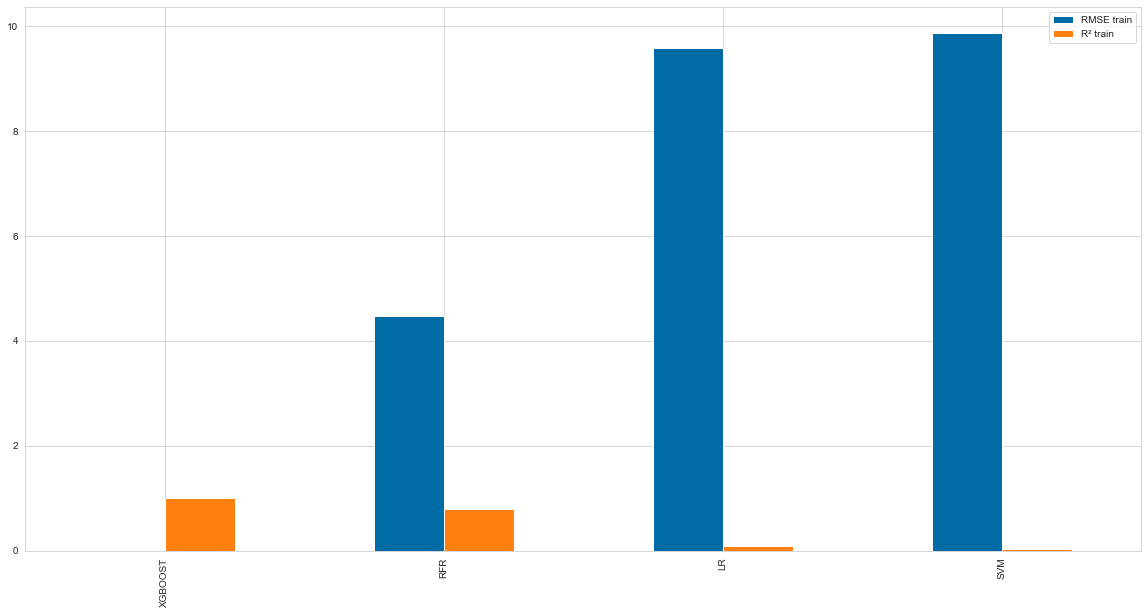

In [83]:
best_print[['RMSE train', 'R² train']].plot(kind = 'bar');